Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: Aleksejs Timcenko, Nitin Sharma

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
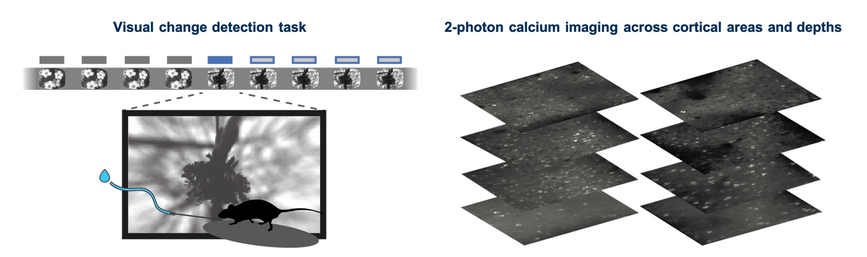

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

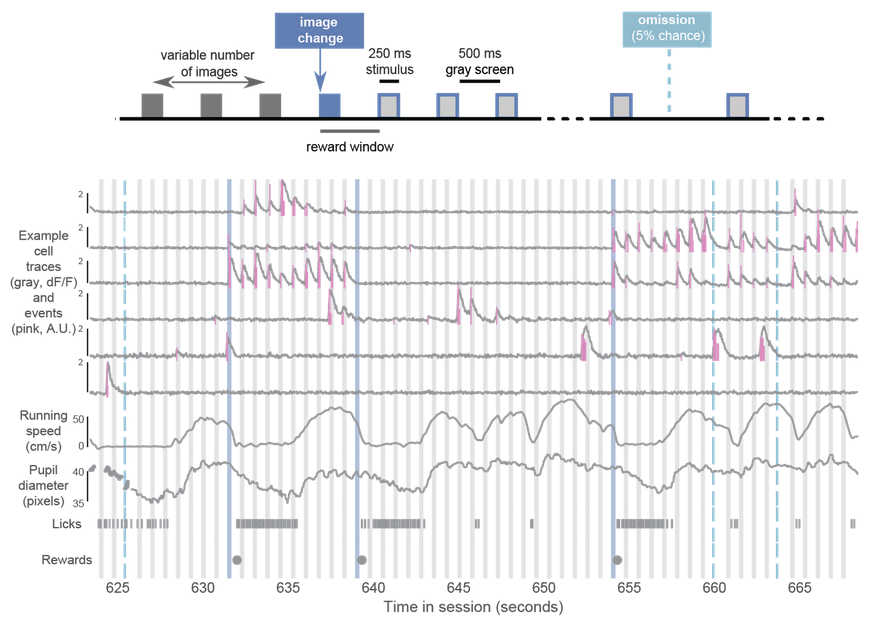

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

### Question session #1
- Dataset paper link? 

https://portal.brain-map.org/explore/circuits/visual-behavior-2p
- Maximum activity projection? 

*Just plot it*
- ROI?
- Features in stimulus metadata?
- What do licks mean? What does mouse get reward for? PAPER PAPER PAPER PAPER

- What is spatial structure? Is it in the brain? Or in spatial location of a visual stimulus?
- Cell types mentioned - no data on them

## Imports

In [124]:
# import packages here

# working with data
import numpy as np
import pandas as pd
from scipy import signal, stats, ndimage

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# system
from pathlib import Path
import os
import time
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

# clustering algorithms
import sklearn
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import silhouette_score



# from utils import (create_folder_structure, 
#                    load_data,
#                    load_spikes, 
#                    load_rf, 
#                    print_info, 
#                    find_index, 
#                    shape2str, 
#                    get_stim_spike_data, 
#                    get_stim_dff_data,
#                    get_discrete_colors,
#                    get_continuous_colors) 

data_path = Path("../data/")
#create_folder_structure()

## Loading data

In [2]:
# load data
# def load_data(path="."):
#     def array2df(d, key, cols):
#         d[key] = pd.DataFrame(d[key], columns=cols)

#     data = np.load(path / "dff_data_rf.npz", allow_pickle=True)
#     data = dict(data)
#     array2df(data, "stim_table", ["frame", "start", "end"])
#     array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

# return data

def load_data(path):
    data = np.load(path, allow_pickle=True).item()
    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")

data_path = Path("../data/")

data = load_data(data_path / "prac2_data.npy")

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 5)
[stim] - <class 'numpy.ndarray'>, - (8880, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 5)



In [3]:
times = data['t'].copy()
dff = data['dff'].copy()
stim_table = data['stim_table'].copy()
stim_epoch_table = data['stim_epoch_table'].copy()
stim = data['stim'].copy()
stim = stim[stim_table['frame']]
roi = data['roi_masks'].copy()
max_projection = data['max_projection'].copy()

n_neurons, n_times = dff.shape
stim_shape = stim[0].shape
n_stim = stim_table.shape[0]
roi_shape = max_projection.shape

dt = times[1] - times[0]

print(f"Max time: {times[-1]}")
print(f"Number of neurons: ", n_neurons)
print("Stimulus frame shape: ", stim_shape)
print("Number of presented stimuli: ", n_stim)

cascade_models = ["Global_EXC_30Hz_smoothing50ms_causalkernel", 
                  "Global_EXC_30Hz_smoothing25ms_causalkernel",
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_1_frame", 
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_4_frames", 
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_8_frames"]

Max time: 3524.5851
Number of neurons:  189
Stimulus frame shape:  (16, 28)
Number of presented stimuli:  8880


In [4]:
# sampling is not uniform or I don't know
print("Timesteps are slightly different: \n \n", np.unique(np.diff(times)))
print("\nMean timestep: ", np.mean(np.diff(times)))
print("Mean sampling rate: ", 1 / np.mean(np.diff(times)))

Timesteps are slightly different: 
 
 [0.03317 0.03317 0.03317 0.03317 0.03317 0.03317 0.03317 0.03317 0.03317
 0.03317 0.03318 0.03318 0.03318 0.03318 0.03318 0.03318 0.03318 0.03318
 0.03318 0.03318 0.03318]

Mean timestep:  0.03317311002481905
Mean sampling rate:  30.144897456157484


## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

**Sub-tasks**

1. Pre-processing
    - Load the data and inspect its dimensions, types, and values.
    - Filter out any missing, invalid, or corrupted data points.
    - Normalize the data to remove any unwanted effects of scale, noise, or outliers.
    - Select the subset of data that corresponds to the locally sparse noise stimulus.
    - Visualize the data using plots or maps to explore its distribution and variation.
2. Spike inference
    - Choose a suitable spike inference method for your data, such as deconvolution, template matching, or probabilistic modeling¹²³.
    - Apply the spike inference method to the calcium imaging data to estimate the spike trains of individual neurons.
    - Evaluate the accuracy and reliability of the spike inference method using metrics such as correlation coefficient, false discovery rate, or receiver operating characteristic curve¹²³.
    - Compare the spike inference results across different neurons, stimuli, and trials.
3. Tuning function fitting
    - Define a tuning function model that describes how the spike rate of a neuron depends on the stimulus features, such as orientation, spatial frequency, or contrast⁴⁵⁶.
    - Fit the tuning function model to the spike data using a suitable optimization or estimation method, such as least squares, maximum likelihood, or Bayesian inference⁴⁵⁶.
    - Assess the goodness-of-fit of the tuning function model using metrics such as coefficient of determination, Akaike information criterion, or Bayesian information criterion⁴⁵⁶.
    - Estimate the tuning parameters of each neuron, such as preferred orientation, bandwidth, or amplitude⁴⁵⁶.
4. Statistical testing
    - Formulate a null hypothesis and an alternative hypothesis about the spatial structure of the receptive fields⁷⁸⁹.
    - Choose a suitable statistical test for your data and hypotheses, such as spatial autocorrelation test, global envelope test, or Mantel test⁷⁸⁹.
    - Perform the statistical test on your data and obtain a test statistic and a p-value⁷⁸⁹.
    - Interpret the results of the statistical test and draw conclusions about the spatial structure of the receptive fields⁷⁸⁹.

Optional tasks: 

5. Proper statistical assessment
    - Check the assumptions and limitations of your chosen statistical test and verify that they are met by your data⁷⁸⁹.
    - Perform sensitivity analysis or robustness checks to evaluate how your results depend on your choices of parameters, methods, or models⁷⁸⁹.
    - Report your results with confidence intervals or error bars to indicate the uncertainty and variability of your estimates⁷⁸⁹.
    - Discuss the implications and significance of your results for your main question and relate them to previous studies or theories⁷⁸⁹.

6. Focus on specific cell types
    - Identify the different cell types in your data based on their genetic markers, morphology, or electrophysiology  .
    - Select a subset of neurons that belong to a specific cell type of interest, such as excitatory, inhibitory, or modulatory  .
    - Repeat the previous tasks (1-5) for the selected subset of neurons and compare the results with the whole population  .
    - Investigate how the cell type affects the spatial structure of the receptive fields and the tuning properties of the neurons  .


Source:
(1) Inferring spikes from calcium imaging in dopamine neurons. https://www.biorxiv.org/content/10.1101/2020.12.05.412965v1. 
(2) Inferring Neuronal Dynamics from Calcium Imaging Data Using ... - PLOS. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004736.
(3) Inferring spikes from calcium imaging in dopamine neurons. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0252345.
(4) Inferring spikes from calcium imaging in dopamine neurons. https://collaborate.princeton.edu/en/publications/inferring-spikes-from-calcium-imaging-in-dopamine-neurons.
(5) Receptive Field Shift and Shrinkage in Macaque Middle Temporal Area .... https://www.jneurosci.org/content/28/36/8934.
(6) The Development of Receptive Field Tuning Properties in Mouse Binocular .... https://www.jneurosci.org/content/42/17/3546.
(7) Neurobiology 5.2: Tuning Curves, Receptive Fields, Sensory threshold. https://www.youtube.com/watch?v=YvxdNF8oGiQ.
(8) GeoDa: An Introduction to Spatial Data Analysis | Spatial .... https://spatial.uchicago.edu/geoda.
(9) Global Envelope Tests for Spatial Processes - Oxford Academic. https://academic.oup.com/jrsssb/article/79/2/381/7041937.

**This one should be deleted before submission** <br>
**Sources from where we can use the code for this data analysis**

- [1](^1^): Python package for analyzing behavioral data for Brain Observatory: Visual Behavior 2P Project. It contains code for creating a core data structure with licks, rewards, trials, running, visual stimuli, and metadata. It also has functions for plotting, filtering, and transforming the data. It is an official repository from the Allen Institute and it is actively maintained and updated.
- [2](^2^): Tensorflow implementation of DETR: Object Detection with Transformers. It includes code for inference, training, and finetuning the model on various datasets, including the Visual Behavior 2P data. It is an unofficial repository from a group of researchers and it is not affiliated with the Allen Institute or the original authors of DETR.
- [3](^3^): Documentation page for the Allen SDK, which is a Python library that provides tools for accessing and analyzing data from the Allen Brain Atlas projects. It has a section on how to get started with the Visual Behavior 2P data, including how to download, load, and explore the data using the SDK methods and classes.
- [4](^4^): Web page that showcases the Python package from [1](^1^) as an awesome Python project. It provides a brief overview of the package and its features, as well as a link to the GitHub repository.


Source: 
(1) GitHub - AllenInstitute/visual_behavior_analysis: Python package for .... https://github.com/AllenInstitute/visual_behavior_analysis.<br>
(2) GitHub - Visual-Behavior/detr-tensorflow: Tensorflow implementation of .... https://github.com/Visual-Behavior/detr-tensorflow.<br>
(3) GETTING STARTED — Allen SDK dev documentation - Read the Docs. https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html.<br>
(4) Python package for analyzing behavioral data for Brain Observatory .... https://pythonawesome.com/python-package-for-analyzing-behavioral-data-for-brain-observatory-visual-behavior/.


# I. Data exploration

## Stimuli

### Dataframes with descriptions

In [5]:
data.keys()

dict_keys(['t', 'dff', 'stim_table', 'stim', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])

In [6]:
data['t']

array([   9.33015,    9.36332,    9.39649, ..., 3524.51876, 3524.55193,
       3524.5851 ])

**Summary of each Key in data**

n_times = 105968 #no. of frames <br>
n_neurons = 189 #no. of neurons <br>
n_stim = 8880 #no. of stiumuls <br>
height, width = 16, 25   #Stimulus frame shape <br>
height, width = 512, 512   #for ROI mask <br>
n_epochs = 7 #no. of stimulus epochs


- 't': This is an array of time points in seconds for each frame of the calcium imaging data. It has a shape of (n_times,), where n_times is the number of frames.
- 'dff': This is an array of the preprocessed calcium activity traces (df/f) for each neuron. It has a shape of (n_neurons, n_times), where n_neurons is the number of neurons and n_times is the same as above.
- 'stim_table': This is a dataframe that contains the metadata of the stimulus presentation, such as the frame number, the start and end time, and the stimulus type. It has a shape of (n_stim, 3), where n_stim is the number of presented stimuli.
- 'stim': This is an array of the stimulus frames that were shown to the mice. Each frame is a grayscale image with a shape of (height, width). The whole array has a shape of (n_stim, height, width).
- 'roi_masks': This is an array of the region of interest (ROI) masks for each cell. Each mask is a binary image with a shape of (height, width) that indicates the pixels that belong to a cell. The whole array has a shape of (n_neurons, height, width).
- 'max_projection': This is an image that shows the maximum activity projection of all ROIs. It has a shape of (height, width) and it can be used to visualize the spatial distribution of the cells.
- 'running_speed': This is an array of the running speed of the mouse in cm/s for each frame. It has a shape of (n_times,).
- 'stim_epoch_table': This is a dataframe that contains the information about the stimulus epochs, such as the start and end time and the stimulus name. It has a shape of (n_epochs, 3), where n_epochs is the number of stimulus epochs.


In [7]:
data['stim_table']

frame   start     end     t_start       t_end
0         0     737     744    33.77772    34.00992
1         1     745     752    34.04309    34.27530
2         2     752     759    34.27530    34.50750
3         3     760     767    34.54067    34.77287
4         4     767     774    34.77287    35.00508
...     ...     ...     ...         ...         ...
8875   8875  105705  105712  3515.89347  3516.12569
8876   8876  105712  105719  3516.12569  3516.35791
8877   8877  105720  105727  3516.39108  3516.62330
8878   8878  105727  105734  3516.62330  3516.85552
8879   8879  105735  105742  3516.88870  3517.12092

[8880 rows x 5 columns]

In [8]:
stim_epoch_table

stimulus  start     end     t_start       t_end
0  locally_sparse_noise    737   22461    33.77772   754.41080
1           spontaneous  22611   31520   759.38668  1054.92135
2     natural_movie_one  31521   40571  1054.95452  1355.16827
3  locally_sparse_noise  41476   63199  1385.18974  2105.80958
4     natural_movie_two  64105   73156  2135.86464  2436.11760
5           spontaneous  73306   82207  2441.09363  2736.37216
6  locally_sparse_noise  82208  105742  2736.40533  3517.12092

In [9]:
# let's add the times here as well
stim_epoch_table['t_start'] = stim_epoch_table['start'].apply(lambda i: times[i])
stim_epoch_table['t_end'] = stim_epoch_table['end'].apply(lambda i: times[i])

stim_table['t_start'] = stim_table['start'].apply(lambda i: times[i])
stim_table['t_end'] = stim_table['end'].apply(lambda i: times[i])

stim_name = "locally_sparse_noise"

stim_epoch_table

stimulus  start     end     t_start       t_end
0  locally_sparse_noise    737   22461    33.77772   754.41080
1           spontaneous  22611   31520   759.38668  1054.92135
2     natural_movie_one  31521   40571  1054.95452  1355.16827
3  locally_sparse_noise  41476   63199  1385.18974  2105.80958
4     natural_movie_two  64105   73156  2135.86464  2436.11760
5           spontaneous  73306   82207  2441.09363  2736.37216
6  locally_sparse_noise  82208  105742  2736.40533  3517.12092

### Stimulus frame visualization

Minimal value of a pixel:  -1
Maximal value of a pixel:  1
Shape of Stimulus: (16, 28)


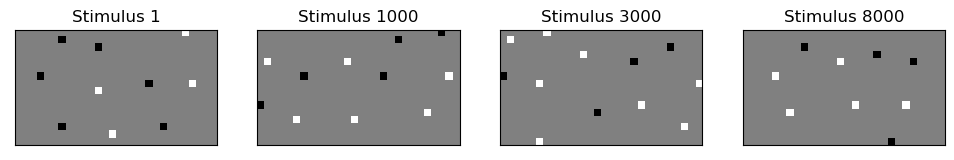

In [10]:
stim_indices = [1, 1000, 3000, 8000]
fig, axes = plt.subplots(1, len(stim_indices), figsize=(len(stim_indices) * 3, 3))
for i, i_stim in enumerate(stim_indices):
    ax = axes[i]
    ax.set_title(f"Stimulus {i_stim}")
    ax.imshow(stim[i_stim], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
print("Minimal value of a pixel: ", np.min(stim[i_stim]))
print("Maximal value of a pixel: ", np.max(stim[i_stim]))
print('Shape of Stimulus:', stim[i_stim].shape)

Let's convert the values of the pixels to the normalized range from $-1$ to $+1$. This way if pixel is not activated, in the original data it will take value equals $127$, which will be transformed into $0$. If it was black, it will take value $0$, which is converted to $-1$, and $255$ will be converted to $+1$.

In [11]:
stim = stim.astype(int)
stim[stim == 0]   = -1
stim[stim == 127] = 0
stim[stim == 255] = 1
np.unique(stim)

array([-1,  1])

### Distribution of a single pixel

Probability of different stimulus values across image presentations: 
-1: 0.9881
0: 0.0000
1: 0.0119


Text(0.5, 1.0, 'Counts of pixel at location (5,5) for all stimulus')

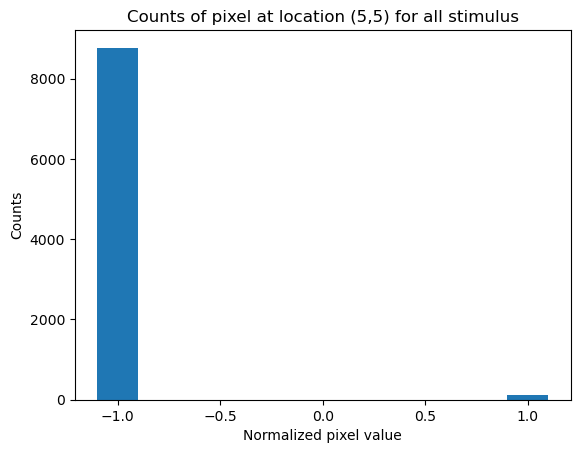

In [12]:
p0, p1 = (5, 5) # pixel coordinates
pixel_vals = stim[:, p0, p1]
print("Probability of different stimulus values across image presentations: ")

for val in [-1, 0, 1]:
    print(f"{val}: {np.sum(pixel_vals == val) / pixel_vals.size:.4f}")
plt.hist(pixel_vals, bins=[-1.1, -0.9, -0.1, 0.1, 0.9, 1.1], density=False);
plt.xlabel('Normalized pixel value')
plt.ylabel('Counts')
plt.title('Counts of pixel at location (5,5) for all stimulus')

From above graph, we can conclude that the stimulus presented is sparse noise as most of the pixel values are zeros.

### Stimulus statistics

- Fraction of $1$ and $-1$ values in the frame

Text(0.5, 0, '#(pixel = -1) + #(pixel = 1)')

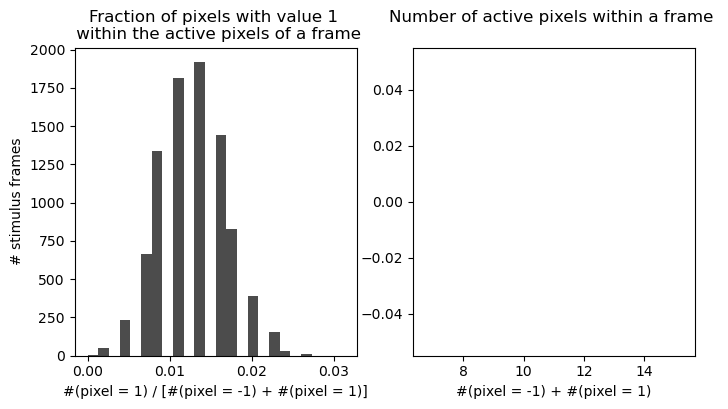

In [13]:
stim_flat = stim.reshape((stim.shape[0], -1)) # flatten the frame
n_nonzero = (stim_flat != 0).sum(axis=1)
frac_ones = (stim_flat == 1).sum(axis=1) / n_nonzero

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.set_title("Fraction of pixels with value 1 \n within the active pixels of a frame")
ax.hist(frac_ones, bins=24, color='black', alpha=0.7);
ax.set_xlabel("#(pixel = 1) / [#(pixel = -1) + #(pixel = 1)]")
ax.set_ylabel("# stimulus frames")

ax = axes[1]
ax.set_title("Number of active pixels within a frame \n")
ax.hist(n_nonzero, bins=np.arange(7, 17) - 0.5, color='blue', alpha=0.7, rwidth=0.5);
ax.set_xlabel("#(pixel = -1) + #(pixel = 1)")

(array([8.522e+03, 0.000e+00, 0.000e+00, 0.000e+00, 1.690e+02, 1.860e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([0.2322  , 0.238837, 0.245474, 0.252111, 0.258748, 0.265385,
        0.272022, 0.278659, 0.285296, 0.291933, 0.29857 ]),
 <BarContainer object of 10 artists>)

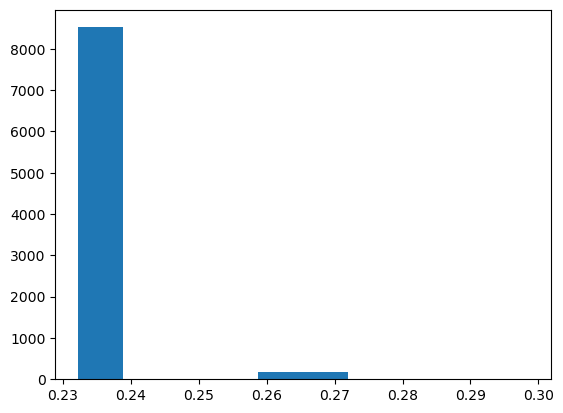

In [14]:
# duration of a stimulus
stim_start = stim_table['start'].values
stim_end   = stim_table['end'].values

durations = times[stim_end] - times[stim_start]
plt.hist(durations)

## Save transformed data for future use

In [15]:
# check how many stimuli for each epoch are recorded in the stim_table
bounds = stim_epoch_table[stim_epoch_table.stimulus == 'locally_sparse_noise'].values[:, 1:3].astype(int)
bins = bounds.flatten()
counts, _ = np.histogram(stim_table.start.values, bins=bins)
counts    = np.array([counts[0], counts[2], counts[4]])
durations = bounds[:, 1] - bounds[:, 0]

print(f"{durations} - Epoch durations in samples")
print(f"{counts} - Number of stim_table entries lying in each epoch")
print(f"{counts / durations / (times[1] - times[0])} - Average frequency of stim presentation within the epoch (Hz)")
print()
print(f"{counts.sum()} - Sum of stim_table entries lying within any of 3 epochs")
print(f"{len(stim_table)} - Total # stim_table entries")
print(f"{stim.shape} - Shape of the provided stimulus matrix")
print()
print(f"WTF, stimulus shape is 9000...")
print(f"Where are missing 120 entries??? Cut from the end? From the beginning?")

# asssuming frequency of stimulus presentation is similar
# let's try to understand where they got these 120 missing stim_table entries

[21724 21723 23534] - Epoch durations in samples
[2880 2880 3120] - Number of stim_table entries lying in each epoch
[3.99675219 3.99693618 3.9968088 ] - Average frequency of stim presentation within the epoch (Hz)

8880 - Sum of stim_table entries lying within any of 3 epochs
8880 - Total # stim_table entries
(8880, 16, 28) - Shape of the provided stimulus matrix

WTF, stimulus shape is 9000...
Where are missing 120 entries??? Cut from the end? From the beginning?


In [16]:
new_data = data.copy()
new_data['stim_epoch_table'] = stim_epoch_table
new_data['stim_table'] = stim_table
new_data['stim'] = stim
np.save("../data/prac2_data.npy", new_data, allow_pickle=True)

## Calcium imaging

### Locations

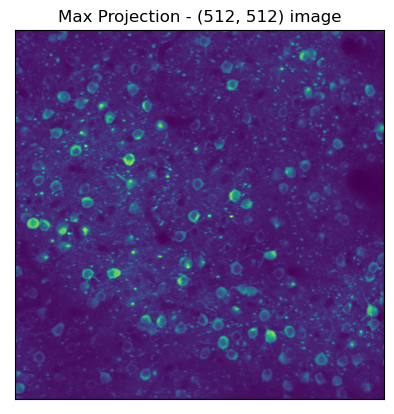

In [17]:
plt.imshow(data['max_projection'])
plt.title(f"Max Projection - {data['max_projection'].shape} image");
plt.xticks([]); plt.yticks([]);


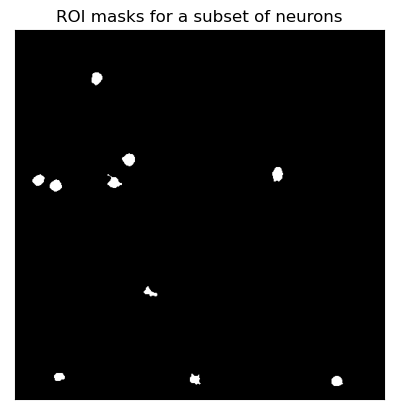

In [18]:
roi_layers = np.zeros(roi_shape)
for neuron in range(0, 100, 10):
    roi_layers += roi[neuron]
plt.imshow(roi_layers, cmap='gray')
plt.title("ROI masks for a subset of neurons")
plt.xticks([]); plt.yticks([]);

Let's look at the location mask in more detail.
For this let's find values of $x$ and $y$, which are defining the borders of ROI - this will allow to zoom in the ROI mask automatically.

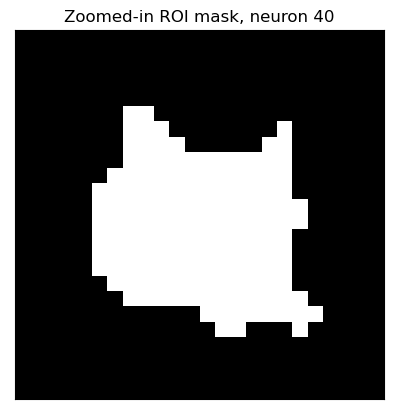

In [19]:
neuron = 40
roi_example = roi[neuron]
x_nonzero = np.nonzero(roi_example.sum(axis=0))[0]
y_nonzero = np.nonzero(roi_example.sum(axis=1))[0]
xmin, xmax = x_nonzero[0] - 5, x_nonzero[-1] + 5
ymin, ymax = y_nonzero[0] - 5, y_nonzero[-1] + 5

plt.title(f"Zoomed-in ROI mask, neuron {neuron}")
plt.imshow(roi_example[ymin:ymax, xmin:xmax], cmap='gray')
plt.xticks([]); plt.yticks([]);

*Looks like a cat :D*

### Trace visualization

In [20]:
# THIS FUNCTION WILL GO TO UTILS

def find_index(arr, val):
    """ 
    Returns the exact index of a number val in array arr or the closes one possible.
    Does not work when such index is not uniquely defined.
    If val is a single number returns single index
    If val is iterable returns iterable of indices of the same shape   
    """
    # check if val is iterable
    try:
        val[0] # if not iterable raises an error
    except:
        # if not iterable - return the single index
        index = np.argmin(np.abs(np.array(arr) - val))
        return index
    # if got to this point it is definitely iterable
    indices = []
    for v in val:
        indices.append(np.argmin(np.abs(np.array(arr) - v)))
    return indices      

#### Visualize dF/F(t) for a subset of neurons

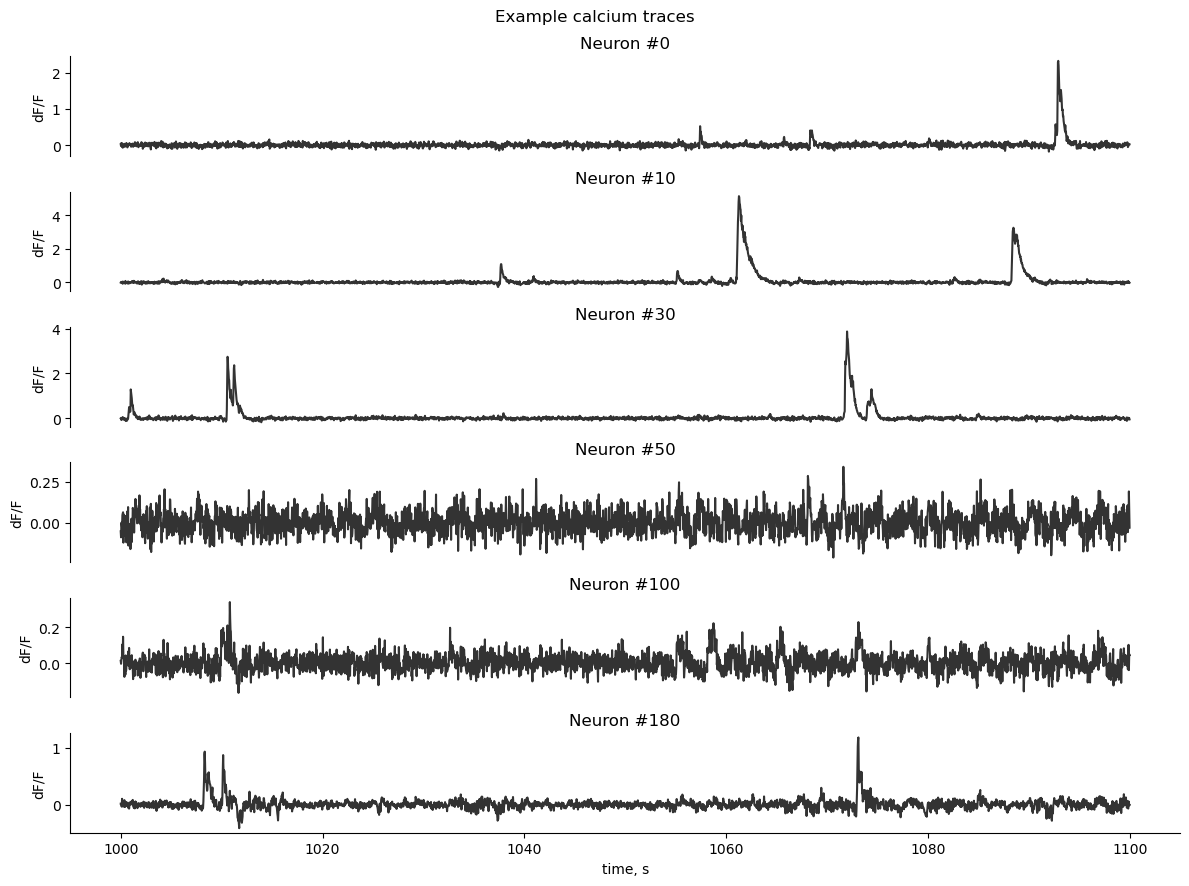

In [21]:
tlim = (1000, 1100)
it1, it2 = find_index(times, tlim)

neurons_list = [0, 10, 30, 50, 100, 180]
n = len(neurons_list)

fig, axes = plt.subplots(n, 1, figsize=(12, 1.5 * n))

for i in range(n):
    ax = axes[i]
    neuron = neurons_list[i]
    ax.set_title(f"Neuron #{neuron}")
    # plotting the trace
    ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)
    ax.set_ylabel("dF/F")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if i < n - 1: ax.set_xticks([])

ax.spines['bottom'].set_visible(True)
ax.set_xlabel("time, s")
plt.suptitle("Example calcium traces")
plt.tight_layout();

#### Visualize the same but with stimulus overlay

We will need to pick the relevant stimulus epochs.

In [22]:
data['stim_epoch_table']

stimulus  start     end     t_start       t_end
0  locally_sparse_noise    737   22461    33.77772   754.41080
1           spontaneous  22611   31520   759.38668  1054.92135
2     natural_movie_one  31521   40571  1054.95452  1355.16827
3  locally_sparse_noise  41476   63199  1385.18974  2105.80958
4     natural_movie_two  64105   73156  2135.86464  2436.11760
5           spontaneous  73306   82207  2441.09363  2736.37216
6  locally_sparse_noise  82208  105742  2736.40533  3517.12092

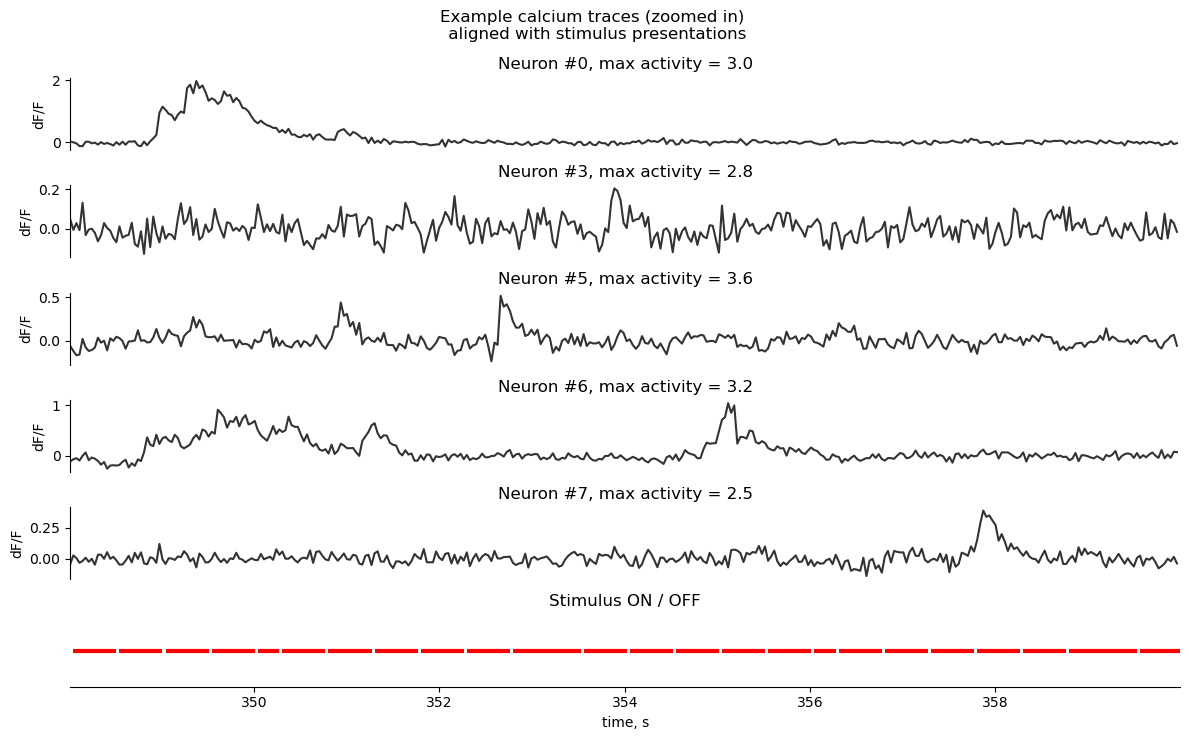

In [23]:
delta_it = 100
it_start = 1800
it1, it2 = (it_start, it_start + delta_it)

tlim = (348, 360)
it1, it2 = find_index(times, tlim)

neurons_list = [0, 3, 5, 6, 7]
n = len(neurons_list)

fig, axes = plt.subplots(n + 1, 1, figsize=(12, 1.5 * n))
plt.suptitle("Example calcium traces (zoomed in) \n aligned with stimulus presentations")

for i in range(n + 1):
    
    ax = axes[i]
    
    if i < n:
        # plotting the trace
        neuron = neurons_list[i]
        ax.set_title(f"Neuron #{neuron}, max activity = {np.max(dff[neuron]):.1f}")
        ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("dF/F")
        ax.set_xticks([])
        for loc in ['top', 'right', 'bottom']:
            ax.spines[loc].set_visible(False)
    else:
        # plotting the stimulus as horizontal lines
        stim_xpos_start = times[stim_table['start'].values]
        stim_xpos_end   = times[stim_table['end'].values]
        
        ax.set_title("Stimulus ON / OFF")
        ax.hlines(y = np.zeros(len(stim_xpos_start)), 
                  xmin = stim_xpos_start, 
                  xmax = stim_xpos_end, 
                  colors='red', 
                  linewidth=3)
        ax.set_ylim((-0.5, 0.5))
        ax.set_xlabel("time, s")
        ax.set_yticks([])
        for loc in ['top', 'right', 'left']:
            ax.spines[loc].set_visible(False)
        
    ax.set_xlim((times[it1], times[it2]))
    

plt.tight_layout();

#### For the whole dataset

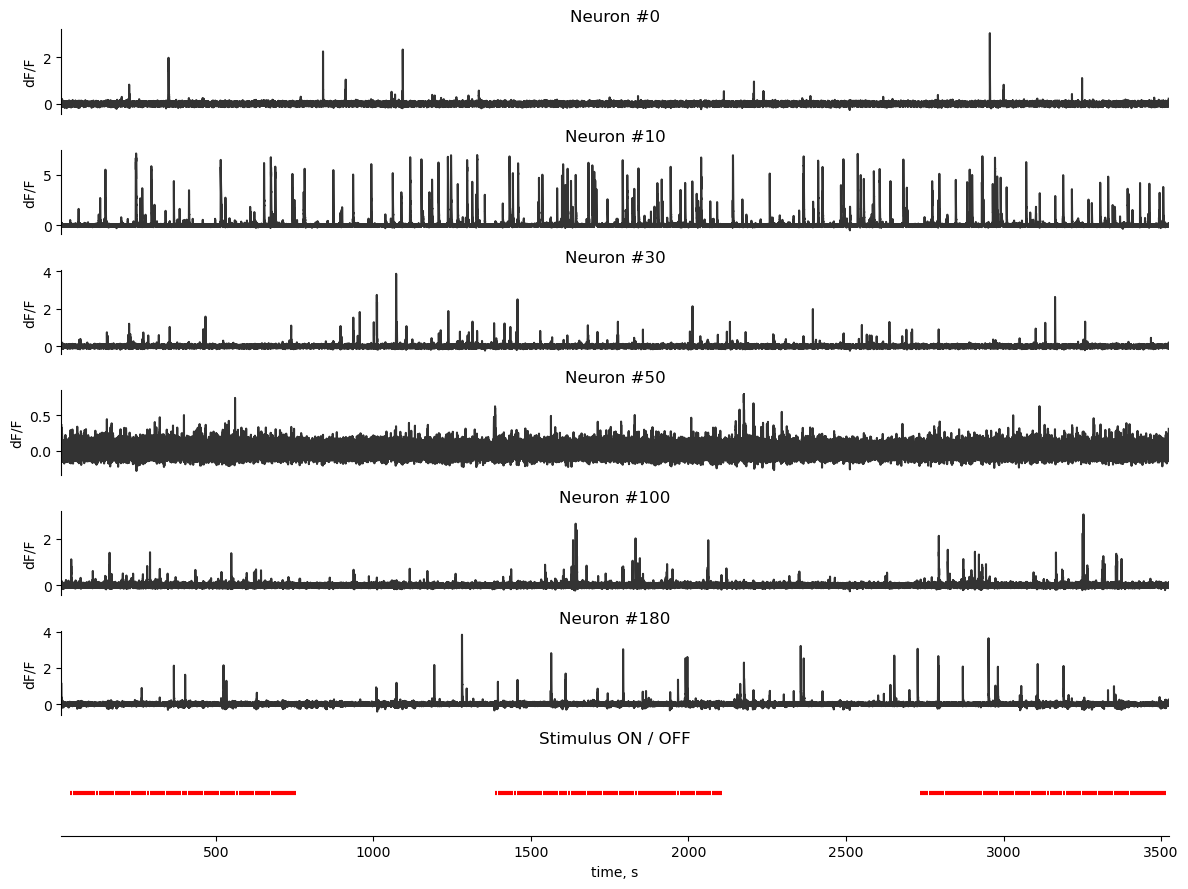

In [24]:
it1, it2 = 0, len(times) - 1 

neurons_list = [0, 10, 30, 50, 100, 180]
n = len(neurons_list)

fig, axes = plt.subplots(n + 1, 1, figsize=(12, 1.5 * n))

for i in range(n + 1):
    
    ax = axes[i]
    
    if i < n:
        # plotting the trace
        neuron = neurons_list[i]
        ax.set_title(f"Neuron #{neuron}")
        ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("dF/F")
        ax.set_xticks([])
        for loc in ['top', 'right', 'bottom']:
            ax.spines[loc].set_visible(False)
    else:
        # plotting the stimulus as horizontal lines
        stim_xpos_start = times[stim_table['start'].values]
        stim_xpos_end   = times[stim_table['end'].values]
        
        ax.set_title("Stimulus ON / OFF")
        ax.hlines(y = np.zeros(len(stim_xpos_start)), 
                  xmin = stim_xpos_start, 
                  xmax = stim_xpos_end, 
                  colors='red', 
                  linewidth=3)
        ax.set_ylim((-0.5, 0.5))
        ax.set_xlabel("time, s")
        ax.set_yticks([])
        for loc in ['top', 'right', 'left']:
            ax.spines[loc].set_visible(False)
        
    ax.set_xlim((times[it1], times[it2]))

plt.tight_layout();

#### Visualize dFF(t) for all neurons (heatmap)

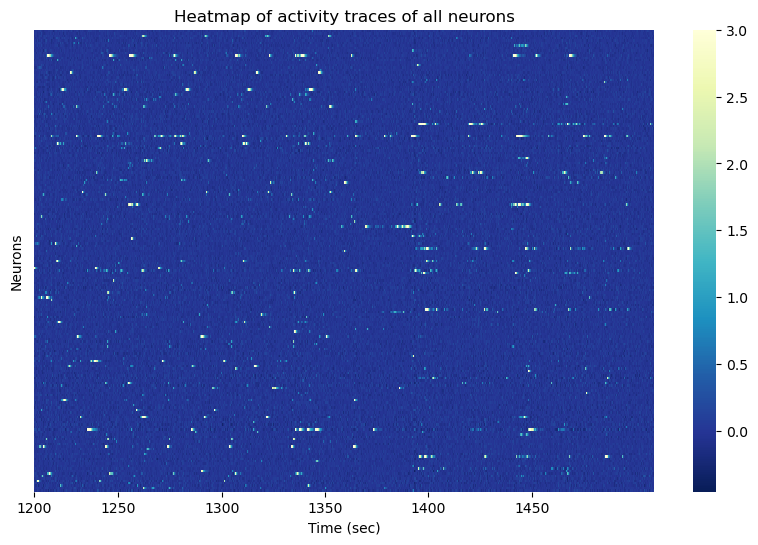

In [25]:
# Plot heatmap of activity traces of all neurons

tlim = (1200, 1500) # seconds
ttickstep = 50     # seconds

it1, it2 = find_index(times, tlim)

plt.figure(figsize=(10,6))
sns.heatmap(dff[:, it1:it2], xticklabels=False, yticklabels=False, cmap='YlGnBu_r', cbar=True, vmax=3)

# set correct ticks
tticklabels = np.arange(*tlim, ttickstep)
tticks = find_index(times, tticklabels - tticklabels[0])
plt.xticks(tticks, tticklabels)
plt.xlabel('Time (sec)')
plt.ylabel('Neurons')
plt.title('Heatmap of activity traces of all neurons')
plt.show()

### Characterize fluorescent activity of neurons

Different neurons show different activity patterns and overall activity levels. These differenes can be characterized by different metrics. Probably, we are not very interested in neurons, which activity is too low. 

Activity could be characterized using following statistics:
- max value
- median
- mean
- 0.9 quantile
- std
- robust std: $\hat{\sigma} = median \big[ \frac{|x - \overline{x}|}{0.6745} \big]$
- % activity above robust std : $\#(x > \hat{\sigma}) \ / \ \#(x)$
- num events: (need event detection): can be approximated by amount of crossings of threshold divided by two.

In [26]:
%%time
from utils import (est_max, 
                   est_mean, 
                   est_median, 
                   est_quantile, 
                   est_std, 
                   est_robust_std, 
                   est_percent_activity, 
                   est_num_events)

func_names = ["max", "mean", "median", "quantile", "std", "robust std", "% activity", "num events"]
funcs = [est_max, est_mean, est_median, est_quantile, est_std, est_robust_std, est_percent_activity, est_num_events]
neuron_stats = {func_name: np.empty(n_neurons) for func_name in func_names}

for i in range(len(funcs)):
    func = funcs[i]
    func_name = func_names[i]
    for neuron in range(n_neurons):
        neuron_stats[func_name][neuron] = func(dff, neuron) 

CPU times: total: 1.83 s
Wall time: 1.83 s


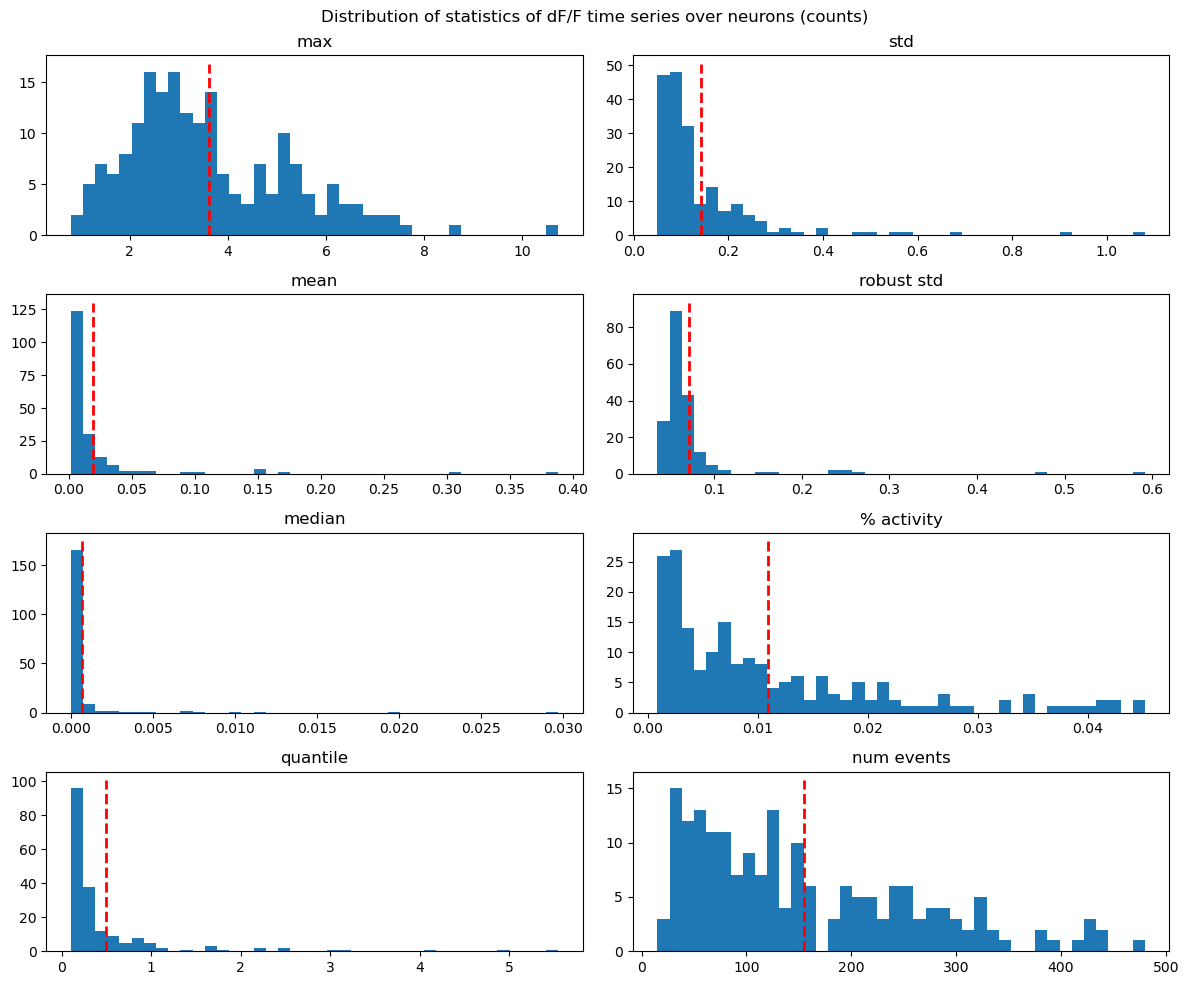

In [27]:
# visualize distributions for each statistic
nrows, ncols = int(np.ceil(len(funcs) / 2)), 2
fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 3, ncols * 5))

for i in range(len(funcs)):
    irow, icol = i % nrows, i // nrows
    ax = axes[irow, icol]
    
    func = funcs[i]
    func_name = func_names[i]
    ax.set_title(func_name)
    
    values = neuron_stats[func_name]
    mean = values.mean()
 
    ax.hist(values, bins=40)
    
    ax.vlines(mean, *ax.get_ylim(), linestyle='--', colors='red', linewidth=2)

plt.suptitle("Distribution of statistics of dF/F time series over neurons (counts)")
plt.tight_layout() 

#### Check how well robust SD works

This saves the image of n_batch traces with inferred robust threshold for each neuron on the example time frame of the data.

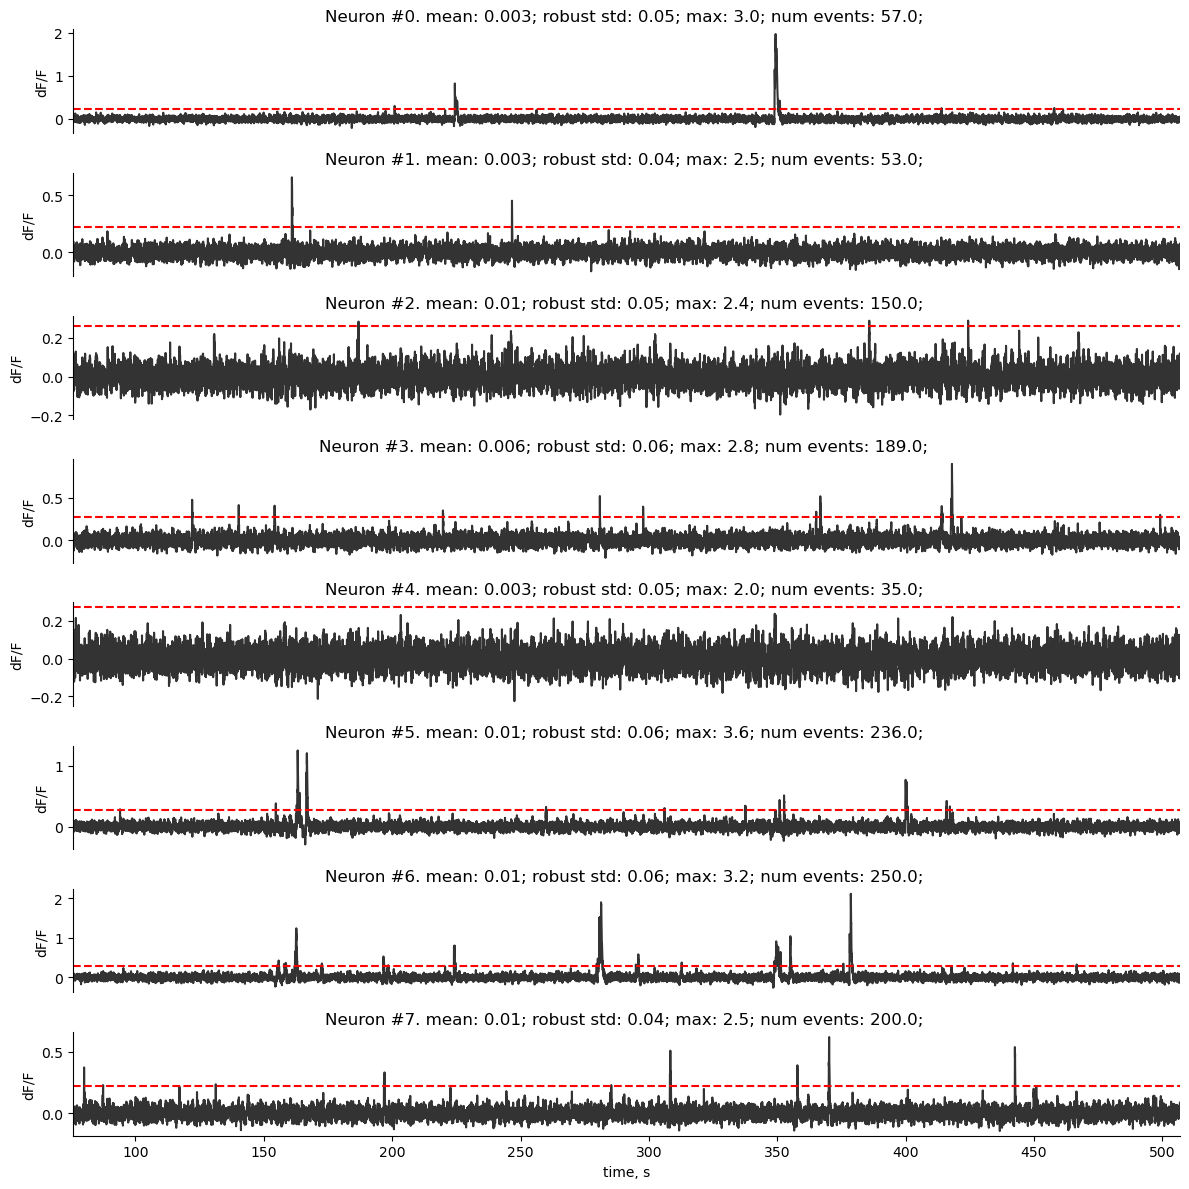

CPU times: total: 37.3 s
Wall time: 37.5 s


In [28]:
%%time
it1, it2 = (2000, 15000)
tlim = (times[it1], times[it2])

n_batch = 8
n_chunks = int(np.ceil(n_neurons / n_batch))

for chunk in range(n_chunks):
    
    neurons_list = np.arange(n_batch * chunk, n_batch * (chunk + 1))  
    
    n = len(neurons_list)
    fig, axes = plt.subplots(n, 1, figsize=(12, 1.5 * n))

    for i in range(n):
        ax = axes[i]
        neuron = neurons_list[i]
        if neuron >= n_neurons: continue
        
        relevant_stats = ["mean", "robust std", "max", "num events"]
        stats_str = ""
        for stat in relevant_stats:
            val = neuron_stats[stat][neuron]
            n_decimals = -int(np.log10(val)) + 1 if val < 1 else 1
            stats_str += f"{stat}: {np.round(val, n_decimals)}; "
        
        ax.set_title(f"Neuron #{neuron}. {stats_str}")
        # plotting the trace
        ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)

        # plotting the threshold for detecting events
        ax.hlines(neuron_stats['robust std'][neuron] * 5, *tlim, color='red', linestyle='--')
        
        ax.set_xlim(tlim)
        ax.set_ylabel("dF/F")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        if i < n - 1: ax.set_xticks([])

    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel("time, s")
    plt.tight_layout()
    plt.savefig(f"../img/ca_traces/with_robust_std/segment{chunk:02d}.png", dpi=200)
    # show one of the plots in the output
    if chunk == 0: 
        plt.show()
    else:
        plt.close()

# II. Extracting spikes from calcium traces

In order to estimate receptive fields of a rapidly (250 ms) changing stimulus it is needed to convert the slowly changing calcium imaging data to spike rates. In this way it will be possible to construct a design matrix where for each stimulus frame $X_i$ the expected spike count $y_i$ is computed.

Multiple algorithms exist for inferring spike rates from the calcium traces. Starting from deconvolution with exponential kernel, to more advanced generative probabilistic approaches such as oopsi.

For this project we will try and compare two spike inference models:

- OOPSI: https://github.com/liubenyuan/py-oopsi - inferring the most likely spike train based on calcium response.
- Cascade: https://github.com/HelmchenLabSoftware/Cascade - deep learning based spike probability / spike timing inference.

OOPSI (Optimal Optical Spike Inference) uses a Bayesian inference algorithm based on a model of calcium indicator dynamics. It estimates the underlying spike rate by integrating over the unobserved spikes, which allows for a more accurate representation of the neural activity captured in the imaging data.

Cascade, on the other hand, is a deep learning-based method that translates calcium imaging ΔF/F traces into spiking probabilities or discrete spikes. It uses a large ground truth database spanning brain regions, calcium indicators, species, and a deep network trained to predict spike rates from calcium data. Cascade also provides tools to quantify the out-of-dataset generalization for a given model and noise level.

## OOPSI

In [29]:
# import oopsi
# dt = times[1] - times[0]
# samp_freq = 1 / dt

# calcium_spikes = np.empty(dff.shape)

# for i in tqdm(range(n_neurons)):
#     d_gcamp, C_gcamp = oopsi.fast(dff[i,:], dt=dt, iter_max=5, update=True)
#     calcium_spikes[i, :] = d_gcamp
    
# np.save("../data/spikes_oopsi_.npy", calcium_spikes)

### Visualize inferred spikes

Text(0.5, 0.98, 'Neuron: 6')

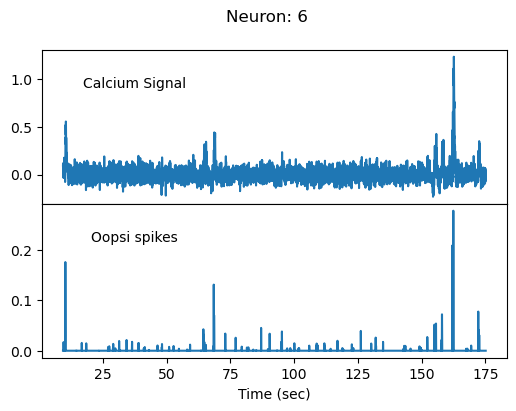

In [37]:
spikes = load_spikes("oopsi_")

start_ind = 0
end_ind = 5000
neuron = 6

fig, axs = plt.subplots(
    2, 1, figsize=(6, 4), gridspec_kw=dict(hspace=0)
)

datas = [dff[neuron,:], spikes[neuron,:]]
titles = ["Calcium Signal", "Oopsi spikes"]

for i, (data, title) in enumerate(zip(datas, titles)):
    axs[i].plot(times[start_ind:end_ind], data[start_ind:end_ind])
    axs[i].set_title(title, x=0.2, y=0.7, fontsize=10)

axs[1].set_xlabel("Time (sec)")
fig.suptitle(f'Neuron: {neuron}')

## Cascade

The Cascade package features a diversity of pretrained deep-learning based models for spike inference. We followed the recommendations of the authors (see github page link above) and tried out models with closely matching sampling rate (30 Hz) as well as causal kernel for smoothing in order not to leak the spikes into the future by smoothing out the predicted spike train. We have also used the largest pretrained model, which trained on all the matching datasets (Global_EXC).

Cascade output so called "spike probabilities", however it is rather a confusing term. What it gives instead is for each time window it predicts the expected number of spikes, which can be larger than 1.

Cascade also smoothes the output with (in our case) causal kernels.
By testing different kernels lengths we found out that the optimal is 50 ms causal kernel. The other models give noiser or less smooth output.

In [39]:
cascade_models = ["Global_EXC_30Hz_smoothing50ms_causalkernel", 
                  "Global_EXC_30Hz_smoothing25ms_causalkernel",
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_1_frame", 
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_4_frames", 
                  "Global_EXC_30Hz_smoothing50ms_asymmetric_window_8_frames"]

model_name = cascade_models[0]
spikes = load_spikes(cascade_models[0])
spikes_cascade = spikes

### Visualize inferred spikes

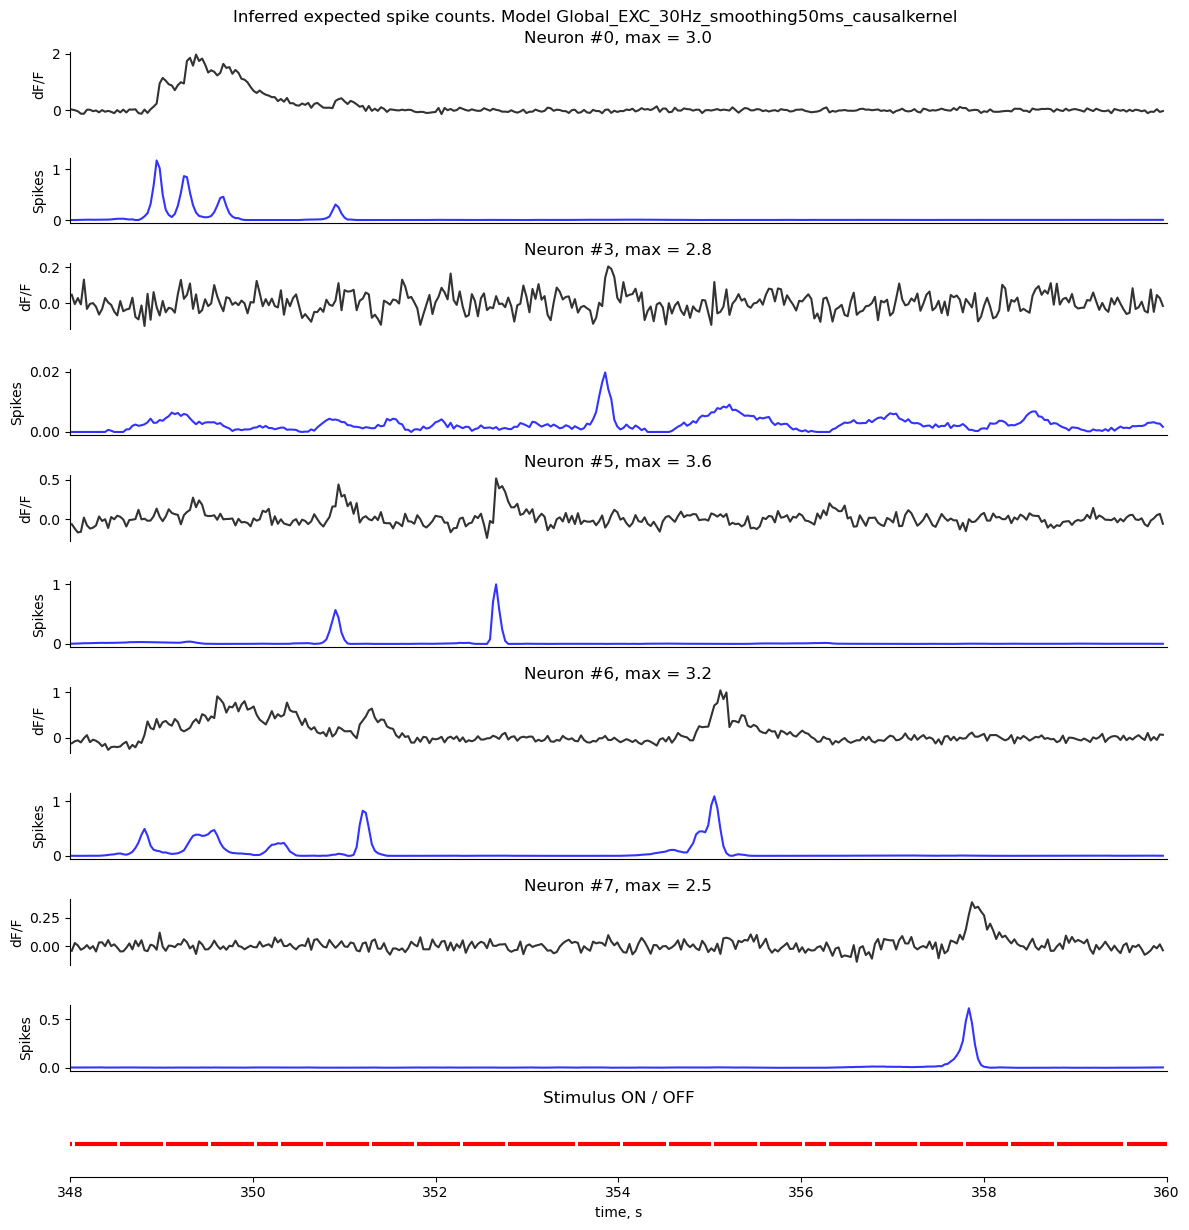

In [40]:
delta_it = 100
it_start = 1800
it1, it2 = (it_start, it_start + delta_it)

tlim = (348, 360)
it1, it2 = find_index(times, tlim)

neurons_list = [0, 3, 5, 6, 7]
n = len(neurons_list)

fig, axes = plt.subplots(2 * n + 1, 1, figsize=(12, 2.5 * n))
plt.suptitle("")

for i in range(n + 1):
    
    if i < n:
        # plot calcium trace
        ax = axes[2 * i]
        neuron = neurons_list[i]  
        ax.set_title(f"Neuron #{neuron}, max = {neuron_stats['max'][neuron]:.1f}")
        ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("dF/F")
        
        ax.set_xticks([])
        for loc in ['top', 'right', 'bottom']:
            ax.spines[loc].set_visible(False)
        
        # plot inferred spikes
        ax = axes[2 * i + 1]
        
        ax.plot(times[it1:it2], spikes[neuron, it1:it2], color='blue', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("Spikes")
        
        ax.set_xticks([])
        for loc in ['top', 'right']:
            ax.spines[loc].set_visible(False)

    else:
        ax = axes[2 * i]
        # plotting the stimulus as horizontal lines
        stim_xpos_start = times[stim_table['start'].values]
        stim_xpos_end   = times[stim_table['end'].values]
        
        ax.set_title("Stimulus ON / OFF")
        ax.hlines(y = np.zeros(len(stim_xpos_start)), 
                  xmin = stim_xpos_start, 
                  xmax = stim_xpos_end, 
                  colors='red', 
                  linewidth=3)
        ax.set_ylim((-0.5, 0.5))
        ax.set_xlabel("time, s")
        ax.set_yticks([])
        for loc in ['top', 'right', 'left']:
            ax.spines[loc].set_visible(False)
            
            
for ax in axes:
    ax.set_xlim(tlim)
    
plt.suptitle(f"Inferred expected spike counts. Model {model_name}")
plt.tight_layout();

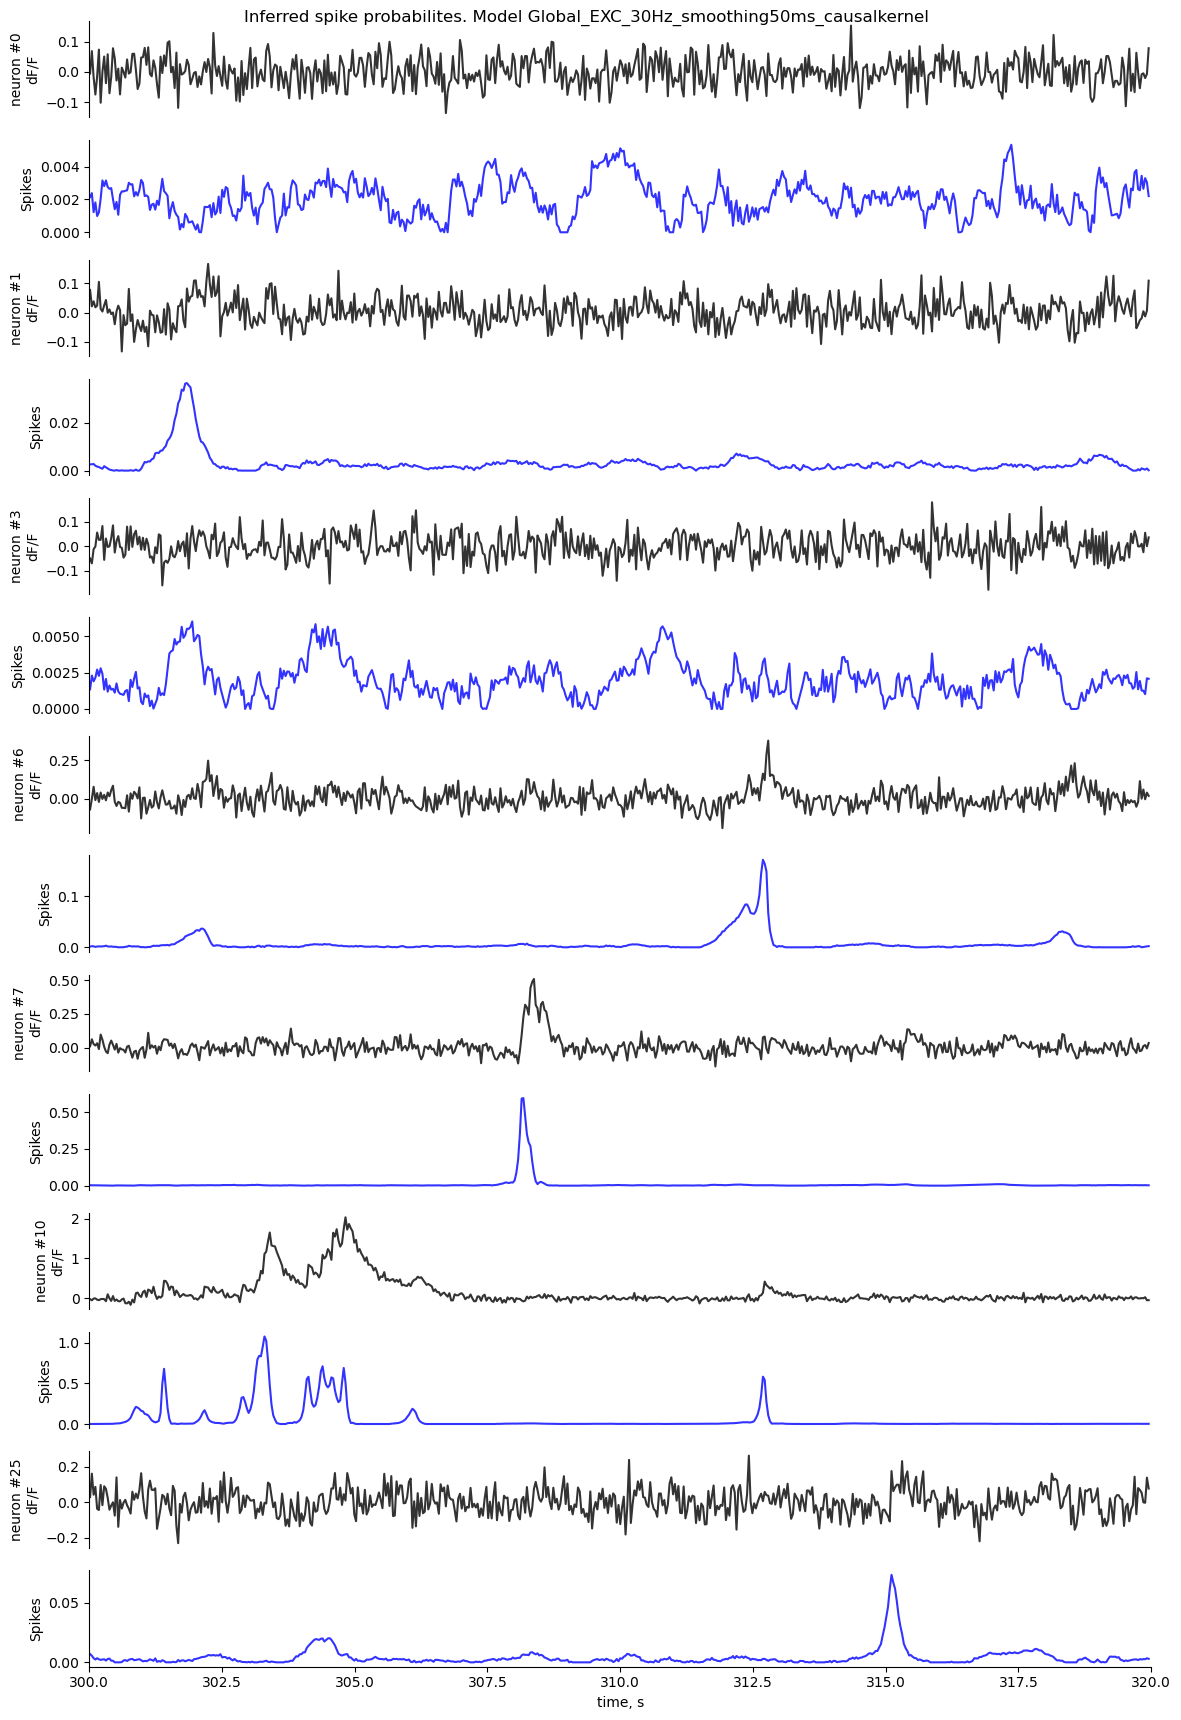

In [41]:
epoch_starts = stim_epoch_table['t_start']
epoch_ends = stim_epoch_table['t_end'] - 200
epoch_idx = 0
tlim = (epoch_starts[epoch_idx], epoch_ends[epoch_idx])
tlim = (300, 320)
it1, it2 = find_index(times, tlim)

neurons_list = [0, 1, 3, 6, 7, 10, 25]
n = len(neurons_list)

fig, axes = plt.subplots(2 * n, 1, figsize=(12, 2.5 * n))
plt.suptitle(f"Inferred spike probabilites. Model {model_name}")

for i in range(n):
    
    neuron = neurons_list[i]
    neuron_str = f"neuron #{neuron}\n"
    
    """ 1. Calcium traces: even rows"""
    ax = axes[2 * i] 
    #ax.set_title(f"Neuron #{neuron}")
    
    # plotting the trace
    ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5, label=f"neuron #{neuron}")
    ax.set_ylabel(neuron_str + "dF/F")
    
    # appearance
    for loc in ['top', 'bottom', 'right']:
        ax.spines[loc].set_visible(False)
    if i == 0: xticks = ax.get_xticks()
    ax.set_xticks([])
    ax.set_xlim(tlim)
    
    """ 2. Inferred spikes: odd rows"""
    ax = axes[2 * i + 1] 
    
    # plotting the trace
    ax.plot(times[it1:it2], spikes[neuron, it1:it2], color='blue', alpha=0.8, linewidth=1.5)
    ax.set_ylabel("Spikes")
    
    # appearance
    for loc in ['top', 'right', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_xticks([])
    ax.set_xlim(tlim)

axes[-1].set_xticks(xticks)
axes[-1].spines['bottom'].set_visible(True)
axes[-1].set_xlabel("time, s")
axes[-1].set_xlim(tlim)
plt.tight_layout();

## Compare Cascade and OOPSI spike inference

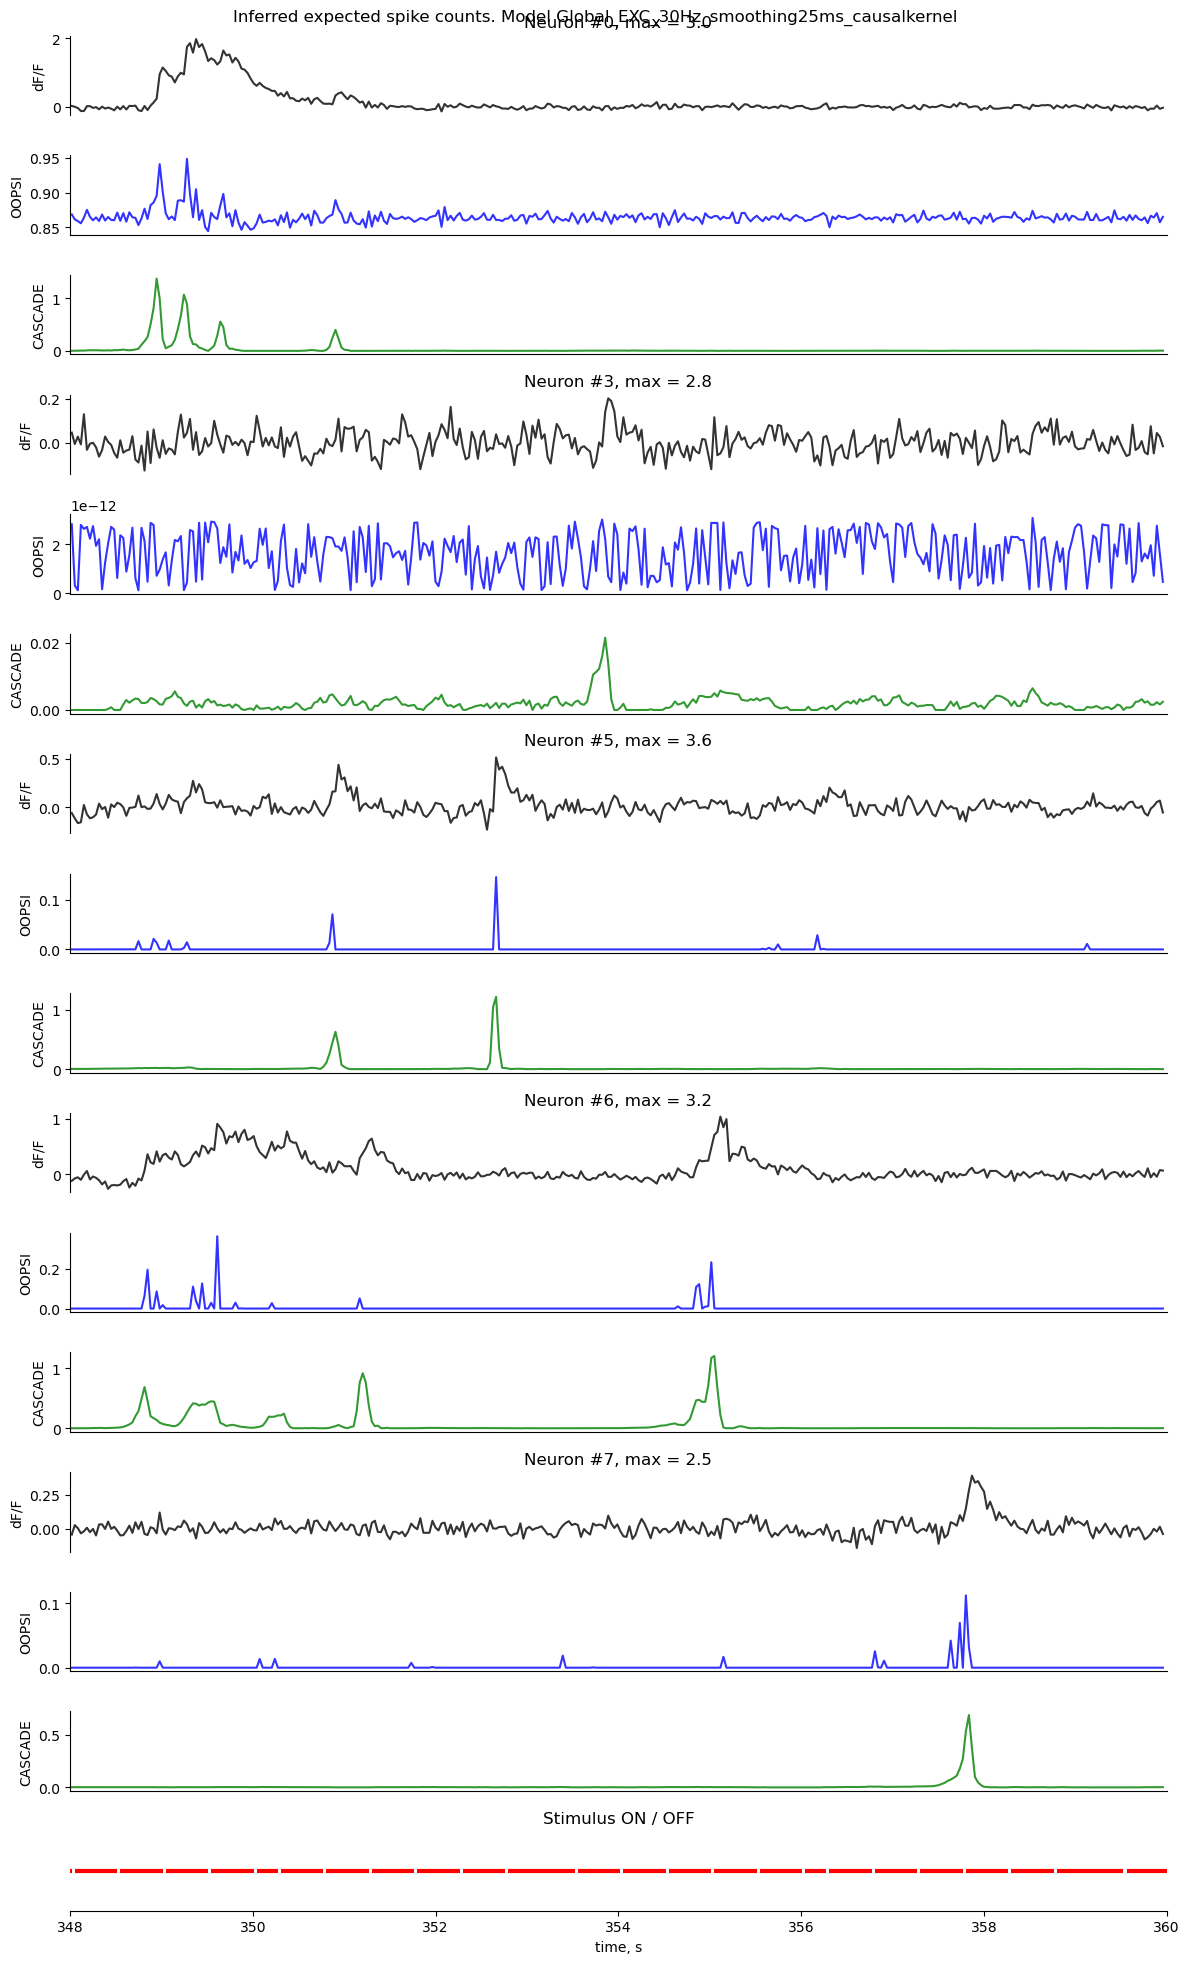

In [65]:
spikes_cascade = load_spikes(cascade_models[0])
spikes_oopsi   = load_spikes("oopsi")


delta_it = 100
it_start = 1800
it1, it2 = (it_start, it_start + delta_it)

tlim = (348, 360)
it1, it2 = find_index(times, tlim)

neurons_list = [0, 3, 5, 6, 7]
n = len(neurons_list)

fig, axes = plt.subplots(3 * n + 1, 1, figsize=(12, 4 * n))
plt.suptitle("")

for i in range(n + 1):
    
    if i < n:
        # plot calcium trace
        ax = axes[3 * i]
        neuron = neurons_list[i]  
        ax.set_title(f"Neuron #{neuron}, max = {neuron_stats['max'][neuron]:.1f}")
        ax.plot(times[it1:it2], dff[neuron, it1:it2], color='black', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("dF/F")
        
        ax.set_xticks([])
        for loc in ['top', 'right', 'bottom']:
            ax.spines[loc].set_visible(False)
        
        # plot inferred spikes (oopsi)
        ax = axes[3 * i + 1]
        
        ax.plot(times[it1:it2], spikes_oopsi[neuron, it1:it2], color='blue', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("OOPSI")
        
        ax.set_xticks([])
        for loc in ['top', 'right']:
            ax.spines[loc].set_visible(False)
            
        # plot inferred spikes (cascade)
        ax = axes[3 * i + 2]
        
        ax.plot(times[it1:it2], spikes_cascade[neuron, it1:it2], color='green', alpha=0.8, linewidth=1.5)
        ax.set_ylabel("CASCADE")
        
        ax.set_xticks([])
        for loc in ['top', 'right']:
            ax.spines[loc].set_visible(False)

    else:
        ax = axes[3 * i]
        # plotting the stimulus as horizontal lines
        stim_xpos_start = times[stim_table['start'].values]
        stim_xpos_end   = times[stim_table['end'].values]
        
        ax.set_title("Stimulus ON / OFF")
        ax.hlines(y = np.zeros(len(stim_xpos_start)), 
                  xmin = stim_xpos_start, 
                  xmax = stim_xpos_end, 
                  colors='red', 
                  linewidth=3)
        ax.set_ylim((-0.5, 0.5))
        ax.set_xlabel("time, s")
        ax.set_yticks([])
        for loc in ['top', 'right', 'left']:
            ax.spines[loc].set_visible(False)
            
            
for ax in axes:
    ax.set_xlim(tlim)
    
plt.suptitle(f"Inferred expected spike counts. Model {model_name}")
plt.tight_layout();

OOPSI output is more abrubt and gives spuriour low spike probability peaks when the signal actually consists only of noise. Thus the model of choice for spike inference is Cascade.

## Compute spike statistics

In [42]:
%%time

def get_spike_statistics(spikes, times):
    total_counts = spikes.sum(axis=1)
    neuron_stats = {}
    neuron_stats['total spikes'] = total_counts
    neuron_stats['max spike count'] = spikes.max(axis=1)
    neuron_stats['mean firing rate'] = total_counts / (times[-1] - times[0])
    neuron_stats['mean spike count'] = total_counts / n_times
    neuron_stats['spike count variability'] = spikes.std(axis=1)
    neuron_stats['fano factor'] = spikes.std(axis=1) ** 2 / (total_counts / n_times)
    return neuron_stats

spikes = load_spikes(cascade_models[0])
neuron_stats = {**neuron_stats, **get_spike_statistics(spikes, times)}


CPU times: total: 875 ms
Wall time: 870 ms


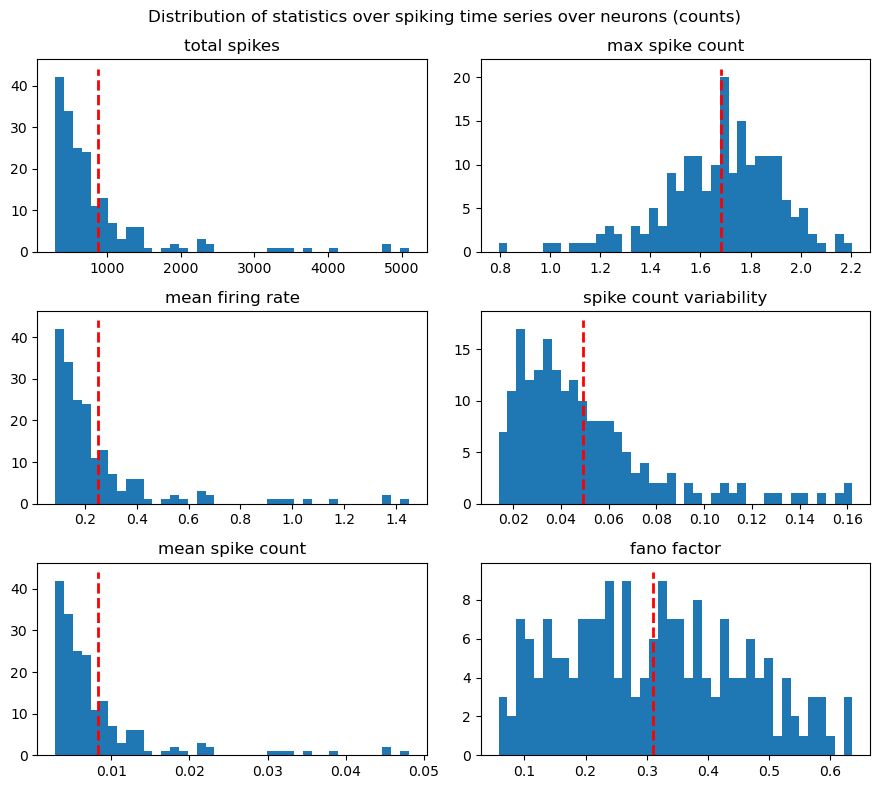

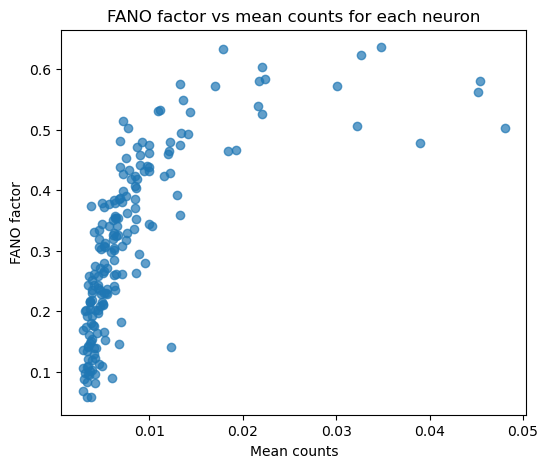

In [43]:
# visualize distributions for each statistic
stat_names = ['total spikes', 'mean firing rate', 'mean spike count', 
              'max spike count', 'spike count variability', 'fano factor']
n = len(stat_names)

nrows, ncols = int(np.ceil(n / 2)), 2
fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 3, ncols * 4))

for i in range(n):
    irow, icol = i % nrows, i // nrows
    ax = axes[irow, icol]
    
    stat_name = stat_names[i]
    ax.set_title(stat_name)
    
    values = neuron_stats[stat_name]
    mean = values.mean()
 
    ax.hist(values, bins=40)
    
    ax.vlines(mean, *ax.get_ylim(), linestyle='--', colors='red', linewidth=2)

plt.suptitle("Distribution of statistics over spiking time series over neurons (counts)")
plt.tight_layout() 
plt.show()

plt.figure(figsize=(6, 5))
plt.title("FANO factor vs mean counts for each neuron")
plt.xlabel("Mean counts")
plt.ylabel("FANO factor")

fano = neuron_stats['fano factor']
mean = neuron_stats['mean spike count']
var  = neuron_stats['spike count variability']

plt.scatter(mean, fano, alpha=0.7)
plt.show()

### Visualizing count distributions for sample neurons

Are our neurons generating spikes according to the Poisson model? Or did the spike inference algorithm manage to infer Poisson-spiking neurons? FANO factor over mean count plot suggest that Poisson firing neurons are not actually the case... Let's find it out by plotting example counts distributions for each neuron. 

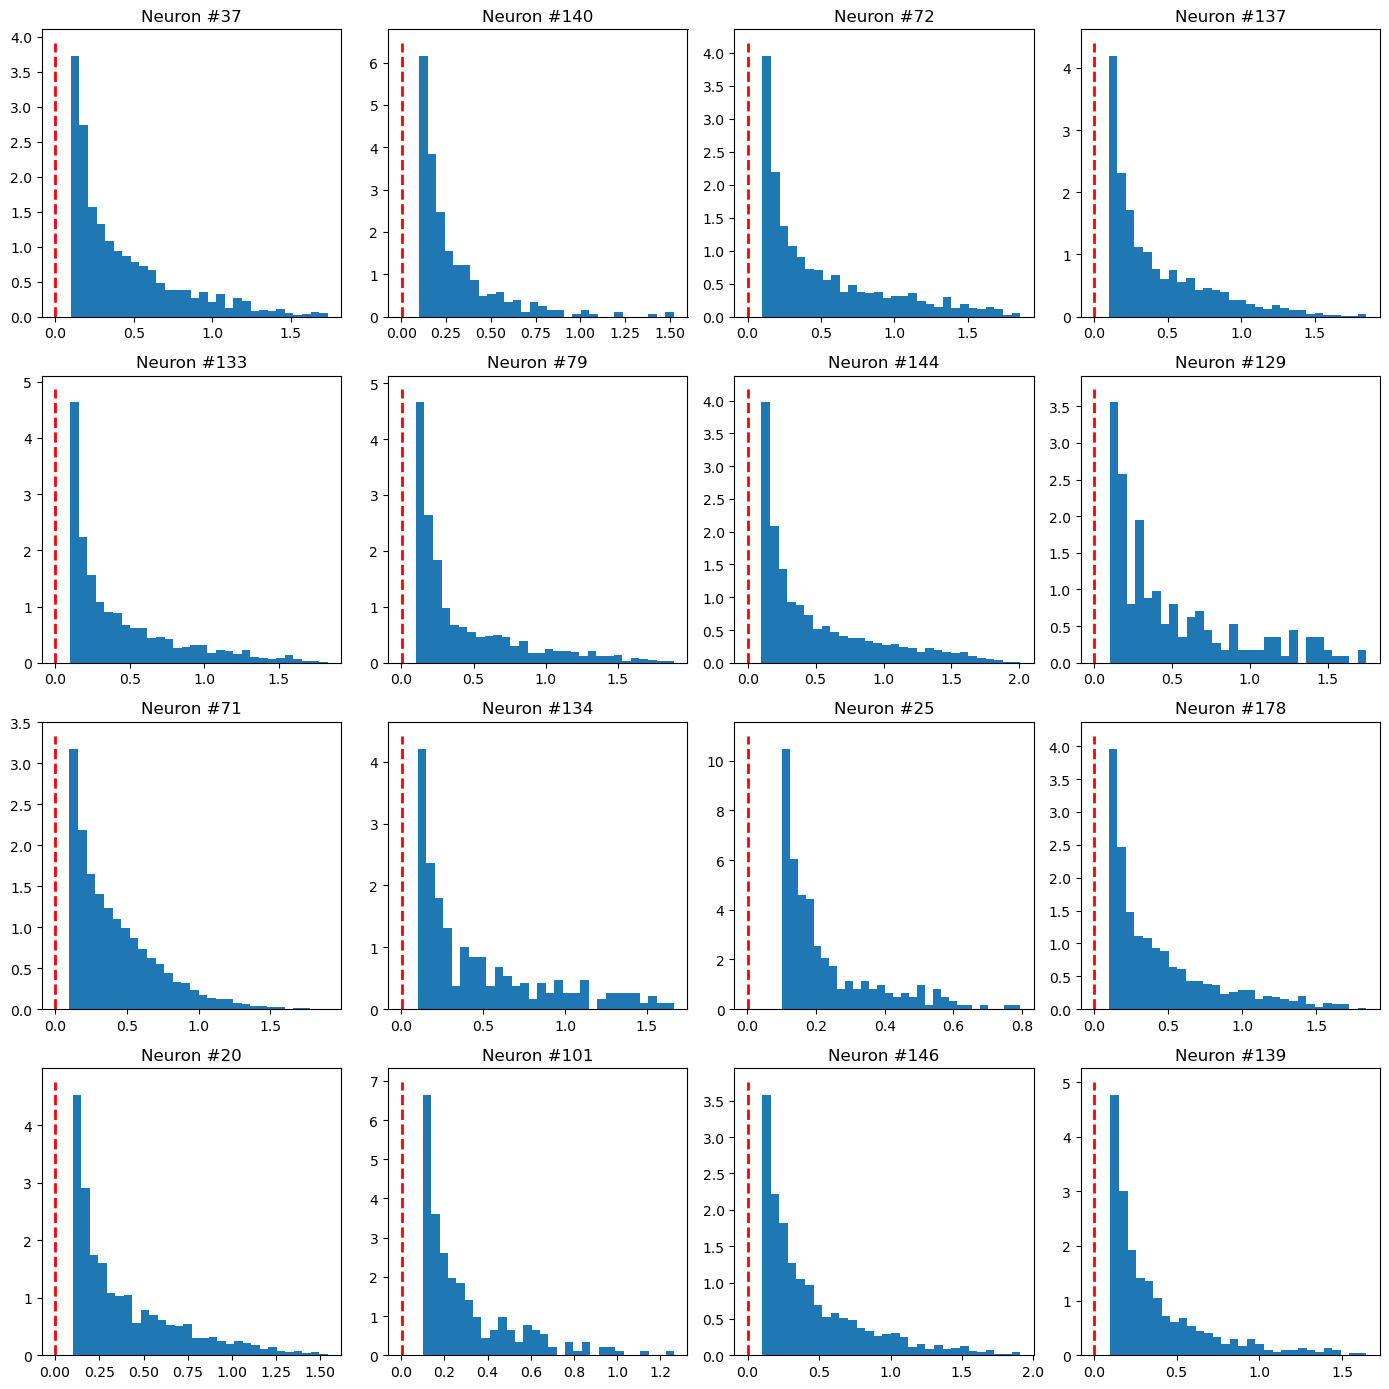

In [44]:
spikes = load_spikes(cascade_models[0])
stim_spike_data = get_stim_spike_data(spikes, stim_table)

np.random.seed(1)
threshold = 0.1
m = 4
n_random_neurons = m ** 2
neurons_list = np.random.choice(np.arange(n_neurons), size=n_random_neurons)

fig, axes = plt.subplots(m, m, figsize=(14, 14))

for neuron, ax in zip(neurons_list, axes.flatten()):
    ax.set_title(f"Neuron #{neuron}")
    ax.hist(spikes[neuron][spikes[neuron] > threshold], bins=30, density=True)
    ax.vlines(np.median(spikes[neuron]), *ax.get_ylim(), linestyle='--', colors='red', linewidth=2)
    
plt.tight_layout()

Looks more like exponential distribution. However first need to rebin spikes to align with stimulus frames and see what distribution will be with counts rebinned to 250ms windows.

### Calculating expected spike count for each stimulus presentation

In [45]:
stim_table.head()

frame  start  end   t_start     t_end
0      0    737  744  33.77772  34.00992
1      1    745  752  34.04309  34.27530
2      2    752  759  34.27530  34.50750
3      3    760  767  34.54067  34.77287
4      4    767  774  34.77287  35.00508

In [46]:
spikes = load_spikes(cascade_models[0], 'zeros')
stim_spike_data = get_stim_spike_data(spikes, stim_table)
stim_spike_data.shape

(8880, 189)

### Visualizing count distibutions for expected spike count within a stimulus timeframe

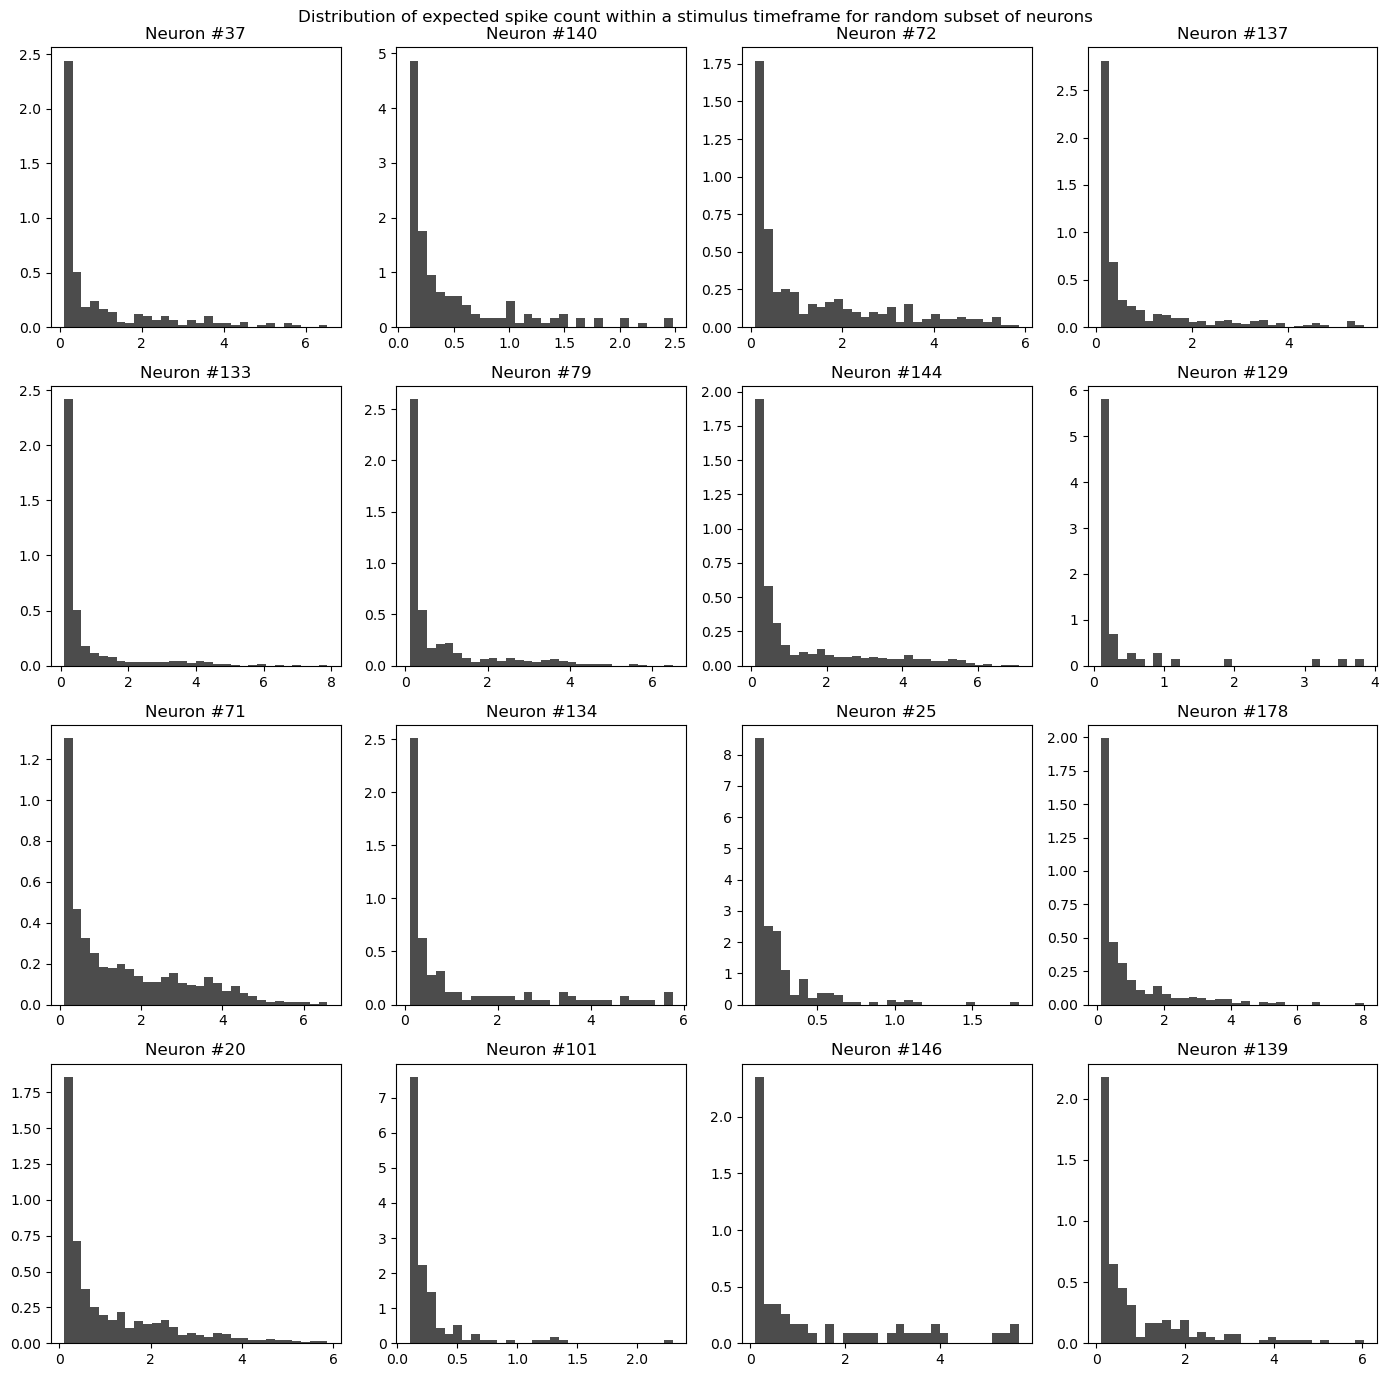

In [49]:
# now plot distributions again
# now there are n_stimuli realizations of expected spike count
# the spike count numbers should be larger because of summation within the stimulus frame

np.random.seed(1)
threshold = 0.1
m = 4
n_random_neurons = m ** 2
neurons_list = np.random.choice(np.arange(n_neurons), size=n_random_neurons)

fig, axes = plt.subplots(m, m, figsize=(14, 14))

for neuron, ax in zip(neurons_list, axes.flatten()):
    ax.set_title(f"Neuron #{neuron}")
    data = stim_spike_data[:, neuron]
    ax.hist(data[data > threshold], bins=30, density=True, alpha=0.7, color='black')
    #ax.set_xscale('log')
    #ax.vlines(np.median(spikes[neuron]), *ax.get_ylim(), linestyle='--', colors='red', linewidth=2)
plt.suptitle("Distribution of expected spike count within a stimulus timeframe for random subset of neurons")
plt.tight_layout()

#### Compare count distribution to exponential

What I want to do here is to find out which distribution do the extracted spike (expected) counts come from. It might be useful to know for generative model, i.e. maximum likelihood estimation.

Text(0, 0.5, 'Probability')

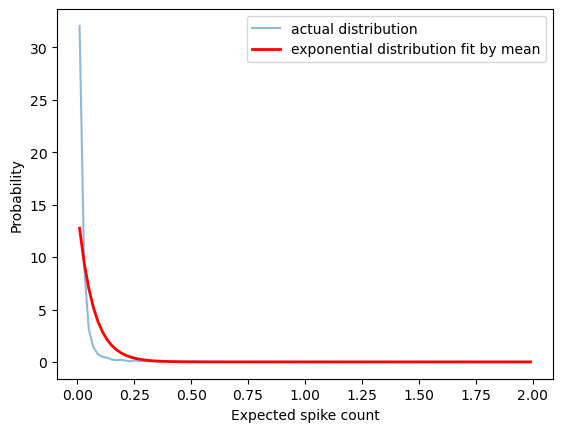

In [51]:
neuron = 133

counts, bins = np.histogram(stim_spike_data[:, neuron], bins=np.linspace(0, 2, 100), density=True)

bin_centers = bins[1:] - np.diff(bins) / 2

exp_pdf = stats.expon(scale = np.mean(stim_spike_data[:, neuron])).pdf(bin_centers)
plt.plot(bin_centers, counts, alpha=0.5, label='actual distribution'),
plt.plot(bin_centers, exp_pdf, color='red', linewidth=2, label='exponential distribution fit by mean')
plt.legend()
plt.xlabel("Expected spike count")
plt.ylabel("Probability")

Still not looking like Poisson. Well, maybe could account for it in some of toolboxes. For example by setting the prior as gamma distribution or exponential. Would be nice to confirm these conclusions though.

#### Try logscale for x - maybe lognormal? maybe gamma?

##### Adaptive thresholding - distribution for stimuli when is active enough

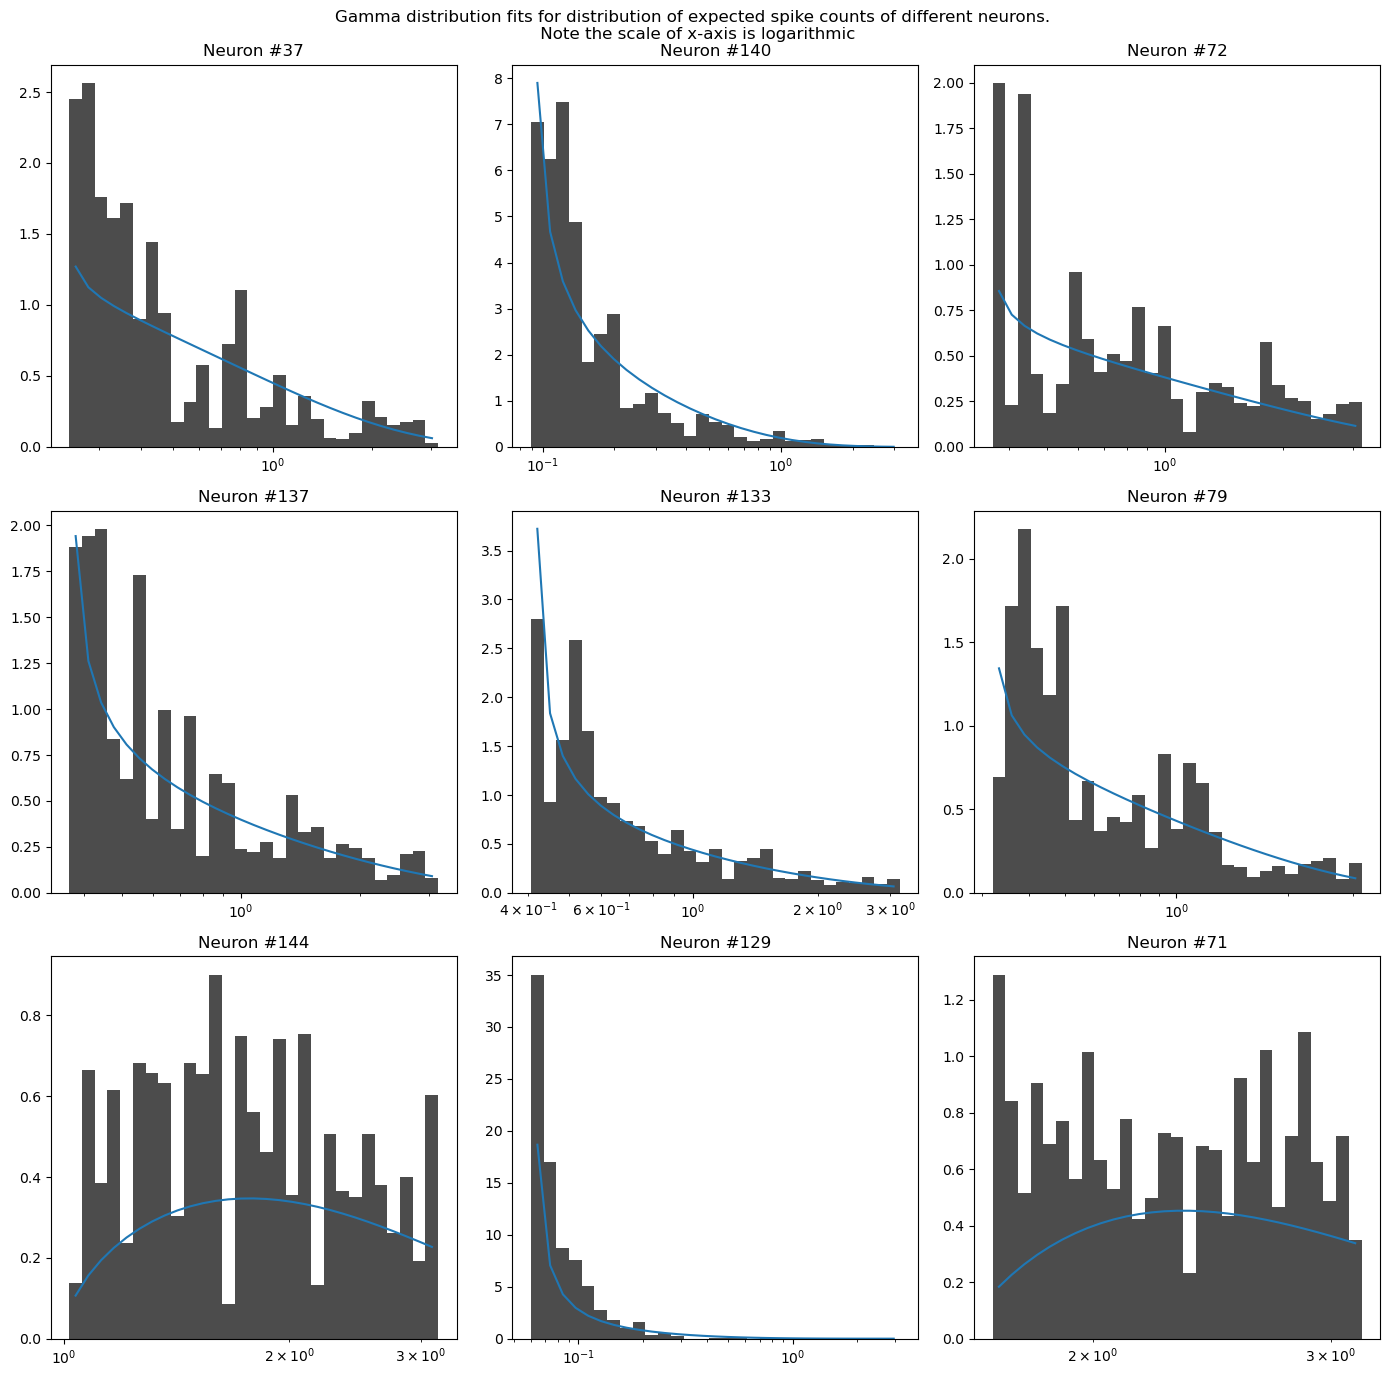

In [53]:
# distribution when the neuron is actually more activated (for most exciting stimuli)

np.random.seed(1)
threshold = 0.1
m = 3
n_random_neurons = m ** 2
neurons_list = np.random.choice(np.arange(n_neurons), size=n_random_neurons)

fig, axes = plt.subplots(m, m, figsize=(14, 14))

for neuron, ax in zip(neurons_list, axes.flatten()):
    ax.set_title(f"Neuron #{neuron}")
    threshold = 5 * est_robust_std(stim_spike_data.T, neuron) 
    bins = np.logspace(np.log10(threshold), 0.5, num=30)
    bin_centers = bins[1:] - np.diff(bins) / 2  
    data = stim_spike_data[:, neuron]
    fit_params = stats.gamma.fit(data[data > threshold])
    fitted_pdf = stats.gamma(*fit_params).pdf(bin_centers)
    #exp_pdf = stats.expon(scale = np.mean(data)).pdf(bin_centers)
    ax.plot(bin_centers, fitted_pdf)
    ax.hist(data[data > threshold], bins=bins, density=True, alpha=0.7, color='black')
    ax.set_xscale('log')
    #ax.vlines(np.median(spikes[neuron]), *ax.get_ylim(), linestyle='--', colors='red', linewidth=2)
    
plt.suptitle("Gamma distribution fits for distribution of expected spike counts of different neurons. \n Note the scale of x-axis is logarithmic")
plt.tight_layout()

Unfortunately, it might be very tricky to estimate the "spike count" distribution. It seems that inferred spike rates are not resembling Poisson, nor they are exponentials. Gamma distribution fits rarely capture the true distribution of the data and the shape of this distribution varies significantly from neuron to neuron.

# III. Receptive field (RF) estimation

## Useful tools and links for RF estimation

#### 1. Huangs toolkit RFEst

- Berens, Huang paper (2021): https://arxiv.org/abs/2108.07537
- Github repo: https://github.com/berenslab/RFEst/. 
- Notebook tutorials are found here: https://github.com/huangziwei/notebooks_RFEst

WARNING: requires **JAX**, that is compatible with python and with each other version jax and jaxlib. More about JAX and installation on windows (tricky):

> - Community version of jax install for Windows: https://github.com/cloudhan/jax-windows-builder
> - Official github: https://github.com/google/jax#installation (I still followed manual installation)
> - Windows jaxlib versions for manual install: https://whls.blob.core.windows.net/unstable/index.html
> - About versioning: https://jax.readthedocs.io/en/latest/jep/9419-jax-versioning.html
> - Also some instructions following which I succeeded: https://pypi.org/project/gpmp/


#### 2. Other papers
- Park & Pillow (2011): https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002219. Was mentioned during the lecture 5 extensively.
- Mano et al. (2019): https://www.nature.com/articles/s41467-019-12974-0#data-availability. "Estimating receptive fields using slow frame rates"

## Spike-triggered average (STA)

Since we don't have time-resolved spikes, the first approximation of RF using spike-triggered average (STA) would be to count spikes within a stimulus time frame and weight stimuli according to that. For each neuron we will thus get different weighting of stimuli (according to their expected spike count within a stimulus time). By summing stimuli up with those weights, the stimuli with higher neuron firing will be counted more and in the end we will get the linear combination of stimuli that maximally excites the neuron. 

In [566]:
# find most active neurons
spike_model_name = cascade_models[0]
spikes = load_spikes(spike_model_name, fillnan='zeros')
stim_spike_data = get_stim_spike_data(spikes, stim_table)

total_counts   = stim_spike_data.sum(axis=0) # sum over stimuli axis
neurons_sorted = np.argsort(total_counts)[::-1]
most_active    = neurons_sorted[:10]
most_active

array([ 38, 114,  43,  89,  98, 174, 163,  60,  71, 179], dtype=int64)

### Computing STA using different methods

#### 1. Vanilla STA

In [268]:
# %%time

# model_name = "STA"
# spike_model_name = cascade_models[0]
# delays = list(range(6))

# spikes = load_spikes(spike_model_name, fillnan='zeros')
# stim_spike_data = get_stim_spike_data(spikes, stim_table)

# n_stim = stim.shape[0]
# rf = np.empty((n_neurons, len(delays), *stim_shape))

# for neuron in tqdm(range(n_neurons)):
    
#     # weights are # of spikes within a stimulus timefrime
#     weights = stim_spike_data[:, neuron]
    
#     for d in delays: 
        
#         weighted_stim = np.zeros((n_stim - d, *stim_shape))
        
#         for i in range(n_stim - d):
#             weighted_stim[i] = weights[i + d] * stim[i]
#         sta = weighted_stim.sum(axis=0)

#         rf[neuron, d] = sta
        
# fname = f"rf_{model_name}_spikes-{spike_model_name}.npy"
# np.save(data_path / "rf" / fname, rf)

CPU times: total: 1min 45s
Wall time: 1min 45s


#### 2. STA but using matrix multiplication

$$ STA = X^T y$$

In [271]:
# %%time
# # Same with matrix multiplication

# model_name = "STA-matrix"
# spike_model_name = cascade_models[0]
# delays = list(range(6))

# spikes = load_spikes(spike_model_name, fillnan='zeros')
# stim_spike_data = get_stim_spike_data(spikes, stim_table)

# n_stim = stim.shape[0]
# rf = np.empty((n_neurons, len(delays), *stim_shape))

# X = stim.reshape((n_stim, -1)) # matrix of shape (num_stimuli, stim_flattened_size)

# for neuron in tqdm(range(n_neurons)):
    
#     # weights are # of spikes within a stimulus timefrime
#     y = stim_spike_data[:, [neuron]] # column vector of shape (num_stimuli, 1)
    
#     for d in delays:
#         X_delay = X[:n_stim - d]
#         y_delay = y[d:]
        
#         sta = X_delay.T @ y_delay
#         rf[neuron, d, :, :] = sta.reshape(stim_shape)
        
# fname = f"rf_{model_name}_spikes-{spike_model_name}.npy"
# np.save(data_path / "rf" / fname, rf)

CPU times: total: 36.6 s
Wall time: 31.1 s


#### 3. STA with pseudoinverse

$$ STA = (X^TX + \lambda I)^{-1}X^T y$$

$\lambda$ can be shown to work in this formula as Ridge (L2) regularization parameter, shrinking the weights.

In [28]:
# Same with matrix multiplication

# _lambda = 0.1 # L2-regularizer (to try out if it works for RFs as well)
# model_name = f"STA-pseudoinverse-regularized-lambda{_lambda:.1f}"
# spike_model_name = cascade_models[0]
# delays = list(range(6))

# spikes = load_spikes(spike_model_name, fillnan='zeros')
# stim_spike_data = get_stim_spike_data(spikes, stim_table)

# n_stim = stim.shape[0]
# rf = np.empty((n_neurons, len(delays), *stim_shape))

# X = stim.reshape((n_stim, -1)) # matrix of shape (num_stimuli, stim_flattened_size)

# # compute pseudoinverse matrix P - computationally expensive step
# P = np.linalg.inv(X.T @ X + n_stim * _lambda * np.eye(X.shape[1]))

# for neuron in tqdm(range(n_neurons)):
    
#     # weights are # of spikes within a stimulus timefrime
#     y = stim_spike_data[:, [neuron]] # column vector of shape (num_stimuli, 1)
    
#     for d in delays:
#         X_delay = X[:n_stim - d]
#         y_delay = y[d:]
        
#         sta = P @ X_delay.T @ y_delay
#         rf[neuron, d, :, :] = sta.reshape(stim_shape)
# fname = f"rf_{model_name}_spikes-{spike_model_name}.npy"
# np.save(data_path / "rf" / fname, rf)

100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [01:28<00:00,  2.14it/s]


#### 4. STA using calcium activity

Finally, for comparison it might be useful to just use mean fluorescence within the stimulus frame as a weight. Could it give better results because it uses the data directly instead of (possibly noisy) spike inference results?

In [12]:
# rf_model_name = "STA-calcium"
# spike_model_name = cascade_models[0]

# delays = list(range(6))

# stim_dff_data = get_stim_dff_data(dff, stim_table, threshold_multiplier=10)

# n_stim = stim.shape[0]
# rf = np.empty((n_neurons, len(delays), *stim_shape))

# X = stim.reshape((n_stim, -1)) # matrix of shape (num_stimuli, stim_flattened_size)

# for neuron in tqdm(range(n_neurons)):
    
#     # weights are # of spikes within a stimulus timefrime
#     y = stim_dff_data[:, [neuron]] # column vector of shape (num_stimuli, 1)
    
#     for d in delays:
#         X_delay = X[:n_stim - d]
#         y_delay = y[d:]
        
#         sta = X_delay.T @ y_delay
#         rf[neuron, d, :, :] = sta.reshape(stim_shape)
        
# fname = f"rf_{rf_model_name}_spikes-{spike_model_name}.npy"
# np.save(data_path / "rf" / fname, rf)

100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:30<00:00,  6.12it/s]


### Load and compare STA receptive fields

Neuron #38


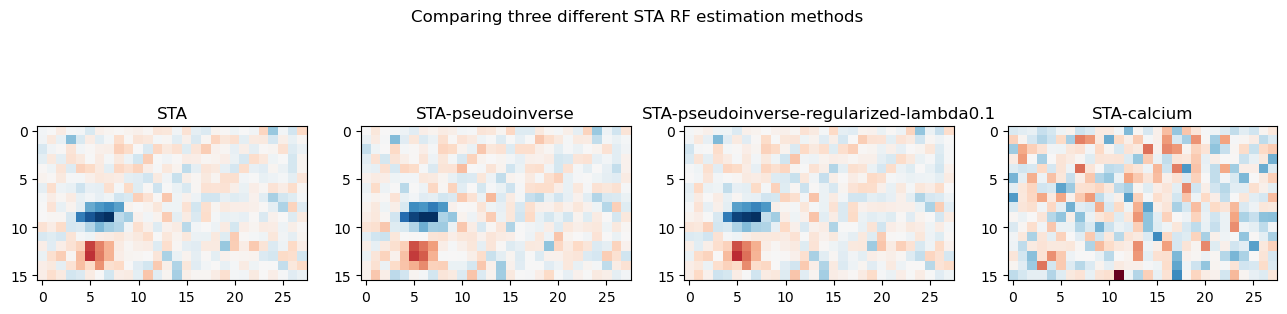

Neuron #114


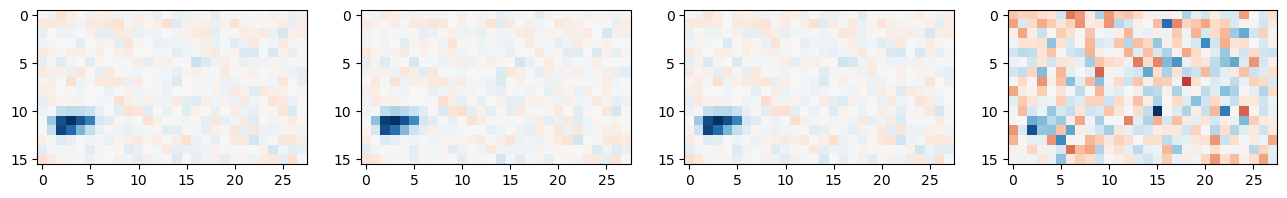

Neuron #43


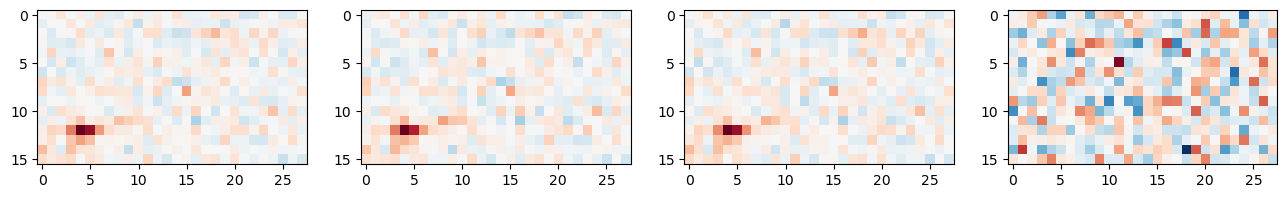

Neuron #89


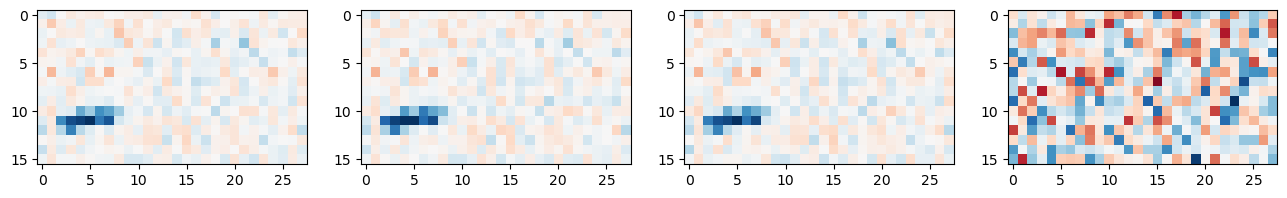

Neuron #98


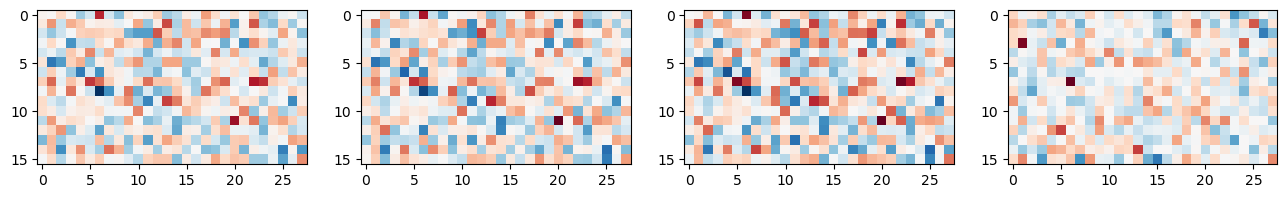

Neuron #174


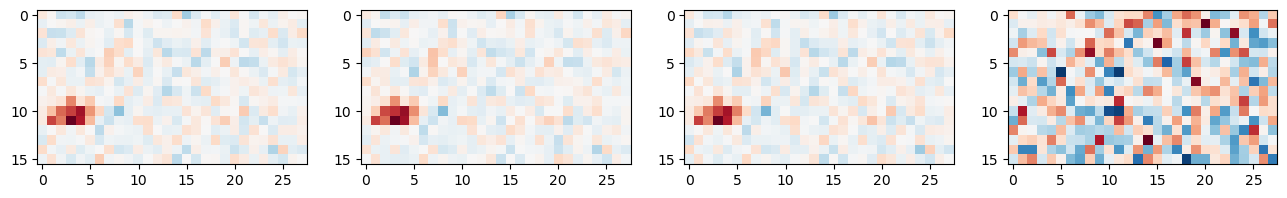

Neuron #163


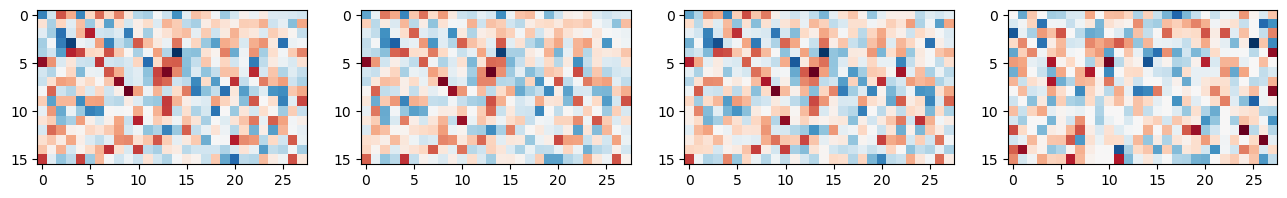

Neuron #60


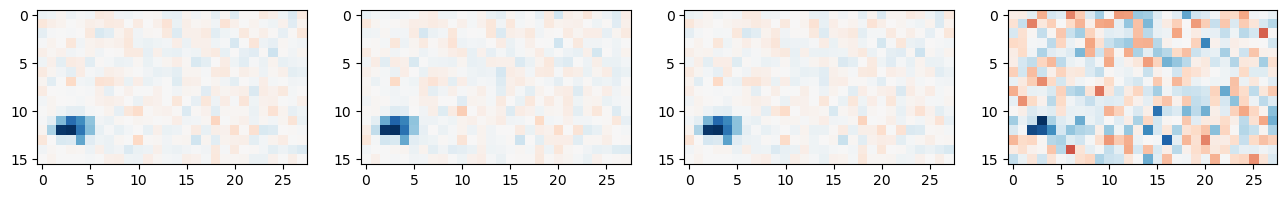

Neuron #71


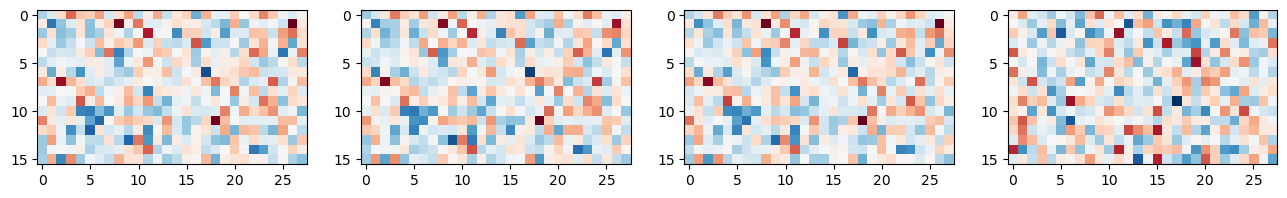

Neuron #179


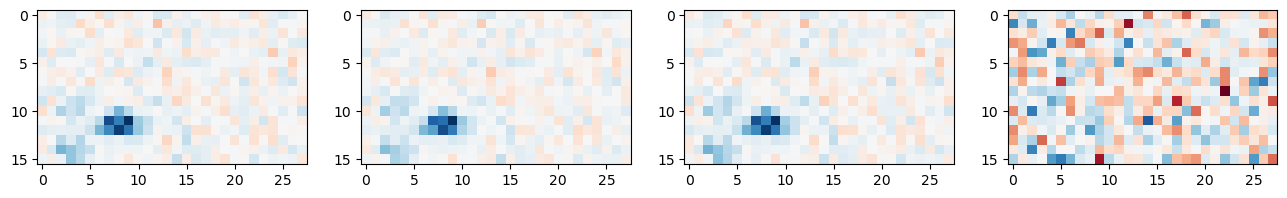

In [29]:
delay = 0
spike_model_name = cascade_models[0]
_lambda = 0.1

rf_models = ["STA", "STA-pseudoinverse", f"STA-pseudoinverse-regularized-lambda{_lambda:.1f}", "STA-calcium"]
rf = {}
for rf_model in rf_models:
    fname = f"rf_{rf_model}_spikes-{spike_model_name}.npy"
    fpath = data_path / "rf" / fname
    rf[rf_model] = np.load(fpath)


for neuron in neurons_sorted[:10]:
    print(f"Neuron #{neuron}")
    fig, axes = plt.subplots(1, len(rf_models), figsize=(4 * len(rf_models), 4))
    
    for j in range(len(rf_models)):
        ax = axes[j]
        if neuron == neurons_sorted[0]: 
            plt.suptitle("Comparing different STA RF estimation methods")
            ax.set_title(rf_models[j])     
        rf_arr = rf[rf_models[j]]
        w = rf_arr[neuron, delay]
        max_val = np.max(np.abs(w))
        ax.imshow(rf_arr[neuron, delay], cmap='RdBu_r', vmin=-max_val, vmax=max_val)
        
    plt.show()

**Observations**

It seems that all spike-based STA methods give very similar results. Pseudoinverse version might be a little bit less noise, but that's not a significant difference. Calcium-based STA on the other hand is completely useless due to the overwhelming amount of noise. It still can be used to infer some of the properties of receptive fields of especially well-tuned neurons but overall it is preferred to use inferred spike rates. It is very possible that this is due to the fact that stimuli are short lasting and highly decorrelated between consequtive time steps due to sparsness. Calcium traces on the other hand are longer lasting and propagate information in the following time frames of stimuli, contaminating the estimates with irrelevant activity. 

## Model-driven RF inference: RFEst LNLN

In order to run the RF inference using RFEst library it is needed to install dependencies in a separate environment. I recommend not doing that but instead just look at the supplementary ipynb used for the inference of Receptive Fields using non-linear multi-subunit spline methods implemented by Huang & Berens (2019).

This library was difficult to tame, but somehow the receptive fields got estimated.
The comparison (see supplementary figures "img/rf/LNLN/sta-mle-spl-subunitsum-smoothing-none.zip") yielded that subunit sum $w_{opt}$ of LNLN model gives the least noisy estimate of the receptive field.

RFs were always compared to the STA inferred ones as it is the only quality check apart from cross-validation (due to sparsity of the stimulus we would need much more data to actually conduct that), which can be conducted. 

The reasoning is the following - if advanced method doesn't give similar receptive fields with best STAs for strongly active neurons - there is something wrong in the settings or inputs to the algorithm.

### Get RF descriptive statistics

In [55]:
def get_spike_statistics(spikes, times):
    total_counts = spikes.sum(axis=1)
    neuron_stats = {}
    neuron_stats['total spikes'] = total_counts
    neuron_stats['max spike count'] = spikes.max(axis=1)
    neuron_stats['mean firing rate'] = total_counts / (times[-1] - times[0])
    neuron_stats['mean spike count'] = total_counts / n_times
    neuron_stats['spike count variability'] = spikes.std(axis=1)
    neuron_stats['fano factor'] = spikes.std(axis=1) ** 2 / (total_counts / n_times)
    return neuron_stats

def load_rf(rf_model, spikes_model, data_path=data_path):
    rf_path = data_path / "rf"
    fname = f"rf_{rf_model}_spikes-{spikes_model}.npy"
    rf = np.load(rf_path / fname)
    return rf

rf_model = "LNLN-w_best"

rf = load_rf(rf_model, cascade_models[0])
rf_flat = rf.reshape((n_neurons, -1))

spikes = load_spikes(cascade_models[0])
spikes_stats = get_spike_statistics(spikes, times)
neuron_stats = {**neuron_stats, **spikes_stats}

The descriptive statistics for RFs might include:
- Maximal value
- Minimal value
- Standard deviation (~noise of the estimate)
- Mean
- Maximal response amplitude (absmax) - independent of the sign of the response
- Difference between min and max values
- Extreme value - the largest value (signed)
- ...


In [56]:
neuron_stats['rf_max'] = rf_flat.max(axis=-1)
neuron_stats['rf_min'] = rf_flat.min(axis=-1)
neuron_stats['rf_std'] = rf_flat.std(axis=-1)
neuron_stats['rf_mean'] = rf_flat.mean(axis=-1)
neuron_stats['rf_absmax'] = np.abs(rf_flat).max(axis=-1)
neuron_stats['rf_absdiff'] = np.abs(rf_flat.max(axis=-1) - rf_flat.min(axis=-1))
neuron_stats['rf_extreme_value'] = [rf_flat[neuron, np.argmax(np.abs(rf_flat[neuron]))] for neuron in range(n_neurons)]

In [57]:
rf_stat_names = ["rf_max", "rf_min", "rf_std", "rf_mean", "rf_absmax", "rf_absdiff"]

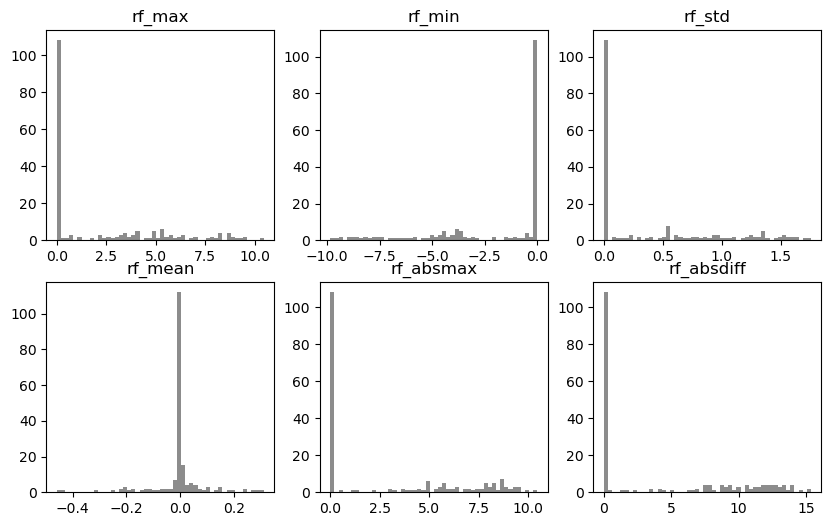

In [59]:
nrows, ncols = 2, 3

fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 5, ncols * 2))

for i, ax in enumerate(axes.flatten()):
    stat_name = rf_stat_names[i] 
    y = neuron_stats[stat_name]
    ax.hist(y, bins=50, color='gray', alpha=0.9)
    ax.set_title(stat_name)

It can be seen that there are a lot of noisy receptive fields. They have mean, max and min close to 0, while also having small std. For analysis purposes it is practical to exclude those RFs based on the arbitrary threshold. 

In the following code threshold will be defined as $$ max|RF(x, y)| \le 10^{-1}$$ as it seems to normalize the distributions of descriptive statistics of receptive fields. Heavy peaks in the histograms are thus gone:

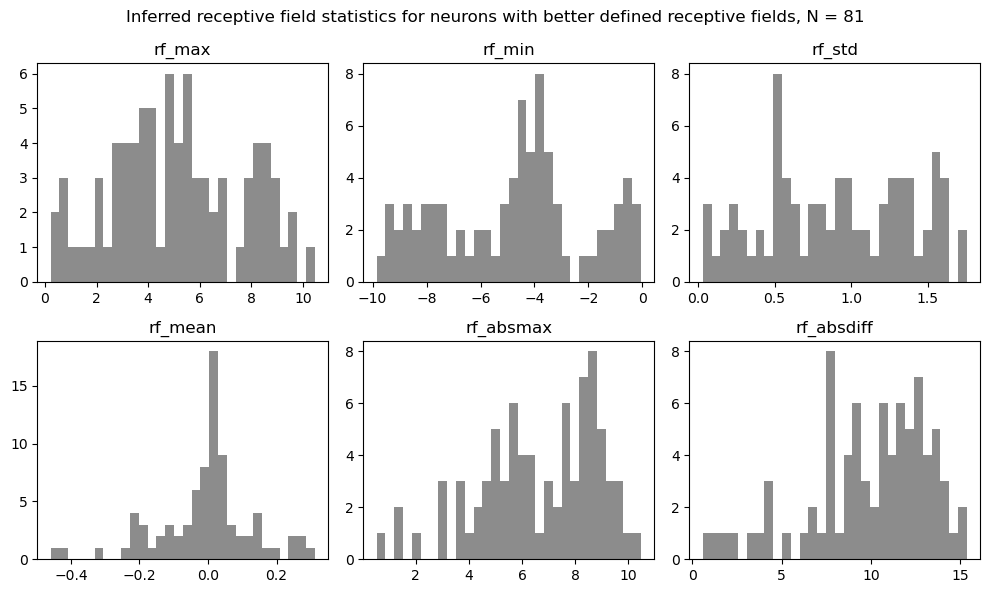

In [62]:
fig, axes = plt.subplots(nrows, ncols, figsize=(nrows * 5, ncols * 2))

nonbullshit = neuron_stats["rf_absmax"] >= 1e-1
for i, ax in enumerate(axes.flatten()):
    stat_name = rf_stat_names[i] 
    y = neuron_stats[stat_name][nonbullshit]
    ax.hist(y, bins=30, color='gray', alpha=0.9)
    ax.set_title(stat_name)
    
plt.suptitle(f"Inferred receptive field statistics for neurons with better defined receptive fields, N = {np.sum(nonbullshit)}")
plt.tight_layout()

### Correlation with spike statistics

It would be interesting to see whether spiking activity itself affects how strong or how noisy would be the receptive field.

##### All RFs

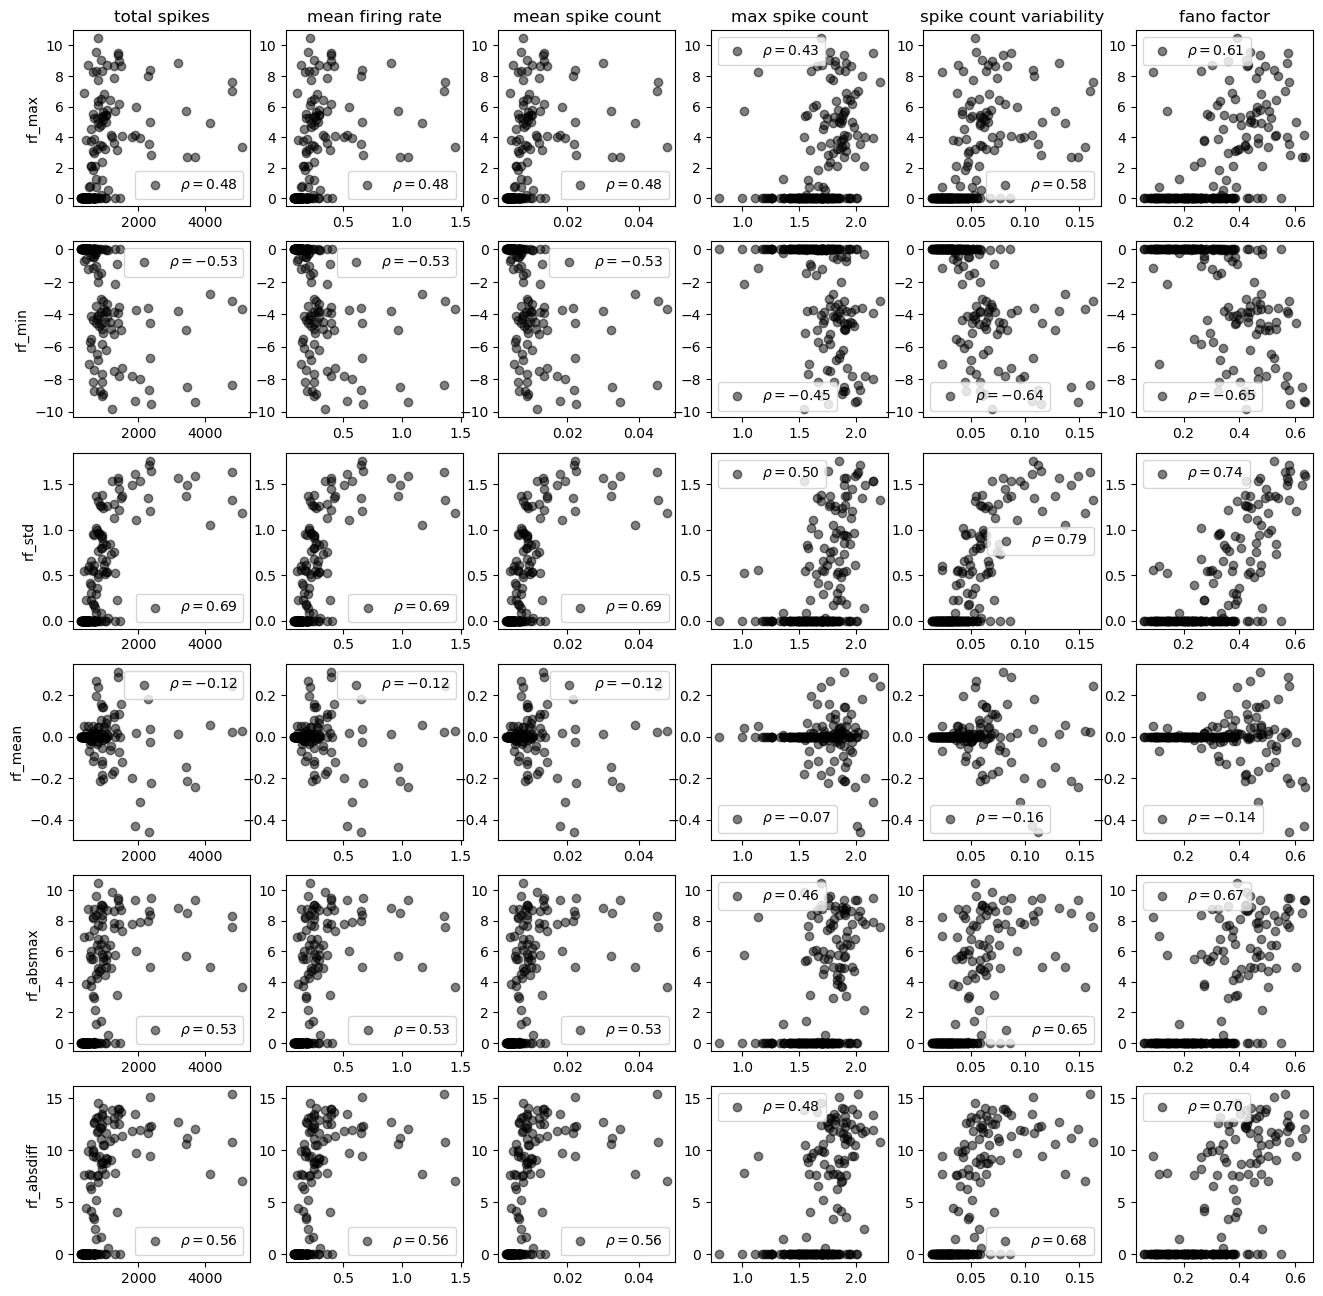

In [64]:
spikes_stat_names = ['total spikes', 'mean firing rate', 'mean spike count', 
              'max spike count', 'spike count variability', 'fano factor']

nrows, ncols = len(rf_stat_names), len(spikes_stat_names)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))


corr_raw = np.zeros((nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        x = neuron_stats[spikes_stat_names[j]]
        y = neuron_stats[rf_stat_names[i]]
        rho, _ = stats.pearsonr(x, y)
        corr_raw[i, j] = rho
        labelstr = f"$\\rho={{{rho:.2f}}}$"
        ax.scatter(x, y, alpha=0.5, color='black', label=labelstr)
        ax.legend()
        if i == 0:
            ax.set_title(spikes_stat_names[j])
        if j == 0:
            ax.set_ylabel(rf_stat_names[i])
            

##### Low-amplitude RFs excluded

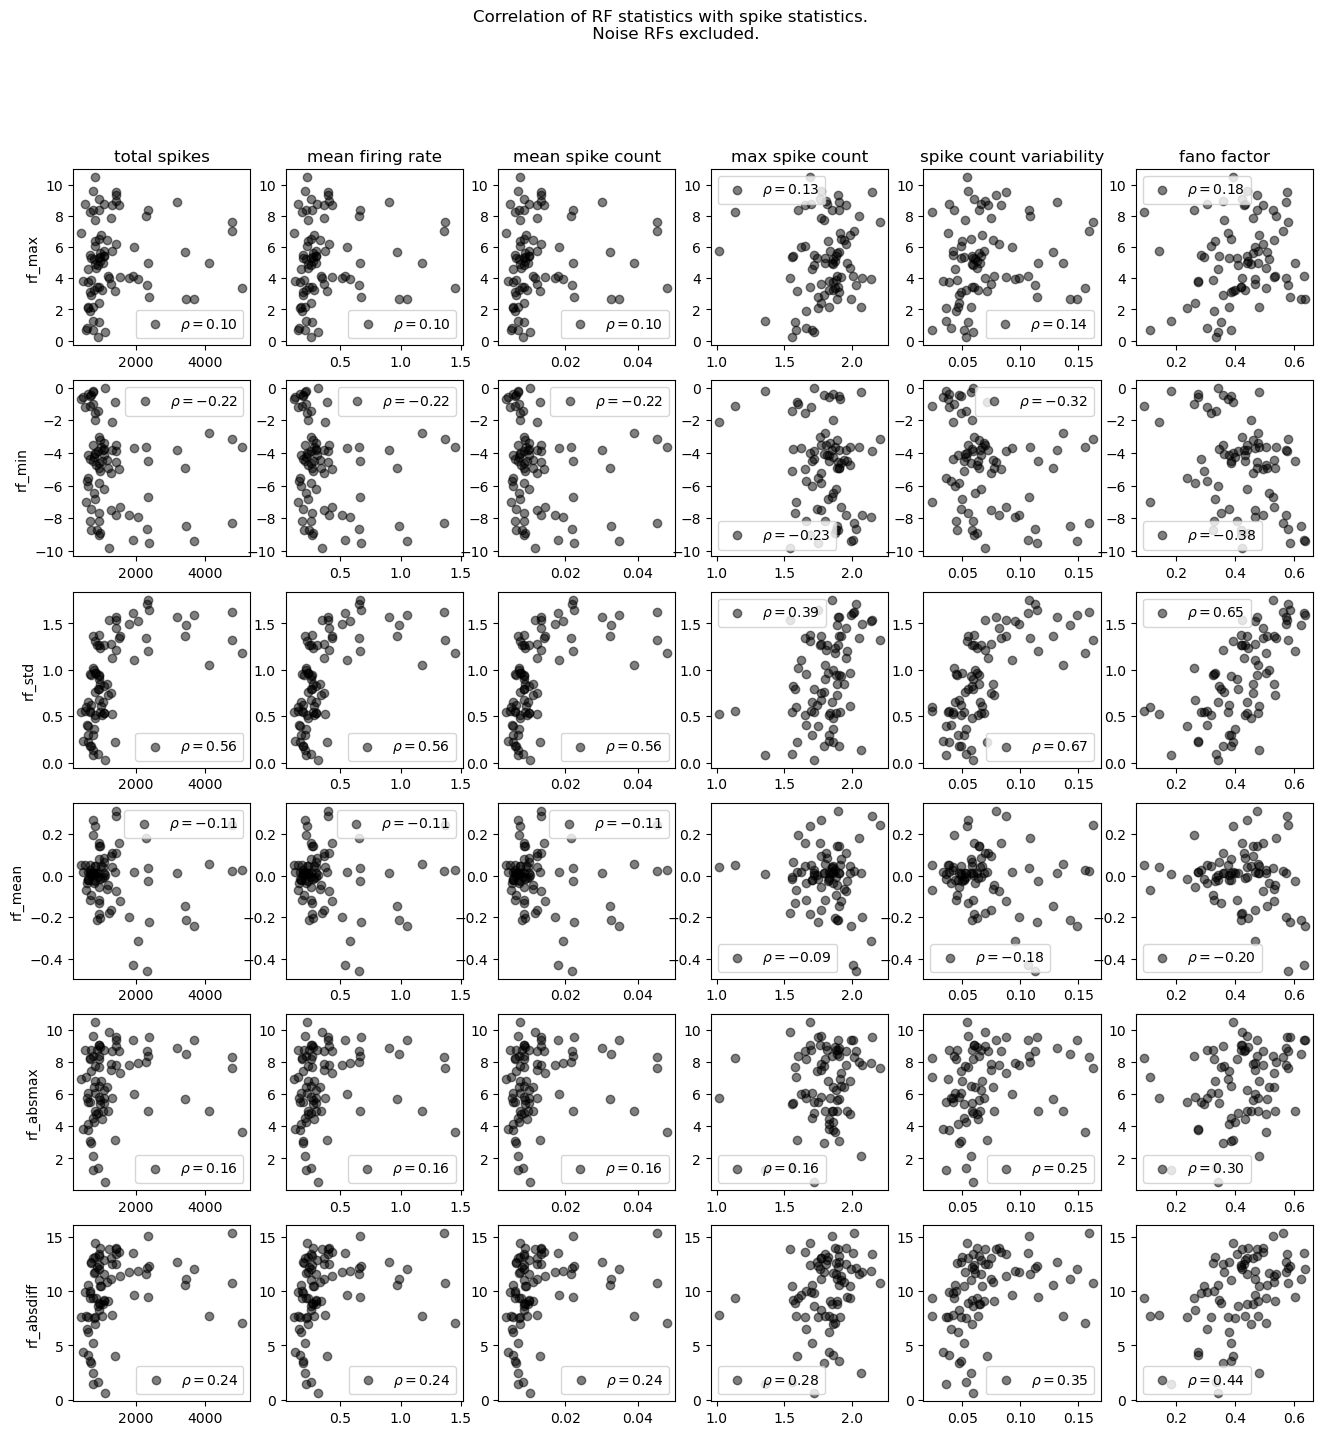

In [66]:
nrows, ncols = len(rf_stat_names), len(spikes_stat_names)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))

plt.suptitle("Correlation of RF statistics with spike statistics. \n Noise RFs excluded.")
corr_good = np.zeros((nrows, ncols))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        x = neuron_stats[spikes_stat_names[j]][nonbullshit]
        y = neuron_stats[rf_stat_names[i]][nonbullshit]
        rho, _ = stats.pearsonr(x, y)
        corr_good[i, j] = rho
        labelstr = f"$\\rho={{{rho:.2f}}}$"
        ax.scatter(x, y, alpha=0.5, color='black', label=labelstr)
        ax.legend()
        if i == 0:
            ax.set_title(spikes_stat_names[j])
        if j == 0:
            ax.set_ylabel(rf_stat_names[i])


##### Comparing RF and spike stats correlations with and without low-amplitude RF exclusion

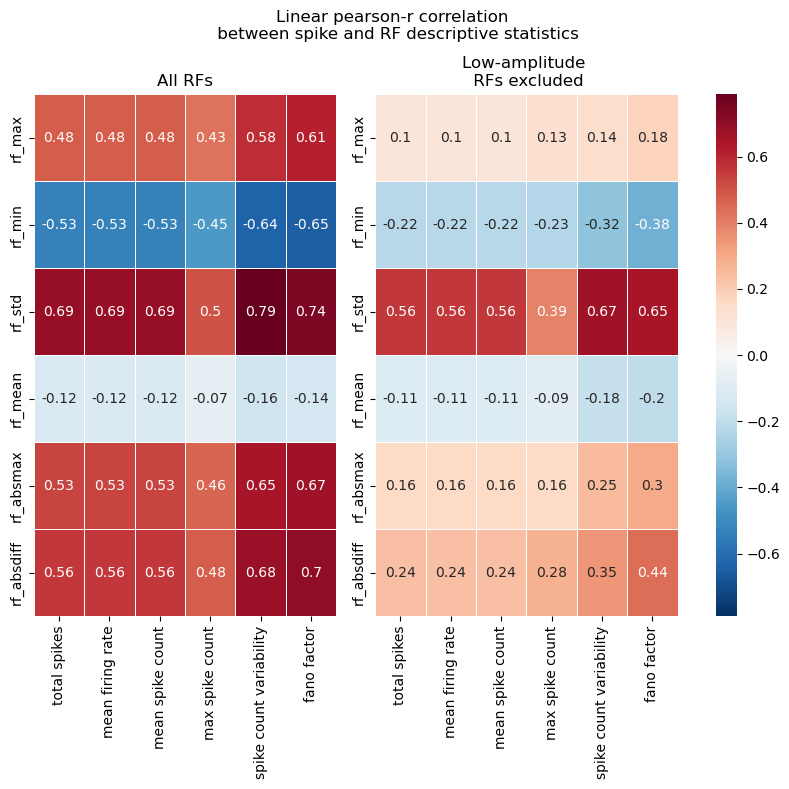

In [92]:
df_corr_raw = pd.DataFrame(corr_raw, columns=spikes_stat_names, index=rf_stat_names)
df_corr_good = pd.DataFrame(corr_good, columns=spikes_stat_names, index=rf_stat_names)

fig, axes = plt.subplots(1, 3, figsize=(8, 8), gridspec_kw={'width_ratios': [3, 3, 0.2]})

vmax = np.maximum(np.max(np.abs(corr_good)), np.max(np.abs(corr_raw))) 
ax = axes[0]
ax.set_title("All RFs")

sns.heatmap(df_corr_raw.round(2), 
            ax=ax, annot=True, cmap='RdBu_r', 
            vmin=-vmax, vmax=vmax, cbar=False, 
            linewidths=0.5, square=False)

ax = axes[1]
ax.set_title("Low-amplitude \n RFs excluded")
sns.heatmap(df_corr_good.round(2), 
            annot=True, ax=ax, cmap='RdBu_r', 
            vmin=-vmax, vmax=vmax, cbar_ax=axes[2], 
            linewidths=0.5, square=False)

plt.suptitle("Linear pearson-r correlation \n between spike and RF descriptive statistics")
plt.tight_layout()

**Observations**

"Unfiltered" RFs:
- Variance correlates highly with spike count variability
- Less strong correlation with firing rate proxies (max, mean, total)
- Weak correlation of mean RF values with any spiking parameters - that's actually good, that means that RF estimation is unbiased with regards to spike counts.
- Deviations (max, min) correlate significantly though

Exlcuded RFs
- All correlations are reduced! That means that for "good" RFs the estimate is even better, because spiking rate parameters which are estimated independent of a stimulus do not affect RF estimation strongly. 

### Visualize "good" receptive fields

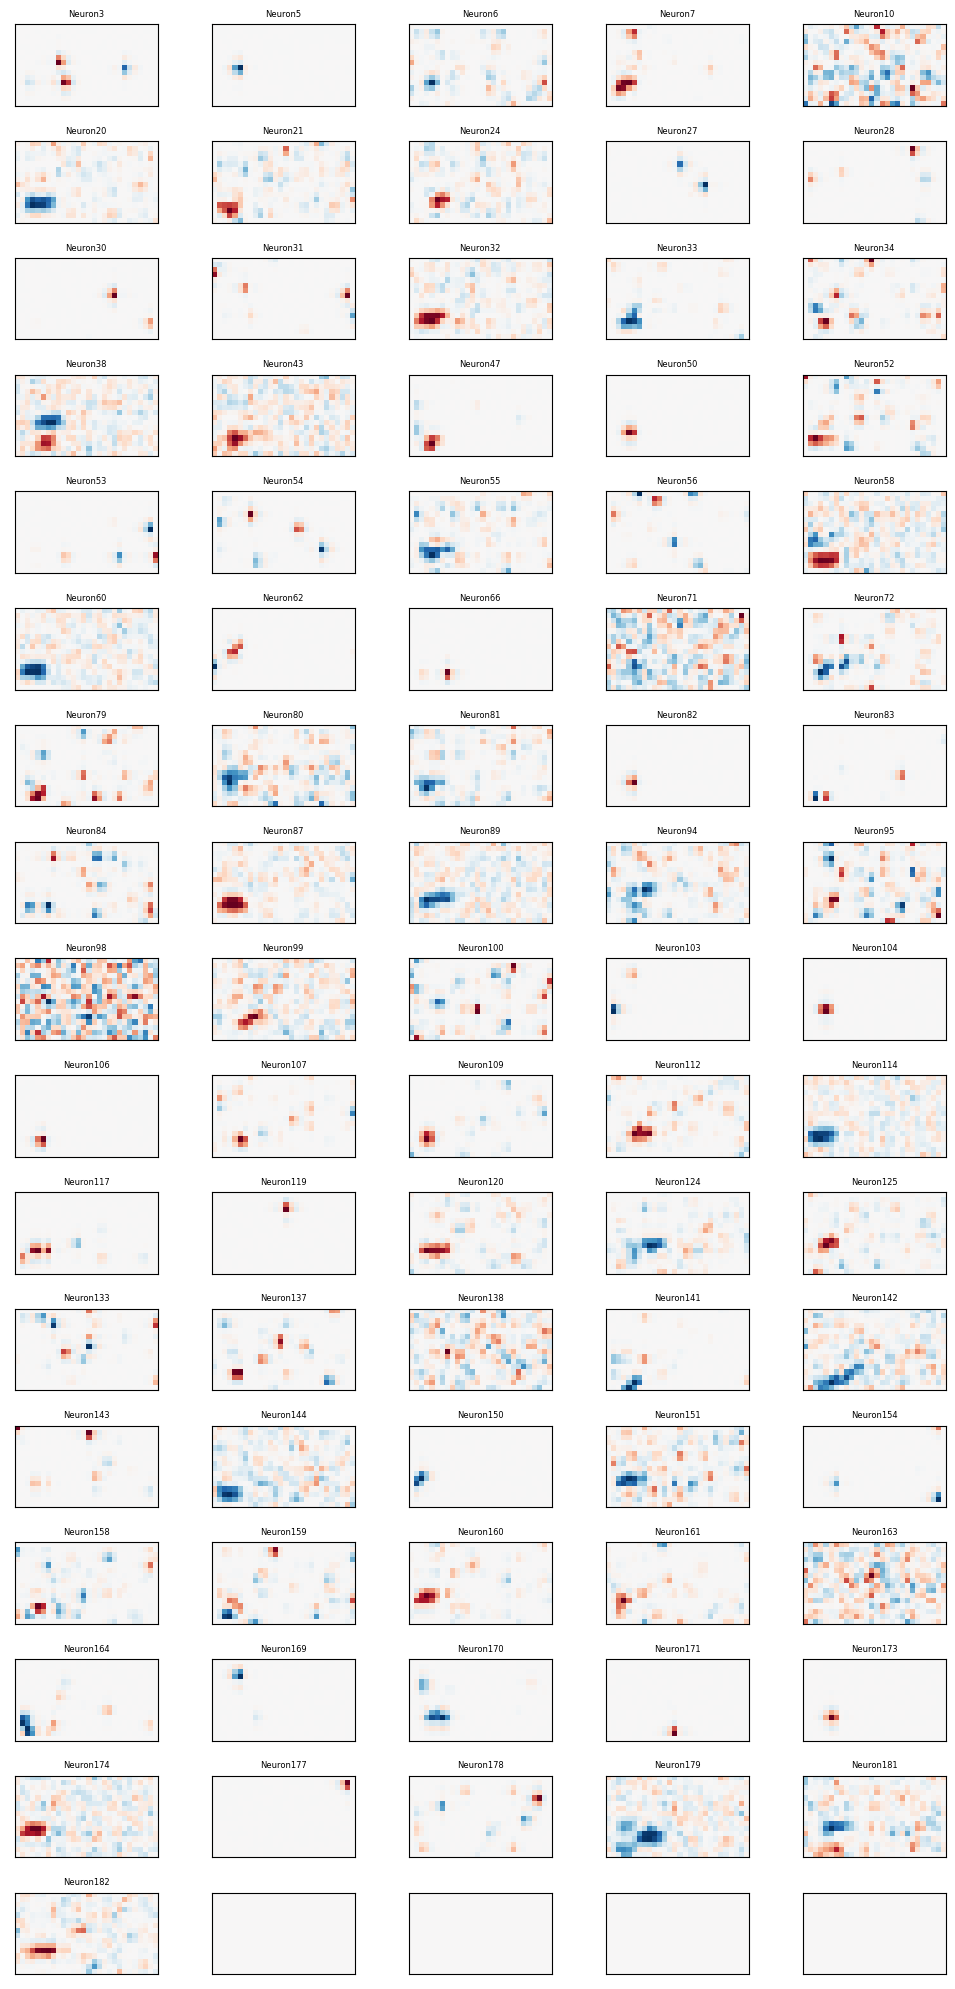

In [94]:
nrows, ncols = 17, 5
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 20))

for i, ax in enumerate(axes.flatten()):
    try:
        neuron = np.arange(n_neurons)[nonbullshit][i]
        w = rf[neuron]
        max_val = np.max(np.abs(w))
        ax.imshow(w, cmap='RdBu_r', vmin=-max_val, vmax=max_val)
        ax.set_title(f"Neuron{neuron}", fontdict={'fontsize': 6})
    except:
        ax.imshow(np.zeros_like(w), cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    
img_path = Path("../img/")
plt.tight_layout()
plt.savefig(img_path / "rf"/"rfs_w_best_good.png", dpi=200, bbox_inches="tight")
#plt.tight_layout()

### RF visual inspection - observations

- There are "inhibitory" (-, negative) and "excitatory" (+, positive) RFs. That means that neuron's response is elicited either by small (-1) or big (+1) stimulus values.
- Most RFs are unimodal - they exert a single "blob" of altered neuron activity. 
- Some RFs are bimodal and exert + activity in one stimulus spatial location and - activity in the other. These are usually adjacent though.
- Still quite a lot of nonsensical RF - scattered, unlocalized. Will try to deal with tehm in the future.
- Most of RFs are horizontal - i.e. responding to a horizontal bar.
- The most frequent location - bottom left corner. Will be analyzed further.
- The location varies but insignificantly - will be explored further.
- Overall the RFs are rather stereotypical and do not exert a lot of diversity in their spatial location relative to the stimulus frame.

# IV. Clustering receptive fields

In order to explore regularities in the diversity of inferred receptive fields it is reasonable to use clustering algorithms. This will allow to infer groups of neurons with RFs sharing some characteristics. Later, these groups of neurons can be visualized using their ROI mask to see, how these groups are spatially distributed within a cortical patch.

### Functions to visualize clustering results

In [246]:
def get_discrete_colors(n_colors, display=False):
    """
    Gets discrete colors for e.g. different labels in the clusters
    Accepts maximum number of 20 n_colors
    """
    assert n_colors < 21, "Maximal number of colors is 20!"
    
    # get colors from a nice cmap
    colors = mpl.colormaps['tab20b'].colors
    
    # change the ordering of colors to a nice one
    colors = np.array(colors).reshape(5, 4, 3)
    colors = np.swapaxes(colors, 0, 1)
    colors = colors.reshape((20, 3))
    
    # brighter colors first and then darker ugly ones
    colors = np.concatenate((colors[5:], colors[:5]), axis=0)
    colors = colors[:int(n_colors)]
    if display:
        plt.imshow(colors.reshape((1, n_colors, 3)))
    return colors


def get_continuous_colors(values, cmap, zero_centered=True, shrink_factor=0.5, shift=0.4, display=False):
    """
    Gets a gradient color for each of the value in values.
    Rescales the values from from (0.05 to 0.95) or from ()
    Recommended cmaps: 
        - from 0 to max: "Reds", "Blues", "Greens", "Purples"
        - from -min to -max: "bwr", "RdBu_r"
    """
    cmap_func = mpl.colormaps[cmap]      
    # handle the case from 0 to 1 colormaps
    if zero_centered:
        # Zero should always be mapped to 1/2 in the normalized array
        max_absval = np.max(np.abs(values))  
        values_normalized = values / (2 * max_absval) * shrink_factor + 0.5     
    else:
        max_val = np.max(values)
        min_val = np.min(values)
        # ensure values fall within (0.05, 0.95 interval) if shrink_factor = 0.9
        values = (values - min_val) / (max_val - min_val)
        values_normalized = shrink_factor * values + shift

    colors = np.array([cmap_func(v)[:3] for v in values_normalized]) # get RGB 3 values, not 4
    if display:
        plt.imshow(colors.reshape(1, len(values), 3))
        plt.show()
    return colors

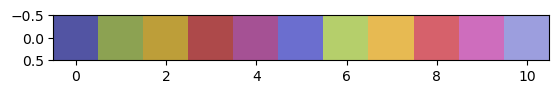

In [108]:
colors = get_discrete_colors(11, True)

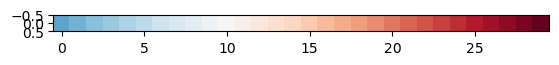

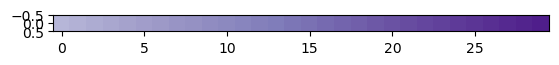

In [109]:
vals = np.arange(-10, 20)
colors = get_continuous_colors(vals, cmap='RdBu_r', zero_centered=True, display=True)
colors = get_continuous_colors(vals, cmap='Purples', zero_centered=False, display=True)

In [146]:
def visualize_clustering(data, labels, title, perplexity=10, early_exaggeration=20):
    # Visualizing labels
    cmap = plt.get_cmap('Paired') # use the Paired colormap
    
    # This section of code puts the corresponding legend for each cluster
    handles = []
    # Loop through each cluster
    for i in np.unique(labels):
        # Create a patch object with the color and label of the cluster
        patch = mpl.patches.Patch(color=cmap((i+1)/(max(labels+1))), label=f'Cluster {i+1}')
        # Append the patch object to the handles list
        handles.append(patch)

    # Visualize the clusters using PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)
    
    plt.figure(figsize=(12,4))
    # Create subplot 1
    plt.subplot(1, 2, 1) 
    plt.scatter(data_pca[:,0], data_pca[:,1], c=cmap((labels+1)/(max(labels+1))))
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA')
    
    # Visualize the clusters using t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration)
    data_tsne = tsne.fit_transform(data)
   
    # Create subplot 2
    plt.subplot(1, 2, 2)
    plt.scatter(data_tsne[:,0], data_tsne[:,1], c=cmap((labels+1)/(max(labels+1))))
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 0.5), loc='center left')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.title('t-SNE')
    
    # Add suptitle
    plt.suptitle(title)
    
    plt.tight_layout()

    # Looking at the distribution of labels
    
    a,b = np.unique(labels, return_counts=True)
    count_list = {}
    for i, (label, count) in enumerate(zip(a,b)):
        count_list[i+1] = {count}
        
    print('Counts for each label [label: {count}]:',count_list) 

In [201]:
def plot_clusters_roi(roi, labels, colors=None, names=None, ax=None, titlestr=None, legend=True, show=True):
    """
    Plots ROI of neurons colored by a cluster, inferred by the receptive field.
    Input:
        roi: np.array (n_neurons, xdim, ydim)
            roi masks of neurons relative to the scanning frame in the brain
        labels: np.array
            array of ints. roi(labels == -1) will not be displayed
            if plotting only one type of neurons use 0 and for them and -1 for others
        colors: np.array (n_neurons, 3) 
            RGB colors corresponding to each input in labels
            If len(colors) = len(np.unique(clusters))
            Default: None. RGB colors will be chosen for each unique. Max number automatic colors = 12 
        names: list of str
            cluster names for each unique cluster in data (excluding label = -1)
            Default: None. Cluster numbers will be used as names.
        ax: matplotlib.axes
            ax to plot
        titlestr: str
            Title string for the ax.set_title(title)
            Default: None. "Clusters visualized using ROI masks" will be used
        legend: bool
            Whether to put the legend
    Output:
        ax: matplotlib.Axes
            
        Warning: this function does not handle intersections of clusters. Each neuron has to have one label.
        
    """
    
    # 1. Identify number of unique clusters
    clusters = np.unique(labels)
    num_unique = len(clusters)
    if -1 in clusters:
        num_unique -= 1
    clusters = clusters[clusters != -1]
    
    # initialize empty image
    n_neurons, dy, dx = roi.shape
    img = np.zeros((dy, dx, 3))
    
    # 2. If colors are given - just plot every ROI according to the color. -1 neurons are black
    if colors is not None:
        
        # if colors for each neuron are given just set colors for legend
        if len(colors) == len(labels):
            # if legend will be used set cluster colors as a mean color for each label
            # since colors are already given
            cluster_colors = {c: np.mean(colors[labels == c], axis=0) for c in clusters}
            cluster_colors[-1] = np.array([1, 1, 1]) * 0.05 # very dark gray
            
        # if only cluster colors are given, set color for each input neuron
        else:
            cluster_colors = {c: color for c, color in zip(clusters, colors)}
            cluster_colors[-1] = np.array([1, 1, 1]) * 0.05 # very dark gray
            colors = [cluster_colors[c] for c in labels] # get n_neurons colors for all neurons

    # 3. If colors are not given - make ones from the discrete colormap  
    if colors is None:
        discrete_colors = get_discrete_colors(num_unique)   
        
        cluster_colors = {c: color for c, color in zip(clusters, discrete_colors)}
        cluster_colors[-1] = np.array([1, 1, 1]) * 0.05 # very dark gray
        
        # get color for each neuron
        colors = [cluster_colors[c] for c in labels]
        
    if names is None:
        cluster_names = {c: f"Cluster #{c:.0f}" for c in clusters}
    else:
        cluster_names = {c: names[c] for c in clusters}
        
    # populate image with colored neurons
    for neuron in range(n_neurons):
        img[roi[neuron] == 1, :] = colors[neuron]   
    
    # 4. Plotting
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        
    ax.imshow(img)
    
    # 5. Get legend if needed
    if legend:
        handles = []
        for c in clusters:
            # Create a patch object with the color and label of the cluster
            patch = mpl.patches.Patch(color=cluster_colors[c], label=cluster_names[c])
            # Append the patch object to the handles list
            handles.append(patch)
        # Add the legend to the plot using the handles list
        ax.legend(handles=handles, bbox_to_anchor=(1.05, 0.5), loc='center left')
        
    if titlestr is None:
        titlestr = "Clusters visualized using ROI masks"
    ax.set_title(titlestr)  
    ax.set_xticks([]); ax.set_yticks([]);  
    if not show: plt.close(fig)
    return ax, img

In [112]:
def plot_rf_examples(rf, labels, n_plots=4):
    
    # Reshape data for plotting 
    data = rf.reshape((rf.shape[0], 16, 28))

    # Shuffling the order of labels and neurons together 
    # (to preserve the labels corresponding to particular neuron): It's for plotting purpose
    # Get random shuffle indices
    shuffle_idx = np.random.permutation(data.shape[0])

    # Shuffle data and labels
    data = data[shuffle_idx]
    labels = labels[shuffle_idx]
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Initialize figure 
    fig, axs = plt.subplots(n_plots, unique_labels.size, 
                            figsize=(unique_labels.size*2, n_plots))
    fig.suptitle("Receptive Fields by Cluster")
    
    # Turn off axes for all subplots
    for ax in axs.flat:
        ax.axis('off')

    # Plot each cluster
    for i, label in enumerate(unique_labels):
        
        # Get data for this cluster
        cluster_data = data[labels == label]
        
        # Plot subset of RFs for this cluster 
        for j in range(n_plots):
            if j < len(cluster_data):
                max_val = np.max(np.abs(cluster_data[j]))
                axs[j, i].imshow(cluster_data[j],cmap='RdBu_r', vmin=-max_val, vmax=max_val)
                if j == 0:
                    axs[j, i].set_title(f'Cluster {label}')
                
            else:
                # No more plots for this cluster
                break
    #fig.savefig('../img/clustered_rf_img/rf_field_clusters.png')
    return fig

### Estimation loops for clustering algorithms

**Fitting a single clustering algorithm**: After figuring out the number of optimal clusters and other parameters, this definition file will fit and plot the results

In [148]:
# Given the optimal number of clusters, this function, will re-run the analysis on gmm algorithm again and will plot the all clusters in 2 dimensions for visualization via
# PCA and Tsne
def clustering_single(model, data, title, perplexity=20, early_exaggeration=10):
    # From the plot, we will get lowest BIC is at k = k', so we choose that as our optimal k
    model.fit(data)
    labels = model.predict(data) # cluster labels for each data point
    visualize_clustering(data, labels, title, perplexity=perplexity, early_exaggeration=early_exaggeration)
    return labels

**K Means clustering** algorithm cluster selection using Elbow methods

In [130]:
def kmeans_clustering_loop(data, range_val=[2,20]):

    # Normalizing data
    scaler = StandardScaler()
    data = scaler.fit_transform(data) 

    # Choose a value for k
    # You can use any of the methods mentioned above, here we use the elbow method
    sse = [] # sum of squared errors
    ks = range(range_val[0], range_val[1]) # possible values for k
    for k in ks:
        # Create a k-means object with k clusters
        kmeans = KMeans(n_clusters=k)
        # Fit the k-means object to the data
        kmeans.fit(data)
        # Append the sum of squared errors to the list
        sse.append(kmeans.inertia_)

    # Plot the sum of squared errors vs. k
    plt.title('K means algorithm based optimal cluster selection')
    plt.plot(ks, sse)
    plt.xlabel('k (number of clusters)')
    plt.ylabel('SSE')
    plt.show()

**GMM clustering** algorithm based optimal cluster selection using BIC matrix

In [115]:
# This function will loop over possible clustering and will return the BIC graph, so cisualize the optimal number of clusters
def gmm_clustering_loop(data, range_val=[1,20]):

    # Normalizing data
    scaler = StandardScaler()
    data = scaler.fit_transform(data) 

    # Choose a value for k
    # You can use any of the methods mentioned above, here we use the BIC
    bic = [] # Bayesian information criterion
    ks = range(range_val[0], range_val[1]) # possible values for k

    for k in ks:
        # Create a GMM object with k components
        gmm = GaussianMixture(n_components=k)
        # Fit the GMM object to the data
        gmm.fit(data)
        # Append the BIC to the list
        bic.append(gmm.bic(data))

    # Plot the BIC vs. k
    plt.plot(ks, bic)
    plt.xlabel('k (number of clusters)')
    plt.ylabel('BIC')
    plt.title('GMM based BIC score plot to find optimal number of clusters')
    plt.show()


**Spectral Clustering** algorithm based optimal cluster selection using silhouette score

In [116]:
# This function will loop over possible clustering and will return the BIC graph, so cisualize the optimal number of clusters
def spectral_clustering_loop(data, range_val=[1,20]):

    # Normalize your data
    scaler = StandardScaler()
    data = scaler.fit_transform(data) # shape (189, 2688)

    # Choose a value for k
    # You can use any of the methods mentioned above, here we use the silhouette score
    sil = [] # silhouette score
    ks = range(range_val[0], range_val[1]) # possible values for k
    for k in ks:
        # Create a spectral clustering object with k clusters and rbf affinity
        spectral = SpectralClustering(n_clusters=k, affinity='rbf')
        # Fit the spectral clustering object to the data
        spectral.fit(data)
        # Compute the silhouette score for the clustering
        sil.append(sklearn.metrics.silhouette_score(data, spectral.labels_))

    # Plot the silhouette score vs. k
    plt.plot(ks, sil)
    plt.xlabel('k (number of clusters)')
    plt.ylabel('Silhouette Score')
    plt.title('Spectral Clustering based Silhouette score plot to find optimal number of clusters')
    plt.show()

**Subspace clustering**: Employing PCA to reduce the dimension and then finding the optimal number of clusters <br/>
Here, we have two loops: one to find optimal number of clusters and other to find the corresponding PCA components required

In [119]:
def subspace_clustering_loop(data, range_val=[2,20]):

    X = data.copy()

    n_clusters = range(range_val[0], range_val[1])
    n_components = range(5, min(len(data),80), 5)

    best_score = -1
    best_params = {}

    silhouette_scores = []
    n_clusters_list = []

    for n in n_clusters:
        for k in n_components:

            pca = PCA(n_components=k)
            X_reduced = pca.fit_transform(X)

            km = KMeans(n_clusters=n, n_init='auto').fit(X_reduced)   
            score = silhouette_score(X_reduced, km.labels_)

            silhouette_scores.append(score)
            n_clusters_list.append(n)  

            if score > best_score:
                best_score = score
                best_params['n_clusters'] = n
                best_params['n_components'] = k

    # plt.plot(n_clusters_list, silhouette_scores)
    # plt.xlabel('Number of Clusters')
    # plt.ylabel('Silhouette Score')
    # plt.title('Silhouette Analysis')

    # plt.scatter(best_params['n_clusters'], best_score, color='red')

    # plt.show()

    print('Best params:', best_params)
    print('Best silhouette score:', best_score)

    return best_params

**Best subspace Clustering algorithm selection**: <br>
- Here, we also include model as parameter to find the best algorithm for the Subspace clustering

In [121]:
def compare_cluster_models(X, n_components_range=[5, 80], n_clusters_range=[2, 20]):

    # Models
    models = [KMeans(), AgglomerativeClustering(), GaussianMixture()]
    model_str = ['KMeans', 'AgglomerativeClustering', 'GaussianMixture']

    best_score = -1
    best_model = None
    best_params = None

    scores = {m.__class__.__name__:[] for m in models}

    # Array to store best scores
    x = np.zeros((len(models), n_clusters_range[1]-n_clusters_range[0]))

    for n_components in range(n_components_range[0], n_components_range[1], 5):

        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)

        for n_clusters in range(n_clusters_range[0], n_clusters_range[1]):

            for i, model in enumerate(models):

                if model.__class__.__name__ == 'GaussianMixture':
                    param_name = 'n_components'
                else:
                    param_name = 'n_clusters'

                params = {param_name: n_clusters}  
                model.set_params(**params)

                clusters = model.fit_predict(X_pca)
                score = silhouette_score(X_pca, clusters)

                if score > best_score:
                    best_score = score
                    best_model = model_str[i]
                    best_params = {'n_components': n_components, 'n_clusters': n_clusters}

                    x[i, n_clusters-n_clusters_range[0]] = score

    # # Plotting
    # fig, ax = plt.subplots()

    # for i, name in enumerate(model_str):
    #   ax.plot(range(n_clusters_range[0], n_clusters_range[1]), x[i,:], label=name, alpha=0.6)

    # ax.set_xlabel("Number of Clusters")
    # ax.set_ylabel("Silhouette Score")
    # ax.legend()

    print('Best model:', best_model)
    print('Best params:', best_params)
    print('Best silhouette score:', best_score)


    return best_model, best_params

### Clustering of STA receptive fields

STA estimated receptive fields

In [127]:
fname = 'rf_STA-pseudoinverse_spikes-Global_EXC_30Hz_smoothing50ms_causalkernel.npy'
rf_STA = np.load(data_path / "rf" / fname)

rf_model = "LNLN-w_best"
rf_LNLN = load_rf(rf_model, cascade_models[0])

In [128]:
data = rf_STA.reshape((rf_STA.shape[0], -1)) 
print('Shape of STA receptive field:', rf_STA.shape)
print('Shape of modified data:', data.shape)

Shape of STA receptive field: (189, 6, 16, 28)
Shape of modified data: (189, 2688)


#### Method 1

Reshaping all the delays as features, i.e., reshaping (189,6,16,28) to (189, 6\*16\*28) and using this as input for clustering

##### K Means

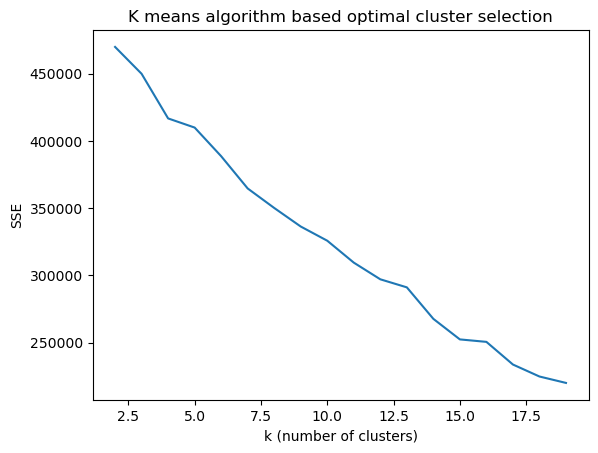

CPU times: total: 37.5 s
Wall time: 6.06 s


In [132]:
%%time
kmeans_clustering_loop(data, range_val=[2,20])

Counts for each label [label: {count}]: {1: {175}, 2: {1}, 3: {1}, 4: {1}, 5: {1}, 6: {1}, 7: {1}, 8: {1}, 9: {1}, 10: {1}, 11: {1}, 12: {1}, 13: {1}, 14: {1}, 15: {1}}


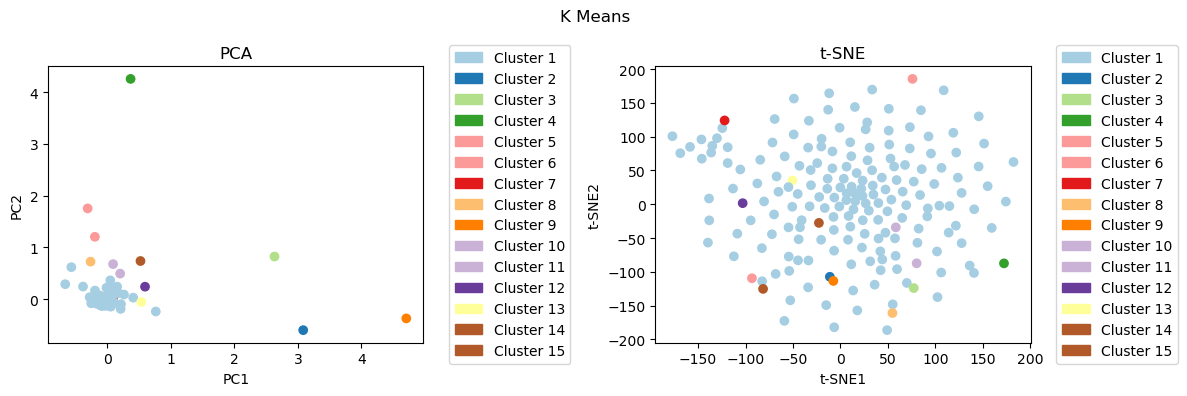

In [31]:
labels = clustering_single(KMeans(n_clusters=15), data, title='K Means')

Not good clusterig results

##### GMM

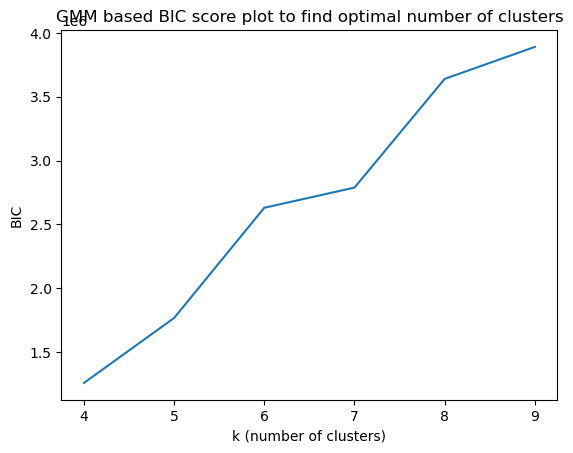

CPU times: total: 7.42 s
Wall time: 1.96 s


In [139]:
%%time
gmm_clustering_loop(data, range_val=[4,10])

Counts for each label [label: {count}]: {1: {14}, 2: {21}, 3: {21}, 4: {16}, 5: {25}, 6: {20}, 7: {12}, 8: {13}, 9: {30}, 10: {17}}
CPU times: total: 8.45 s
Wall time: 1.6 s


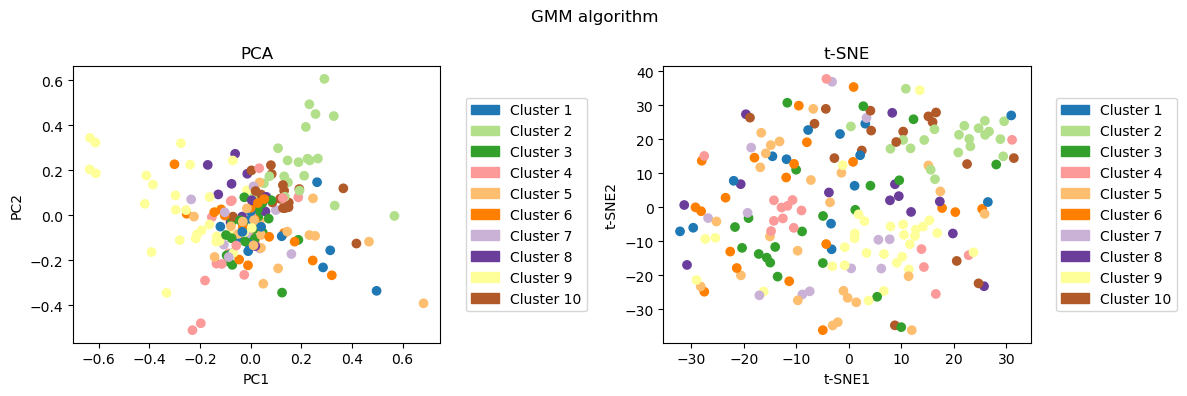

In [142]:
%%time
labels = clustering_single(GaussianMixture(n_components=10), data, title ='GMM algorithm')

**Conclusion:** Can not see any pattern, so no point in further analysis using this method

#### Method 2

We can use the similar approach from CodingLab-5, and first use SVD to find the component having the highest variance for lags.For this, first we will reshape it to (189,6,16\*28), then for each neuron we will find the maximum variance for the projection using svd. So, for each neuron, we have (6,16\*28) and we can reshape it to (16*28,6) and now we will apply PCA and convert it to (16\*28,). So, combining all neuron we will be having an array of (189,16\*28). Now we can apply clustering as usual.

In [143]:
# First converting the data from (189,6,16,28) to (189,16*28) via SVD (selecting on the princial component)
rf_delay = rf_STA.reshape(189,6,-1)

data = np.empty((rf_STA.shape[0], rf_STA.shape[2]*rf_STA.shape[3]))

# Looping over all the neurons
for neuron in range(len(rf_delay)):
    nrf_delay = rf_delay[neuron]
    nrf_delay1 = nrf_delay.T

    # Standardizing before application of 
    nrf_delay1_mean = np.mean(nrf_delay1, axis=1)
    nrf_delay1_centered = nrf_delay1 - nrf_delay1_mean[:, np.newaxis]

    spatial, eigen, temporal = np.linalg.svd(nrf_delay1_centered)
    spatial_comp = spatial[:, 0]
    data[neuron,:] = spatial_comp

print('Shape of STA receptive field:', rf_STA.shape)
print('Shape of modified data:', data.shape)

Shape of STA receptive field: (189, 6, 16, 28)
Shape of modified data: (189, 448)


##### K Means

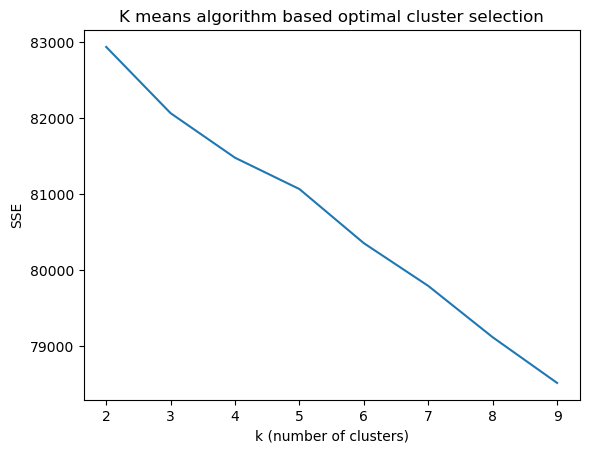

In [144]:
kmeans_clustering_loop(data, range_val=[2,10])

Counts for each label [label: {count}]: {1: {37}, 2: {24}, 3: {19}, 4: {20}, 5: {10}, 6: {13}, 7: {17}, 8: {11}, 9: {22}, 10: {16}}


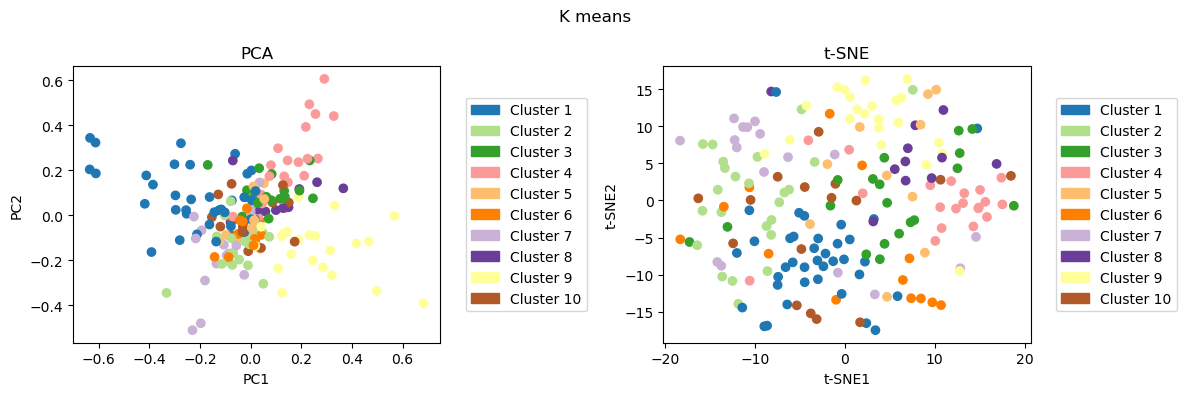

In [156]:
labels = clustering_single(KMeans(n_clusters=10), data, title='K means', perplexity=20, early_exaggeration=10)

##### Subspace Clustering

In [157]:
best_model, best_params = compare_cluster_models(data)

Best model: KMeans
Best params: {'n_components': 5, 'n_clusters': 4}
Best silhouette score: 0.21409446152965642


Counts for each label [label: {count}]: {1: {28}, 2: {82}, 3: {64}, 4: {15}}


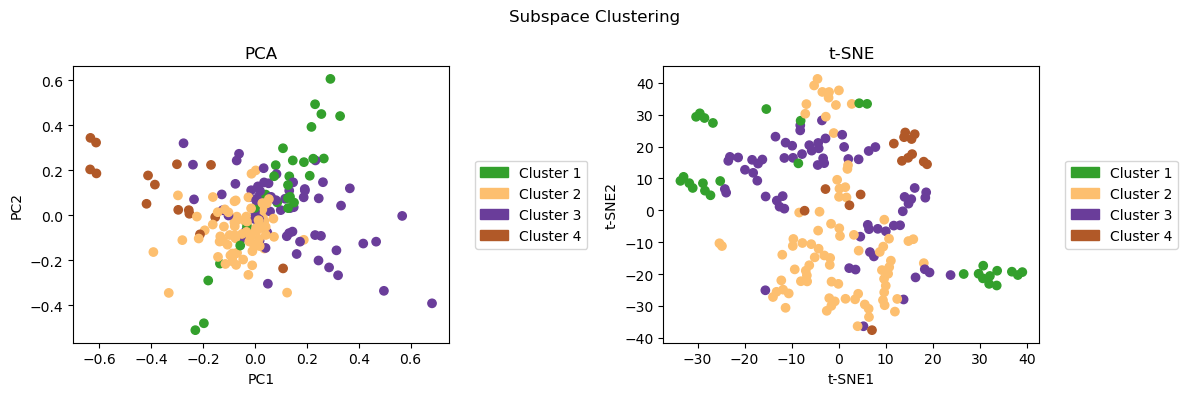

In [158]:
# Refit with best parameters
pca = PCA(n_components=best_params['n_components'])
X_reduced = pca.fit_transform(data)

km = GaussianMixture(n_components=best_params['n_clusters']).fit(X_reduced)
labels = km.predict(X_reduced)

visualize_clustering(X_reduced, labels, title= 'Subspace Clustering')

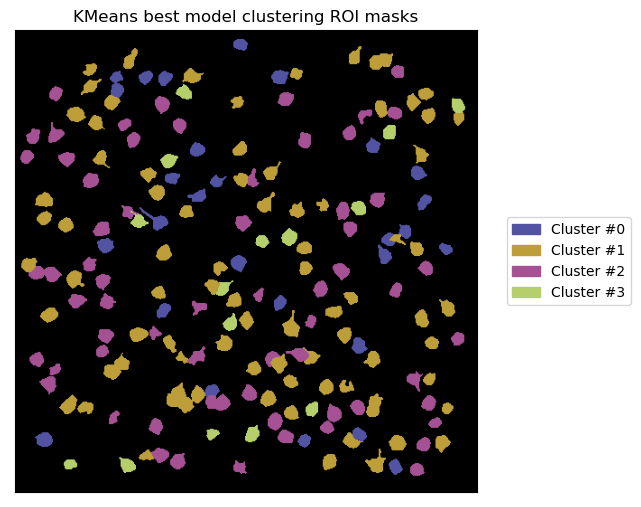

In [179]:
# Now we will be plotting the above labels in roi mask to see similarity in the receptive fields
colors = get_discrete_colors(20)
colors2use = (colors[::2])
n_clusters = len(np.unique(labels))
colors2use = colors2use[:n_clusters]

plot_clusters_roi(roi, labels, colors2use, titlestr="KMeans best model clustering ROI masks");

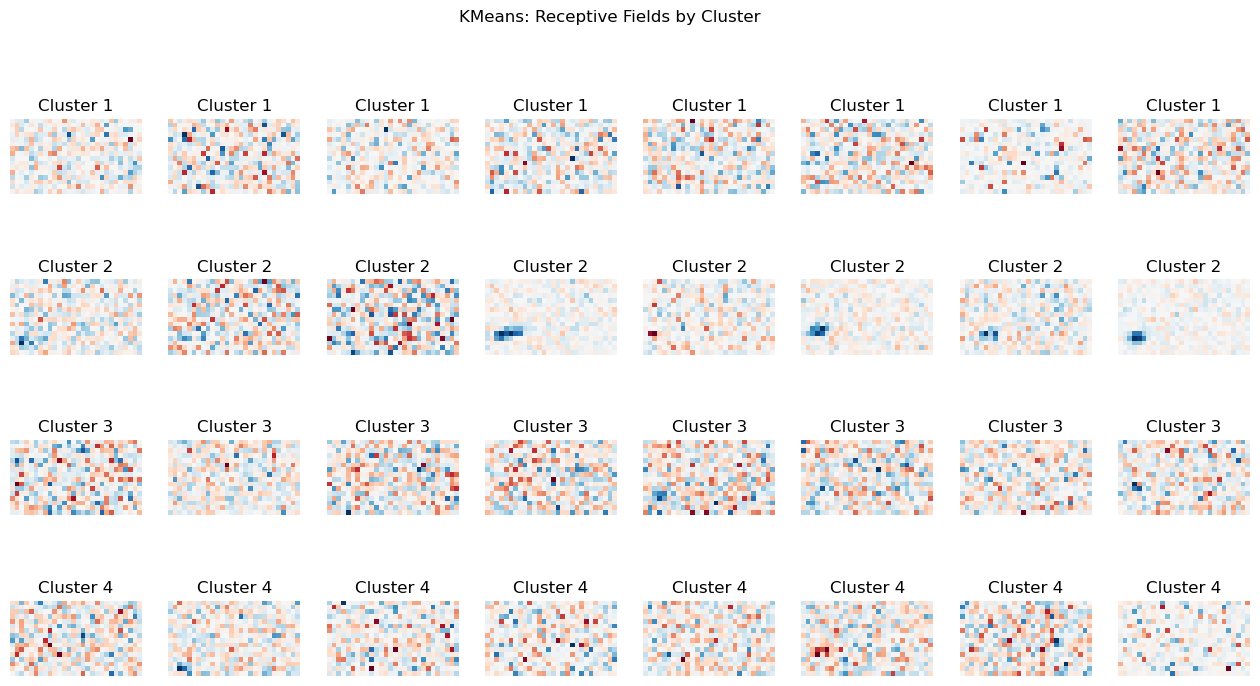

In [158]:
# Receptive field plots
plot_cluster_rf(data, labels, n_plots=8, algo_name=best_model)

**Conclusion**: Not good receptive field. So, we will move on to the next method

#### RFNet Spline LNLN receptive fields

##### **Method 1**: Keeping all the 189 neurons for clustering algorithms


In [180]:
data = rf_LNLN.reshape((rf_LNLN.shape[0], -1)) 
print('Shape of LNN receptive field:', rf_LNLN.shape)
print('Shape of modified data:', data.shape)

Shape of LNN receptive field: (189, 16, 28)
Shape of modified data: (189, 448)


##### K means clustering

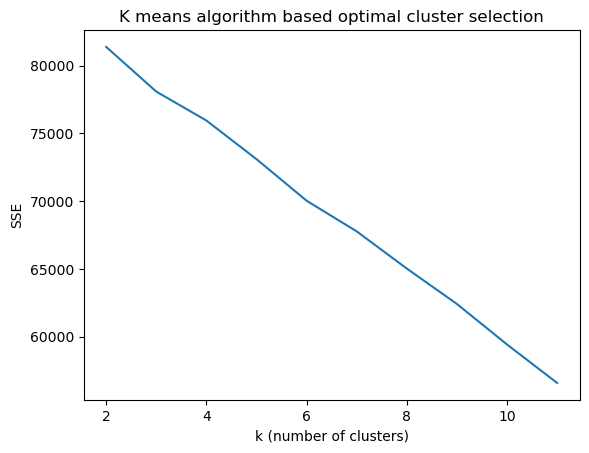

In [181]:
kmeans_clustering_loop(data, range_val=[2,12])

Counts for each label [label: {count}]: {1: {8}, 2: {7}, 3: {9}, 4: {163}, 5: {1}, 6: {1}}


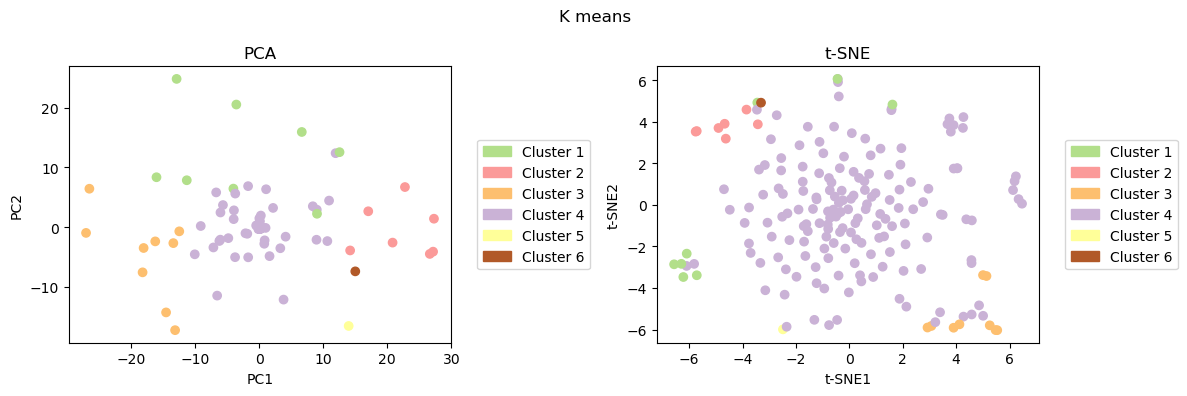

In [185]:
labels = clustering_single(KMeans(n_clusters=6), data, title='K means')

Not good clustering method, so trying another one

##### Subspace Clustering

In [187]:
best_model, best_params = compare_cluster_models(data)

Best model: KMeans
Best params: {'n_components': 5, 'n_clusters': 7}
Best silhouette score: 0.7395548347536784


Counts for each label [label: {count}]: {1: {157}, 2: {12}, 3: {6}, 4: {2}, 5: {4}, 6: {3}, 7: {5}}


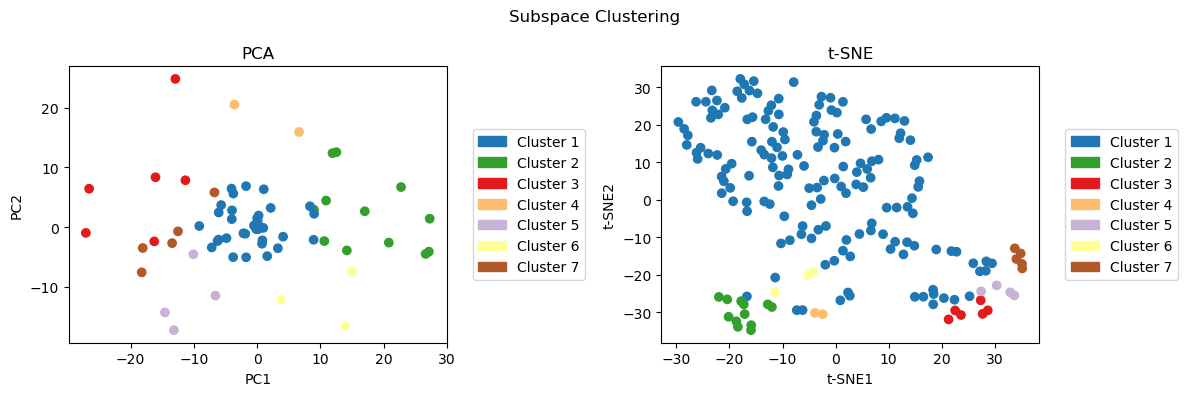

In [188]:
# Refit with best parameters
pca = PCA(n_components=best_params['n_components'])
X_reduced = pca.fit_transform(data)

km = KMeans(n_clusters=best_params['n_clusters']).fit(X_reduced)
labels = km.predict(X_reduced)

visualize_clustering(X_reduced, labels, title= 'Subspace Clustering')

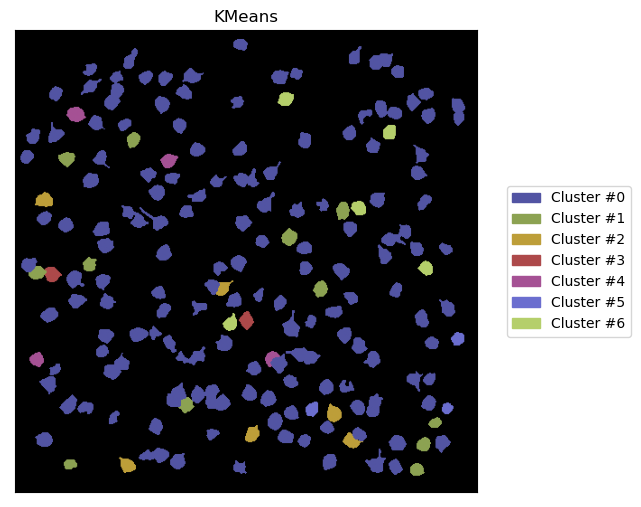

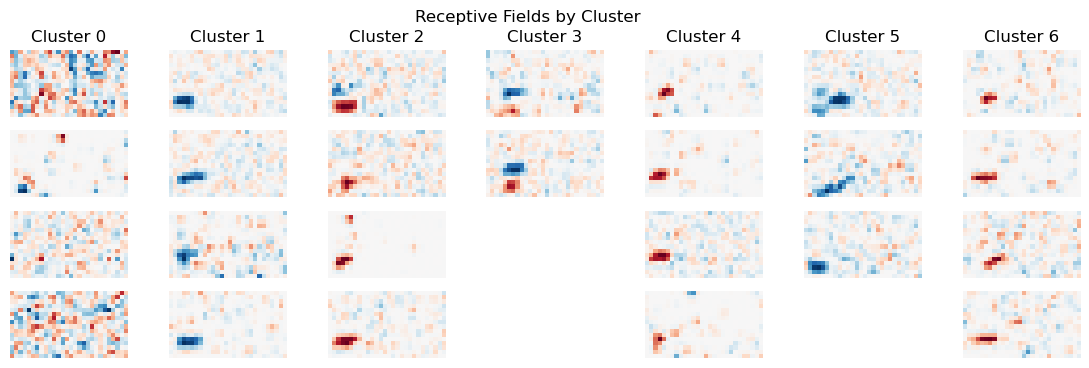

In [191]:
# Now we will be plotting the above labels in roi mask to see similarity in the receptive fields
plot_clusters_roi(roi, labels, titlestr=best_model)
plt.show()

# Receptive field plots
plot_rf_examples(rf, labels, n_plots=4)
plt.show()

**Conclusion**: Much better clustering as we can see similar receptive field for each cluster. We can clearing see that it separated one cluster that does not has proper receptive field. 

##### **Method 2**: Removing neurons with little to no activity


In [193]:
neuron_rfmask = neuron_stats["rf_absmax"] > 1e-1

##### Subspace Clustering

In [194]:
data = rf_LNLN.reshape((rf_LNLN.shape[0], -1)) 
data = data[neuron_rfmask]
print('Shape of LNN receptive field:', rf_LNLN.shape)
print('Shape of modified data:', data.shape)

Shape of LNN receptive field: (189, 16, 28)
Shape of modified data: (81, 448)


In [195]:
best_model, best_params = compare_cluster_models(data)

Best model: AgglomerativeClustering
Best params: {'n_components': 5, 'n_clusters': 7}
Best silhouette score: 0.4465757997928625


Counts for each label [label: {count}]: {1: {15}, 2: {3}, 3: {48}, 4: {5}, 5: {2}, 6: {3}, 7: {5}}


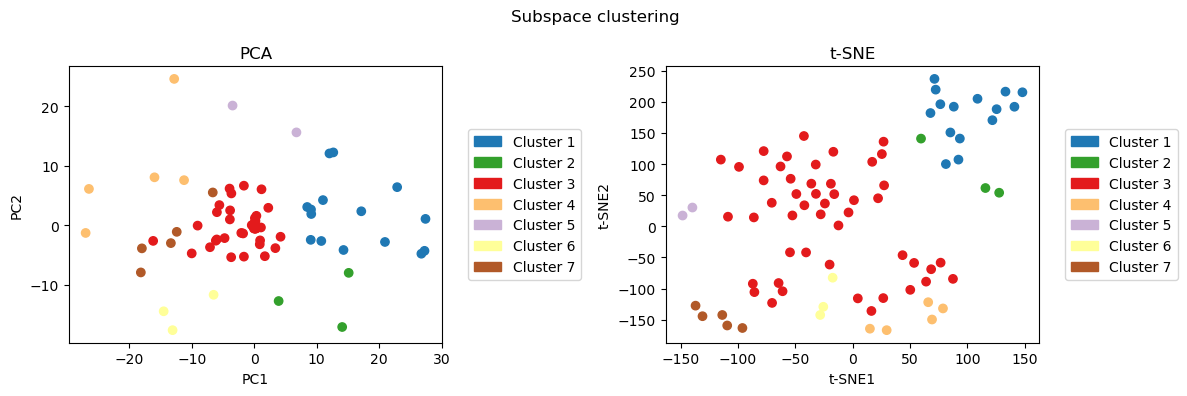

In [196]:
# Refit with best parameters
pca = PCA(n_components=best_params['n_components'])
X_reduced = pca.fit_transform(data)

km = AgglomerativeClustering(n_clusters=best_params['n_clusters']).fit(X_reduced)
labels = km.labels_ #km.predict(X_reduced)

visualize_clustering(X_reduced, labels, title = 'Subspace clustering')

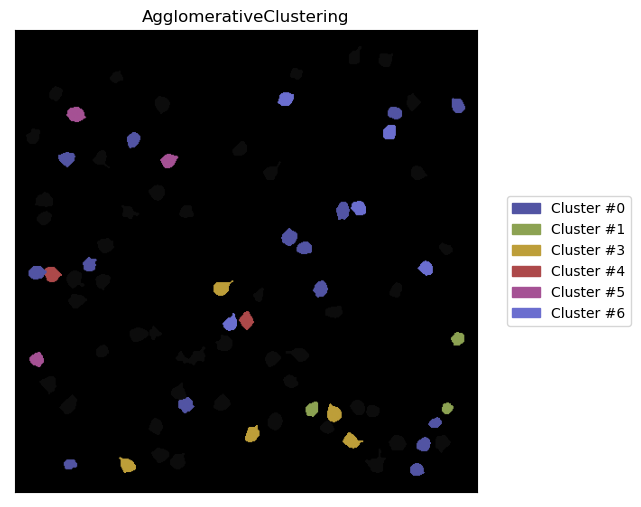

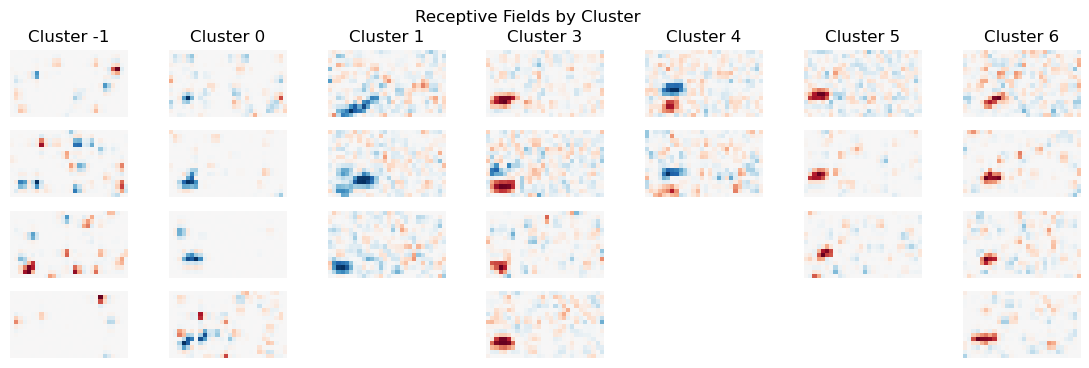

In [203]:
# Now we will be plotting the above labels in roi mask to see similarity in the receptive fields
labels[labels == 2] = -1
plot_clusters_roi(roi[neuron_rfmask], labels, titlestr=best_model)
plt.show()

# Receptive field plots

plot_rf_examples(rf[neuron_rfmask], labels, n_plots=4)
plt.show()

**Conclusion**: Here we got the best cluster, having one-to-one correspondence with similar receptive field clusters

#### Grouping clusters together for visualization

As we can see the some receptive fields are very similar, hence we can manually cluster them for visualization purposes in roi mask

In [204]:
# Merging cluster 4 and 5 
labels[labels==5] = 4

# Merging cluster 6 and 7
labels[labels==7] = 6

# Merging cluster 1 and 2
labels[labels==2] = 1

Counts for each label [label: {count}]: {1: {48}, 2: {15}, 3: {3}, 4: {5}, 5: {5}, 6: {5}}


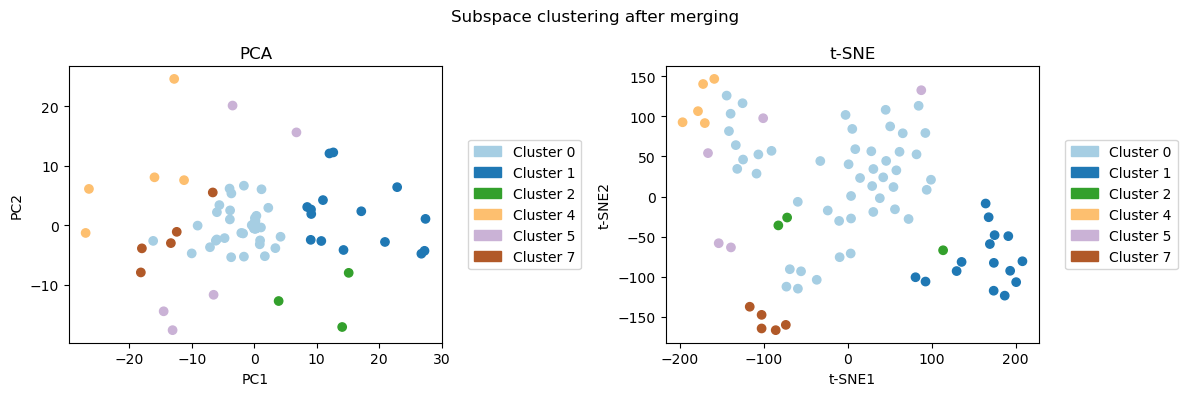

In [208]:
visualize_clustering(X_reduced, labels, title = 'Subspace clustering after merging')

# # Now we will be plotting the above labels in roi mask to see similarity in the receptive fields
# plot_clusters_roi(roi[neuron_rfmask], labels, titlestr=best_model + " after merging clusters manually");

# # Receptive field plots
# plot_rf_examples(rf[neuron_rfmask], labels, n_plots=4);

#### Final clustering result

In [209]:
# FOR REPRODUCIBILITY - the following (final) figure is produced by using these files:

# loading main data 
fname = '81_neuron_data_LNLN_best.npy'
data = np.load(data_path / "clustering" / fname )

# loading pca data
fname =  'pca_reduced_81_neuron_data_LNLN_best.npy'
X_reduced = np.load(data_path / "clustering" / fname )

# laoding labels
fname =  '81_neuron_Kmeans_subspace_clustering_ncomp5_nclust7_reduced.npy'
labels = np.load(data_path / "clustering" / fname)

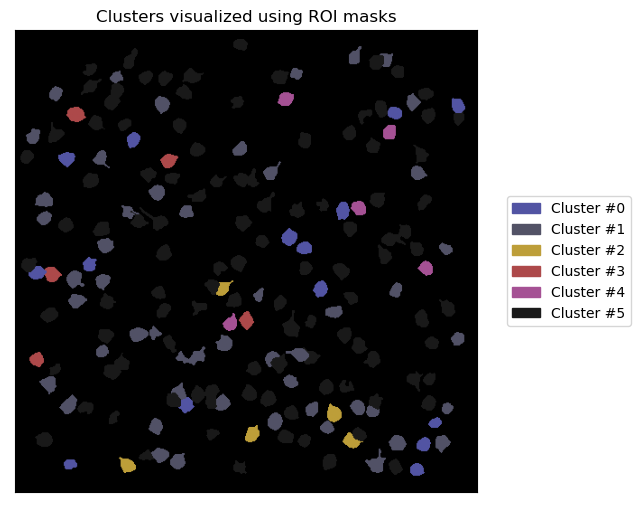

In [210]:
labels_all = np.ones(n_neurons) * 5
labels_all[neuron_rfmask] = labels

colors = get_discrete_colors(labels_all.max() + 1)
colors[1] = np.array([0.8, 0.8, 1]) * 0.4 # gray
colors[5] = np.array([1, 1, 1]) * 0.1 # dark gray for all the rest of the neurons

plot_clusters_roi(roi, labels_all, colors, legend=True);

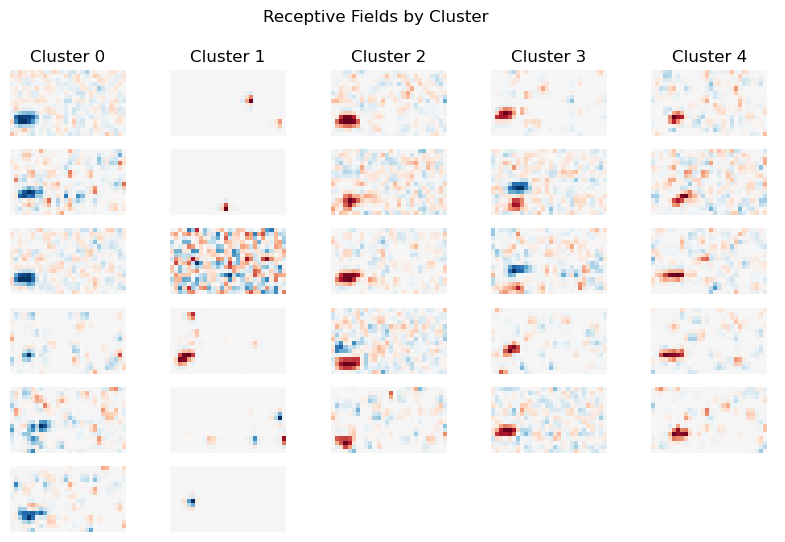

In [211]:
plot_rf_examples(rf[neuron_rfmask], labels, n_plots=6);

#### Clustering conclusions


Clustering performance
- Clustering did somehow well in separating noise RFs
- It definitely separates inhibitory/excitatory receptive fields
- It stuggles with bimodal receptive fields though, possibly because there are not too many examples in the data
- The "good" part of the dataset is not so large. The clustering needs more examples to work correctly.

Clusters interpretation
- What is interesting there are two clusters: 2 and 4, which are capturing excitatory RFs. However in cluster 4 they are narrower, looking more like actually directionally sensitive neurons (orientation of a bar). Interestingly, these neurons are mostly concentrated towards the upper right of the scanning frame in the brain. 
- Cluster 2 is mainly located in the bottom part of the frame, and it consist of "fat" receptive fields, a little bit closer to the bottom left corner of a stimulus frame.
- Inhibitory RFs, on the other hand, are distributed almost uniformly across the imaging frame. However, there are groups of them in the right bottom corner.

#### RFs in the brain based on the signed amplitude

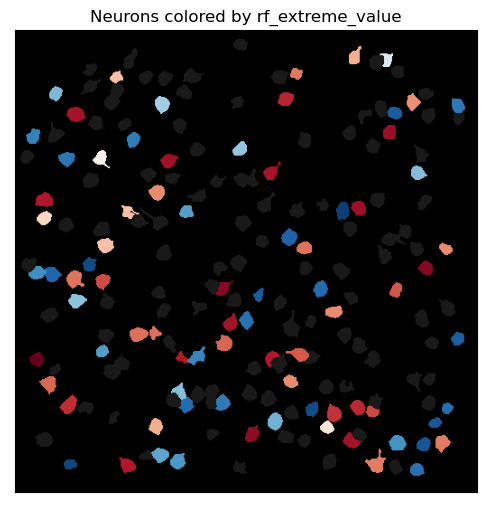

In [237]:
stat = "rf_extreme_value"
vals = neuron_stats[stat]
colors = get_continuous_colors(vals, "RdBu_r", zero_centered=True, shift=0.2, shrink_factor=0.9)
labels = np.zeros(n_neurons)
# labels[1 - nonbullshit] = -1
colors[(1 - nonbullshit).astype(bool)] = np.array([1, 1, 1]) * 0.1 # dark gray
plot_clusters_roi(roi, labels, colors, titlestr=f"Neurons colored by {stat}", legend=False);

- Positive are more or less uniformaly distributed (I'd say even somewhat regularly like a grid). But probably 2D-Fourier analysis is needed to confirm this - and more tuned neruons
- Neurons with "negative" RFs are also distributed uniformly, but they more commonly arrange in spatial clusters.

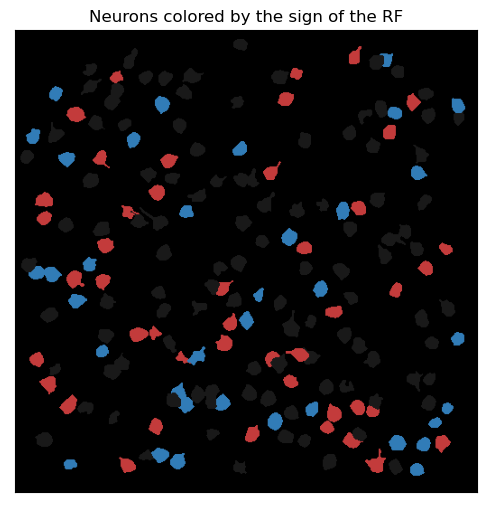

In [249]:
# let's omit amplitude and just look at the sign of the receptive fields. Can we see any more structure?

stat = "rf_extreme_value"
vals = neuron_stats["rf_extreme_value"] / neuron_stats["rf_absmax"]
colors = get_continuous_colors(vals, "RdBu_r", zero_centered=True, shift=0.2, shrink_factor=0.7)
labels = np.zeros(n_neurons)
# labels[1 - nonbullshit] = -1
colors[(1 - neuron_rfmask).astype(bool)] = np.array([1, 1, 1]) * 0.1 # dark gray
plot_clusters_roi(roi, labels, colors, legend=False, titlestr=f"Neurons colored by the sign of the RF");

#### Conclusion

It was hypothesises by me that somehow positive and negative RFs would be separable, however they are really not. The distribution they produce in the brain are beatiful but it is very hard to see any regularities.

# V. Relating receptive field location to the brain

### Getting the RF location within a stimulus frame

Get x and y of the center of the receptive field. To do this, marginalize receptive field over one coordinate to get distribution over the other

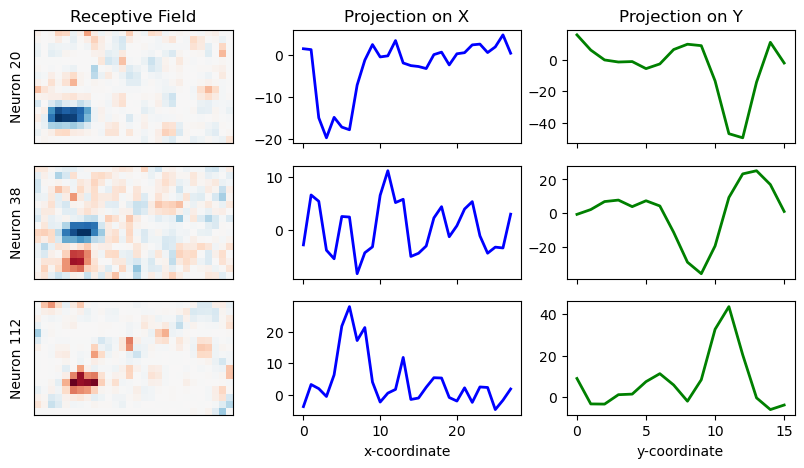

In [24]:
example_neurons = [20, 38, 112]

fig, axes = plt.subplots(len(example_neurons), 3, figsize=(10, 5), sharex='col')

for i in range(len(example_neurons)):
    neuron = example_neurons[i]
    
    if i == 0:
        axes[i, 0].set_title("Receptive Field")
        axes[i, 1].set_title("Projection on X")
        axes[i, 2].set_title("Projection on Y")
    
    # first column - RF
    ax = axes[i, 0]
    w = rf[neuron]
    max_val = np.max(np.abs(w))   
    ax.imshow(w, cmap='RdBu_r', vmin=-max_val, vmax=max_val)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_ylabel(f"Neuron {neuron}")
    
    # second - projection on X
    ax = axes[i, 1]
    ax.plot(rf[neuron].sum(axis=0), linewidth=2, color='blue')
    if i == len(example_neurons) - 1: ax.set_xlabel("x-coordinate")
    
    # second - projection on Y
    ax = axes[i, 2]
    ax.plot(rf[neuron].sum(axis=1), linewidth=2, color='green')
    if i == len(example_neurons) - 1: ax.set_xlabel("y-coordinate")
    

To get the precise RF center we need to denoise the image from unnecessary secondary peaks in the marginals. Most commonly there is only one major 2D-blob in the RF. That means the peak should be easily identifiable given denoised stimulus, because only that 2d-peak will remain. 

To denoise we could utiize the following approach:
1. Zero out all small values within the RF by using cutoff on the zscore.
2. Identify connected 2D-clusters
3. Zero-out those clusters that do not reach sufficient size - i.e. spurious activity sources. 

It is sensible to do that because due to the nature of the stimulus: very sparse (each pixel only has a few non-zero presentations over the course of the experiment) - it is highly probable that STA and LNLN based RF inference will give sporadic results in some of the cases.

Denoising can also help to further filter out those RFs that are noisy and don't convey much useful information - we have already identified a big cluster of them using spectral clustering etc.

#### RF denoising func

In [212]:
def denoise_rf(w, zscore_cutoff=2, min_cluster_size=5):
    """
    Denoises RF to get more clear X and Y projections.
    Uses zscore to label extreme values as 1 and falling below as 0.
    Uses scipy.ndimage.label to find connected features in the image.
    Discards all features with size less than (min_cluster_size)
    
    """
    z = stats.zscore(w, axis=None)
    wb = w.copy()
    zero_mask = np.abs(z) < zscore_cutoff
    wb[zero_mask] = 0

    w_clustered, clusters = ndimage.label(wb)
    
    for c in range(1, clusters + 1):
        if np.sum(w_clustered == c) < min_cluster_size:
            zero_mask[w_clustered == c] = True
    
    w_denoised = w.copy()
    w_denoised[zero_mask] = 0
    return w_denoised

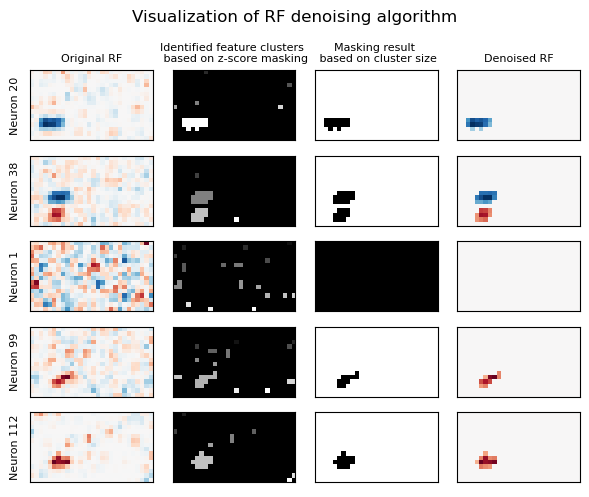

In [213]:
zscore_cutoff = 2
min_cluster_size = 5

example_neurons = [20, 38, 1, 99, 112]
n = len(example_neurons)

fig, axes = plt.subplots(n, 4, figsize=(6, n))
plt.suptitle("Visualization of RF denoising algorithm")

for i, neuron in enumerate(example_neurons):

    w = rf[neuron]

    z = stats.zscore(w, axis=None)
    wb = w.copy()
    zero_mask = np.abs(z) < zscore_cutoff
    wb[zero_mask] = 0

    w_clustered, clusters = ndimage.label(wb)
    
    for c in range(1, clusters + 1):
        if np.sum(w_clustered == c) < min_cluster_size:
            zero_mask[w_clustered == c] = True
    
    w_denoised = w.copy()
    w_denoised[zero_mask] = 0
    
    if i == 0:
        axes[i, 0].set_title("Original RF", fontsize=8)
        axes[i, 1].set_title("Identified feature clusters \n based on z-score masking", fontsize=8)
        axes[i, 2].set_title("Masking result \n based on cluster size", fontsize=8)
        axes[i, 3].set_title("Denoised RF", fontsize=8)
    
    vmax = np.max(np.abs(w))
    axes[i, 0].imshow(w, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axes[i, 1].imshow(w_clustered, cmap='gray')
    axes[i, 2].imshow(zero_mask, cmap='gray') 
    axes[i, 3].imshow(w_denoised, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    
    axes[i, 0].set_ylabel(f"Neuron {neuron}", fontsize=8)
    
for ax in axes.flat:
    ax.set_xticks([]); ax.set_yticks([]);
plt.tight_layout()
plt.show()

Now it possible to easily identify the location of the receptive fields via taking the average of interval boundaries defining the peak of the marginal (projection of receptive field on $x$ and $y$)

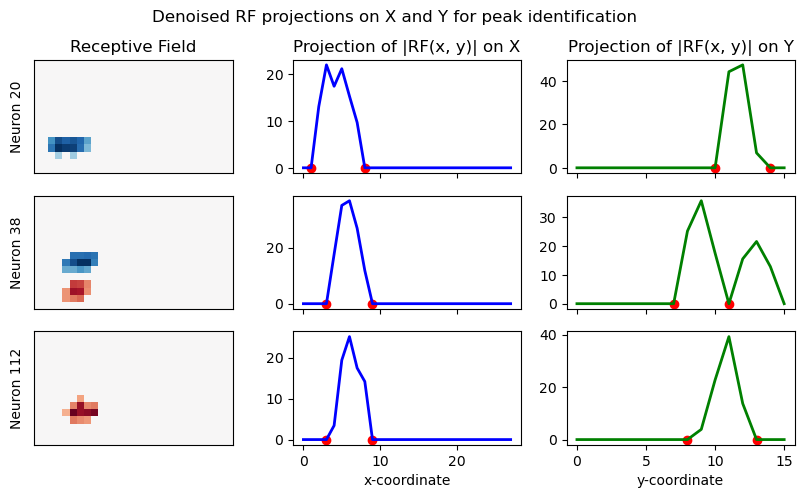

In [216]:
example_neurons = [20, 38, 112]

fig, axes = plt.subplots(len(example_neurons), 3, figsize=(10, 5), sharex='col')

plt.suptitle("Denoised RF projections on X and Y for peak identification")

for i in range(len(example_neurons)):
    neuron = example_neurons[i]
    
    if i == 0:
        axes[i, 0].set_title("Receptive Field")
        axes[i, 1].set_title("Projection of |RF(x, y)| on X")
        axes[i, 2].set_title("Projection of |RF(x, y)| on Y")
    
    # first column - RF
    ax = axes[i, 0]
    w = denoise_rf(rf[neuron])
    max_val = np.max(np.abs(w)) 
    ax.imshow(w, cmap='RdBu_r', vmin=-max_val, vmax=max_val)
    ax.set_xticks([]); ax.set_yticks([]);
    ax.set_ylabel(f"Neuron {neuron}")
    
    # second - projection on X
    mask = np.abs(w).sum(axis=0) > 0
    crossings = np.diff(mask)
    bounds = np.where(crossings)[0]
    x0, x1 = bounds[0], bounds[1] + 1
    
    ax = axes[i, 1]
    ax.plot(np.abs(w).sum(axis=0), linewidth=2, color='blue')
    ax.scatter((x0, x1), (0, 0), color='red')
    if i == len(example_neurons) - 1: ax.set_xlabel("x-coordinate")
    
    # third - projection on Y
    
    mask = np.abs(w).sum(axis=1) > 0
    crossings = np.diff(mask)
    bounds = np.where(crossings)[0]
    y0, y1 = bounds[0], bounds[1] + 1
    ax = axes[i, 2]
    ax.scatter((y0, y1), (0, 0), color='red')
    ax.plot(np.abs(w).sum(axis=1), linewidth=2, color='green')
    if i == len(example_neurons) - 1: ax.set_xlabel("y-coordinate")
    

Due to the existence of bipolar RFs it is needed to estimate position of positive and negative peak separately. For those RFs with no such peak the value will be undefined (set to zero)

In [217]:
def get_peak_loc(w, polarity='positive'):
    
    w = denoise_rf(w)
    if polarity == "negative":
        w[w > 0] = 0
    if polarity == "positive":
        w[w < 0] = 0
    
    # get x loc - marginalize over y
    peak_mask = np.abs(w).sum(axis=0) > 0
    crossings = np.diff(peak_mask)
    if np.sum(crossings) < 2 or not np.sum(peak_mask):
        x = 0
        y = 0
    else:
        bounds = np.where(crossings)[0]
        x0, x1 = bounds[0], bounds[1] + 1
        x = (x0 + x1) / 2
        
    # get y loc - marginalize over x
    peak_mask = np.abs(w).sum(axis=1) > 0
    crossings = np.diff(peak_mask)
    if np.sum(crossings) < 2 or not np.sum(peak_mask):
        x = 0
        y = 0
    else:
        bounds = np.where(crossings)[0]
        y0, y1 = bounds[0], bounds[1] + 1
        y = (y0 + y1) / 2
        y = stim_shape[0] - y
        
    return x, y  

#### Compute RF peak locations

- Negative and positive peak x-position, y-position, distance from stimulus frame center

In [218]:
neuron_stats["rf_x_pos"] = np.zeros(n_neurons)
neuron_stats["rf_y_pos"] = np.zeros(n_neurons)
neuron_stats["rf_x_neg"] = np.zeros(n_neurons)
neuron_stats["rf_y_neg"] = np.zeros(n_neurons)

neuron_stats["rf_r_pos"] = np.zeros(n_neurons)
neuron_stats["rf_r_neg"] = np.zeros(n_neurons)

# to esimate distance from the center of the visual field
xcenter = stim_shape[1] / 2
ycenter = stim_shape[0] / 2

for neuron in range(n_neurons):
    if neuron_stats["rf_absmax"][neuron] < 1e-1:
        x_pos, y_pos, x_neg, y_neg = 0, 0, 0, 0
    else:
        x_pos, y_pos = get_peak_loc(rf[neuron], "positive")
        x_neg, y_neg = get_peak_loc(rf[neuron], "negative")
        
    dist_pos = np.sqrt((x_pos - xcenter) ** 2 + (y_pos - ycenter) ** 2)
    dist_neg = np.sqrt((x_neg - xcenter) ** 2 + (y_neg - ycenter) ** 2)
    
    if x_pos == 0 or y_pos == 0:
        dist_pos = 0
    if x_neg == 0 or y_neg == 0:
        dist_neg = 0
        
    neuron_stats["rf_x_pos"][neuron] = x_pos
    neuron_stats["rf_y_pos"][neuron] = y_pos
    neuron_stats["rf_x_neg"][neuron] = x_neg
    neuron_stats["rf_y_neg"][neuron] = y_neg
    neuron_stats["rf_r_pos"][neuron] = dist_pos
    neuron_stats["rf_r_neg"][neuron] = dist_neg

### Visualize distributions of RF locations

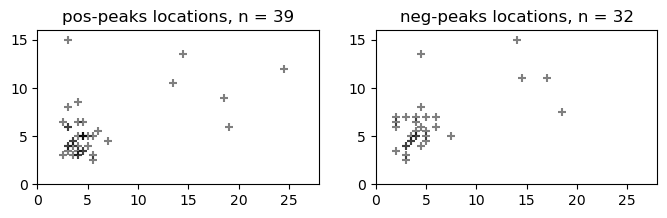

In [250]:
locs = ["rf_x_pos", "rf_y_pos", "rf_x_neg", "rf_y_neg"]

fig, axes = plt.subplots(1, 2, figsize=(8, 2))

for i, polarity in enumerate(["pos", "neg"]):
    ax = axes[i]
    x = neuron_stats[f"rf_x_{polarity}"]
    y = neuron_stats[f"rf_y_{polarity}"]
    n = len(x[x != 0])
    ax.scatter(x[x != 0], y[y != 0], marker='+', color='black', alpha=0.5)
    ax.set_xlim((0, stim_shape[1]))
    ax.set_ylim((0, stim_shape[0]))
    ax.set_title(f"{polarity}-peaks locations, n = {n}")

##### Location of RF within a stimulus frame - observations and interpretation

As was qualitatively seen before - most of the receptive fields concentrate within the bottom left corner of the stimulus frame. It is reasonable to see, because **V1 is retinotopically organized**. That means that V1 cortical surface serves as a (nonlinear) map of the retinal image locations. In our case, we are rather seeing a periferal vision V1 corresponding surface. What would be interesting to test is whether the dispersion of the locations of the receptive fields will change if we move closer to the foveal part of the V1.

Get center of the point clouds and estimate relative distance from the center? (as opposed to distance to the fovea).
It might be useful to get also a sense of measure of deviation of current RF position from the mean position. We will call that rf_r_rel with neg and pos corresponding to the negative and positive peak point clouds respectively.

In [222]:
up_bound = 11

polarity = "pos"
x = neuron_stats[f"rf_x_{polarity}"]
y = neuron_stats[f"rf_y_{polarity}"]
keep = (x != 0) & (y != 0) & (x < up_bound) & (y < up_bound)

x_center_pos = x[keep].mean()
y_center_pos = y[keep].mean()

r = np.zeros(n_neurons)
r[keep] = np.sqrt((x[keep] - x_center_pos) ** 2 + (y[keep] - y_center_pos) ** 2)
neuron_stats["rf_r_rel_pos"] = r


polarity = "neg"
x = neuron_stats[f"rf_x_{polarity}"]
y = neuron_stats[f"rf_y_{polarity}"]
keep = (x != 0) & (y != 0) & (x < up_bound) & (y < up_bound)

x_center_neg = x[keep].mean()
y_center_neg = y[keep].mean()

r = np.zeros(n_neurons)
r[keep] = np.sqrt((x[keep] - x_center_neg) ** 2 + (y[keep] - y_center_neg) ** 2)
neuron_stats["rf_r_rel_neg"] = r

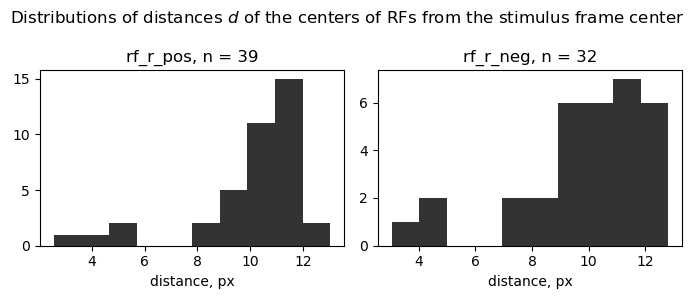

In [228]:
locs = ["rf_r_pos", "rf_r_neg"]

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
plt.suptitle("Distributions of distances $d$ of the centers of RFs from the stimulus frame center")

for i, loc in enumerate(locs):
    dist = neuron_stats[loc]
    ax = axes[i]
    ax.hist(dist[dist != 0], bins=10, alpha=0.8, color='black')
    ax.set_title(f"{loc}, n = {np.sum(dist!=0)}")
    ax.set_xlabel("distance, px")
plt.tight_layout()

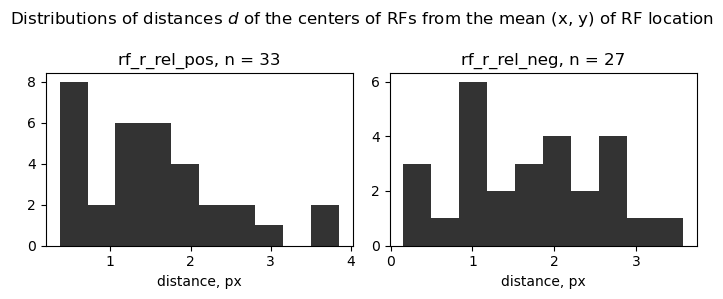

In [230]:
locs = ["rf_r_rel_pos", "rf_r_rel_neg"]

fig, axes = plt.subplots(1, 2, figsize=(7, 3))
plt.suptitle("Distributions of distances $d$ of the centers of RFs from the mean (x, y) of RF location")
for i, loc in enumerate(locs):
    dist = neuron_stats[loc]
    ax = axes[i]
    ax.hist(dist[dist != 0], bins=10, alpha=0.8, color='black')
    ax.set_title(f"{loc}, n = {np.sum(dist!=0)}")
    ax.set_xlabel("distance, px")
plt.tight_layout()

Further we will consider those locations that are within a point cloud of the bottom left corner, since the other few ones look rather like outliers.

### Are neuron locations within V1 and their RF location in the image related?

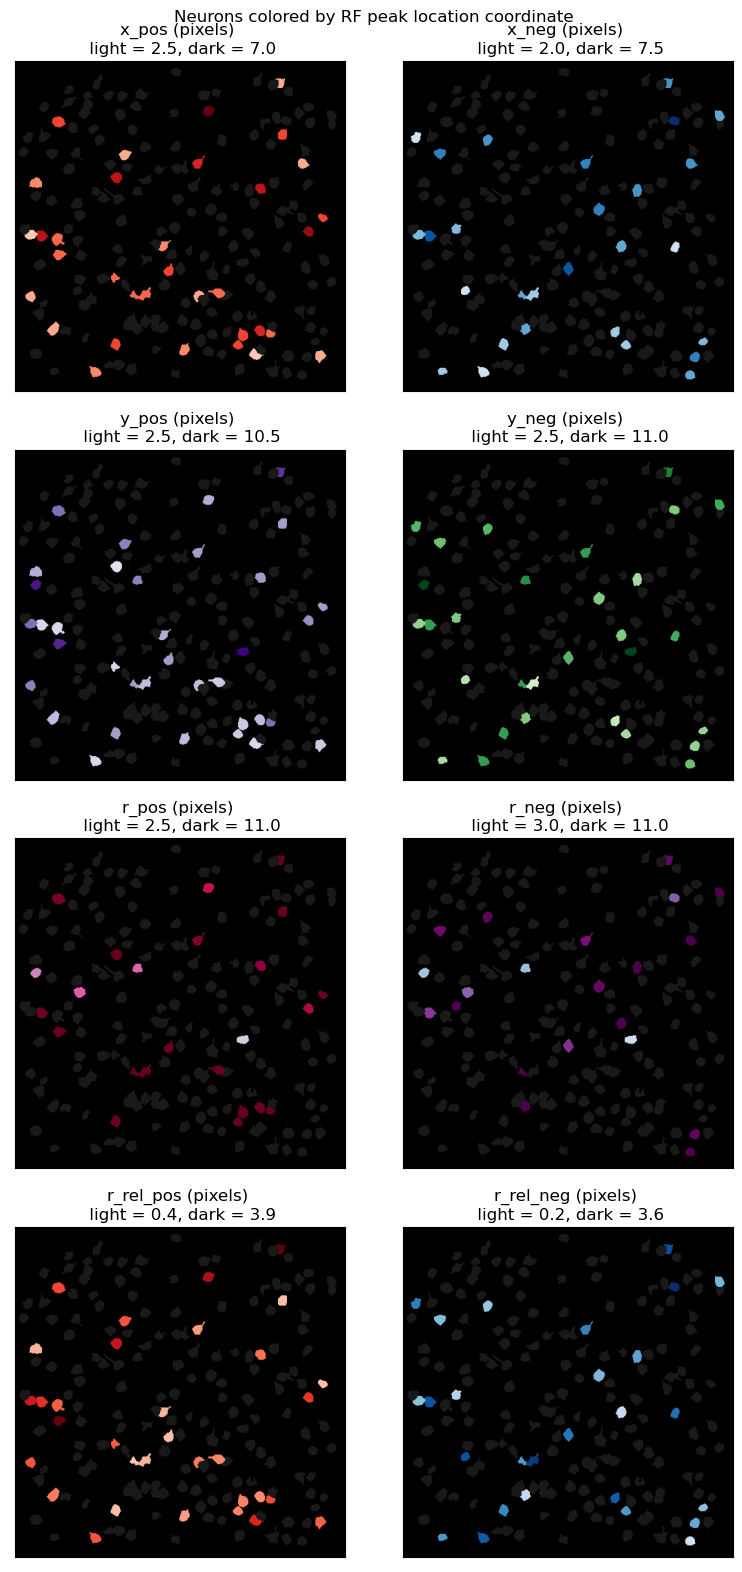

In [231]:
stat_list = ["rf_x_pos", "rf_x_neg", 
             "rf_y_pos", "rf_y_neg", 
             "rf_r_pos", "rf_r_neg", 
             "rf_r_rel_pos", "rf_r_rel_neg"]

cmaps = ["Reds", "Blues", "Purples", "Greens", "PuRd", "BuPu", "Reds", "Blues"]


low_bound, up_bound = 0, 100
fig, axes = plt.subplots(4, 2, figsize=(8, len(stat_list) / 2 * 4))
for i in range(len(stat_list)):

    vals = neuron_stats[stat_list[i]]
    
    # these bounds are to include actually "good" localized receptive fields.
    # likely the others are outliers
    if "_r_" in stat_list[i]:
        low_bound = 6
        up_bound  = 20
    if "r_rel" in stat_list[i]:
        low_bound = 0
        up_bound = 20
    else:
        low_bound = 1
        up_bound = 11
    keep = (vals != 0) & (vals >= low_bound) & (vals <= up_bound)
    colors = np.ones((n_neurons, 3)) * 0.1 # dark gray for all neuron

    colors[keep] = get_continuous_colors(vals[keep], cmaps[i], zero_centered=False, shift=0.2, shrink_factor=0.9)
    labels = np.zeros(n_neurons)

    titlestr = f"{stat_list[i][3:]} (pixels) \n light = {np.min(vals[keep]):.1f}, dark = {np.max(vals[keep]):.1f}"
    ax, _ = plot_clusters_roi(roi, labels, colors, titlestr=None, legend=False, ax=axes.flat[i])
    ax.set_title(titlestr, fontsize=12)
    
plt.suptitle("Neurons colored by RF peak location coordinate")
    
plt.tight_layout()

Visually it is hard to see any gradients of colors - as would be expected if the location of RF and location of a neuron were related. The next and final step is to extract neuron locations within (512, 512) image and correlate these locations with the locations of RF peaks.

### Compute neuron locations (ROI centers)

In [232]:
def get_roi_coordinates(roi, neuron):
    roi_example = roi[neuron]
    x_nonzero = np.nonzero(roi_example.sum(axis=0))[0]
    y_nonzero = np.nonzero(roi_example.sum(axis=1))[0]
    xmin, xmax = x_nonzero[0], x_nonzero[-1]
    ymin, ymax = y_nonzero[0], y_nonzero[-1]
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    return x, roi.shape[0] - y

In [233]:
neuron_stats["brain_x"] = np.zeros(n_neurons)
neuron_stats["brain_y"] = np.zeros(n_neurons)
neuron_stats["brain_r"] = np.zeros(n_neurons)
# distance for radial symmetry?
x0, y0 = 256, 256

for neuron in range(n_neurons):
    x, y = get_roi_coordinates(roi, neuron)
    neuron_stats["brain_x"][neuron] = x
    neuron_stats["brain_y"][neuron] = y
    neuron_stats["brain_r"][neuron] = np.sqrt((x - x0) ** 2 + (y - y0) ** 2)

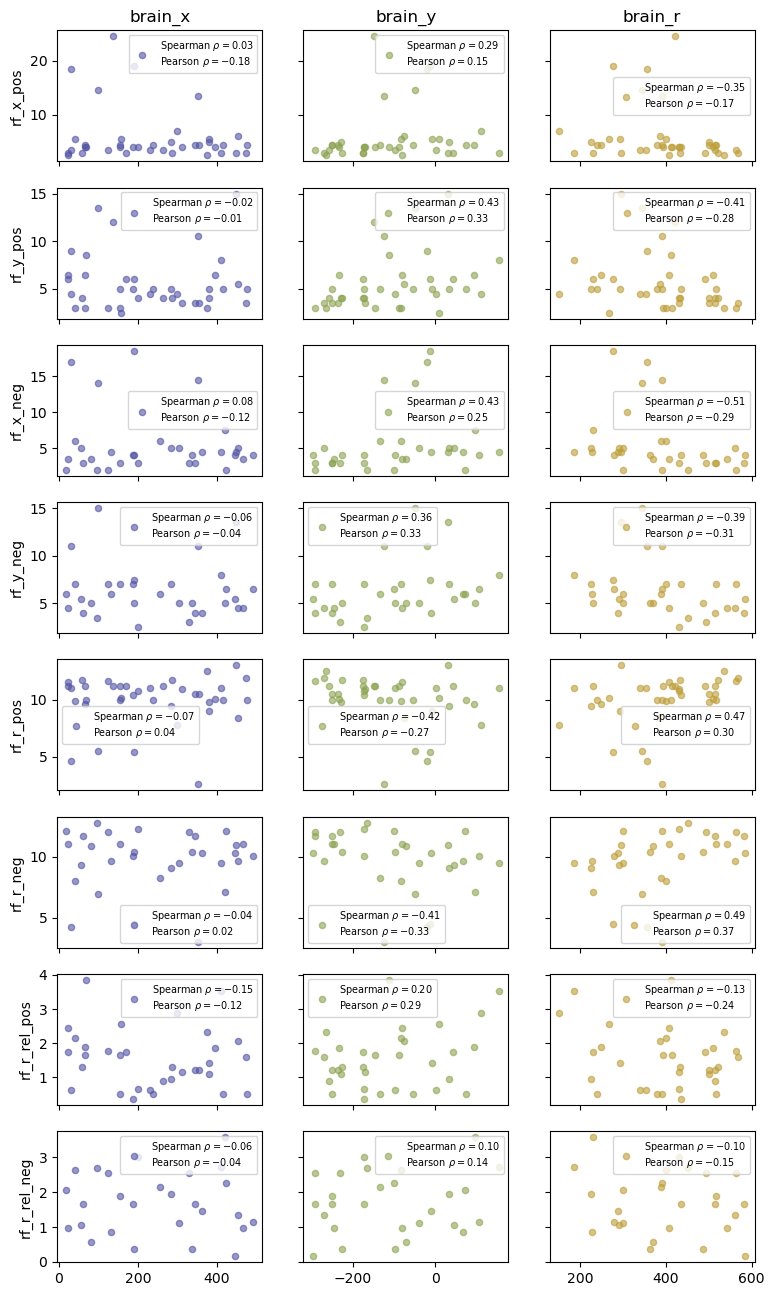

In [234]:
brain_locs = ["brain_x", "brain_y", "brain_r"]
colors = get_discrete_colors(3)
rf_locs    = ["rf_x_pos", "rf_y_pos", "rf_x_neg", "rf_y_neg", "rf_r_pos", "rf_r_neg", "rf_r_rel_pos", "rf_r_rel_neg"]

nrows, ncols = len(rf_locs), len(brain_locs)

corr_pearson = np.zeros((nrows, ncols))
corr_spearman = np.zeros((nrows, ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 2), sharex='col', sharey='row')
for i in range(nrows):
    for j in range(ncols):
        ax = axes[i, j]
        rf_loc = rf_locs[i]
        brain_loc = brain_locs[j]
        x = neuron_stats[brain_loc]
        y = neuron_stats[rf_loc]
        
        rho, pval = stats.spearmanr(x[y != 0], y[y != 0])
        corr_spearman[i, j] = rho
        labelstr = f"Spearman $\\rho={{{rho:.2f}}}$\n"
        rho, pval = stats.pearsonr(x[y != 0], y[y != 0])
        corr_pearson[i, j] = rho
        labelstr += f"Pearson $\\rho={{{rho:.2f}}}$"
           
        ax.scatter(x[y != 0], y[y != 0], color=colors[j], s=20, alpha=0.6, label=labelstr)
        ax.legend(fontsize=7)
        if i == 0:
            ax.set_title(brain_loc)
        if j == 0:
            ax.set_ylabel(rf_loc)       

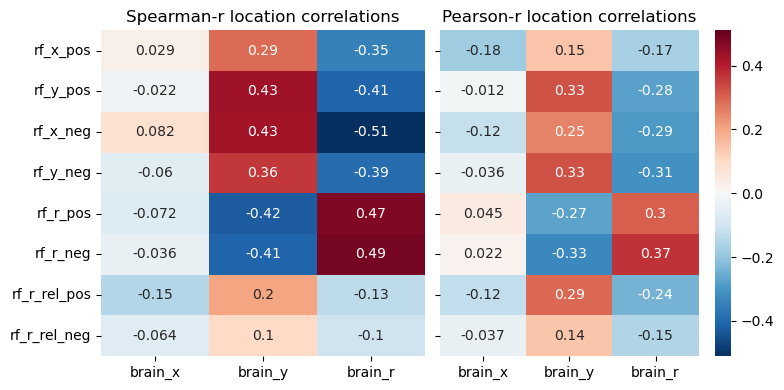

In [235]:
df_corr_pearson = pd.DataFrame(corr_pearson, columns=brain_locs, index=rf_locs)
df_corr_spearman = pd.DataFrame(corr_spearman, columns=brain_locs, index=rf_locs)

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey='row')

vmax = np.maximum(np.max(np.abs(corr_spearman)), np.max(np.abs(corr_pearson))) 
ax = axes[0]
ax.set_title("Spearman-r location correlations")

sns.heatmap(df_corr_spearman, annot=True, ax=ax, cmap='RdBu_r', vmin=-vmax, vmax=vmax, cbar=False)

ax = axes[1]
ax.set_title("Pearson-r location correlations")
sns.heatmap(df_corr_pearson, annot=True, ax=ax, cmap='RdBu_r', vmin=-vmax, vmax=vmax)

plt.tight_layout()

### Location correlations conclusions

- There are very little correlations of any distance (relative or absolute) measure of RF location relative to the x-axis within the scanning frame (brain). 
- However, there are much higher correlations with brain $y$ axis: absolute x and y coordinates of the stimulus frame increase (that is RF goes to the upper-right of the stimulus frame) with the increase in brain y coordinate. This is also reflected in the negative correlation of distance (rf_r_pos, rf_r_neg) of both negative and positive RF peaks relative to the **center** of the stimulus frame and brain $y$ axis.
- Positive correlations with brain_r variable of rf_r variable suggests that the closer is RF to the stimulus center, the closer are also neuron in the brain to the center of the scanning frame.


### Small discussion

One of the reasons we coudn't produce significant results in terms of confirming retinotopy, or inferring direction sensitivity pinwheels is that the scanning frame is too little. The dataset is also not too large and stimuli are rather limiting, being too sparse to produce robust estimates. How could we test for the orientation sensitivity, if the probabity of 7 active pixels in the frame forming a continuous line is so low?

RFs are neverthless estimated, but analysed in such a way that no direction senstivity is inferred. RFs were treated almost like 2D gaussian densities with single best (x, y) location.

Overall, there are 189 neurons of which only 83 show significant tuning to the visual stimuli. Out of them around 60 actually have pronounced receptive fields. But the fact that most of the RFs are located within a narrow range of a stimulus frame tells us that we are looking at the small V1 patch (as the whole V1 should cover the whole visual field). 

Still even on this scale some correlations of RF location shift with respect to brain neuron location are seen!
This is clearly a Nature level finding.

In [254]:
with open("../data/poem.txt", 'r') as f:
    print(*f.readlines(), sep='')

In the realm of data, vast and wide,
We embarked on a research ride.
Forty-eight hours, day and night,
To unravel truths hidden from sight. 

We loaded data, inspected its form,
In the midst of the digital storm.
Missing values, we cast aside,
In this data cleansing tide.

Normalization, the next step,
To remove noise and missteps.
Locally sparse, the stimulus we sought,
In the plots and maps, battles fought.

Then came the spike, inference the game,
Deconvolution, template matching, all the same.
Estimating spike trains, neuron by neuron,
Metrics in hand, like a scientific sermon.

Comparisons made, across neurons and trials,
In the quest for scientific vials.
The journey continued, no time for sitting,
Next up was tuning function fitting.

Orientation, frequency, contrast, and more,
Into the model, they all pour.
Optimization, estimation, a fitting spree,
The goodness-of-fit, the key to see.

Statistical testing, hypotheses in hand,
About receptive fields, we took a stand.
Spatial au